In [1]:
from e2eml.full_processing import postprocessing
from e2eml.regression import regression_blueprints as rb
from e2eml.classification import classification_blueprints as cb
from e2eml.timetravel import timetravel

import pandas as pd
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
import re
import numpy as np
pd.set_option('display.max_colwidth', None)
from statsmodels.tsa import stattools


import pickle
import gc

[nltk_data] Downloading package punkt to /home/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/thomas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/thomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn import metrics

In [3]:
import torch
torch.cuda.is_available()

True

In [5]:
full_df = pd.read_csv("AirPassengers.csv")
full_df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [7]:
list(full_df.columns.difference(["#Passengers"]))

['Month']

In [8]:
original_target = "#Passengers"

In [9]:
target_sensor = original_target
features = list(full_df.columns.difference([target_sensor]))

forecast_lead = 20
target = f"{target_sensor}_lead{forecast_lead}"

full_df[target] = full_df[target_sensor].shift(-forecast_lead)
full_df = full_df.iloc[:-forecast_lead]

<AxesSubplot:>

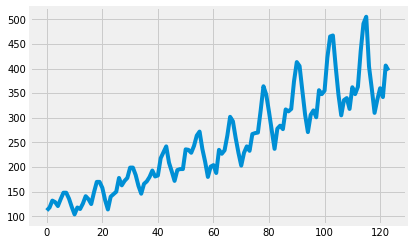

In [10]:
full_df[original_target].plot()

<AxesSubplot:>

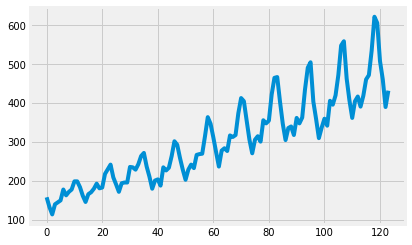

In [11]:
full_df[target].plot()

In [12]:
# add rolling features
def add_rolling_feature(dataframe, col_list, marker_text, time_window):
    """Takes a dataframe, column to use and a time window to create a rolling mean.
    :params:
    dataframe: the dataframe to use the feature from
    col:_name: the column to be used for the rolling feature
    col_list: list of calls to loop through
    marker_text: unique marker to prevent join attachments like x & y
    time_window: number of days to roll over
    returns: the modified dataframe
    """
    for columns in col_list:
        dataframe[f"rolling_avg_{columns}_{time_window}D_{marker_text}"] = dataframe[columns].rolling(window=time_window).mean()
    return dataframe

def add_shifted_features(dataframe, col_list, marker_text, time_window):
    for columns in col_list:
        dataframe[f"shifted_{columns}_{time_window}D_{marker_text}"] = dataframe[columns].shift(time_window)
    return dataframe

    
# verify, that we don't have NULLs left
def raise_nulls(dataframe):
    return print(dataframe.isna().sum().sum())


window_list = [i for i in range(2, 31)]
col_list = full_df.columns.to_list()
col_list.remove("Month")
col_list.remove(target)

for days in window_list:
    add_rolling_feature(full_df, col_list, "fd", days)
    

shift_window_list = [i for i in range(1, 31)]
for days in shift_window_list:
    add_shifted_features(full_df, col_list, "fd", days)

In [13]:
full_len = len(full_df.index)
time_df = full_df.head(full_len-forecast_lead)
holdout_df = full_df.tail(forecast_lead)
val_df_target = holdout_df[target]

In [14]:
del holdout_df[target]

In [15]:
(time_df.index.min(), time_df.index.max())

(0, 103)

In [16]:
(holdout_df.index.min(), holdout_df.index.max())

(104, 123)

# Time seris test

In [17]:
from e2eml.time_series import time_series_blueprints as tsb

In [18]:
ts = tsb.TimeSeriesBluePrint(datasource=time_df,
                                       target_variable=target,
                                       preferred_training_mode='auto',
                                       ml_task='time_series',
                                       rapids_acceleration=False,
                                       cat_encoder_model='target')

Ml task is time_series
Preferred training mode auto has been chosen. e2eml will automatically detect, if LGBM and Xgboost can use GPU acceleration and optimize the workflow accordingly.


In [20]:
ts.target_variable

'#Passengers_lead20'

In [22]:
ts.ml_bp101_multivariate_timeseries_full_processing_lstm()

Started Execute test train split at 11:07:25.
Started Started column type detection and casting at 11:07:25.
Started Checking for duplicate columns at 11:07:25.
Started Reset dataframe index. at 11:07:25.
Started Delete columns with high share of NULLs at 11:07:25.
Started Apply datetime transformation at 11:07:25.
Started Execute categorical encoding at 11:07:25.
Started Fill nulls at 11:07:25.


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

---------------0start-------------


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/thomas/anaconda3/envs/rapids-21.12/bin/../lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


trainscore is 0.4024607240997399
valscore is 0.6629981994021714
Save first model


  0%|                                          | 1/1000 [00:00<14:26,  1.15it/s]

---------------1start-------------
trainscore is 0.32869855791408636
valscore is 0.3777537611776499
found better point


  0%|                                          | 2/1000 [00:01<13:18,  1.25it/s]

---------------2start-------------
trainscore is 0.1649813656612999
valscore is 0.2355270828456669
found better point


  0%|▏                                         | 3/1000 [00:02<12:41,  1.31it/s]

---------------3start-------------
trainscore is 0.20149401735013112


  0%|▏                                         | 4/1000 [00:02<09:43,  1.71it/s]

valscore is 0.28589250105517766
---------------4start-------------
trainscore is 0.17775266205401036
valscore is 0.17020779020999643
found better point


  0%|▏                                         | 5/1000 [00:03<10:29,  1.58it/s]

---------------5start-------------
trainscore is 0.12283481490120628


  1%|▎                                         | 6/1000 [00:03<08:38,  1.92it/s]

valscore is 0.2973490981516467
---------------6start-------------
trainscore is 0.15494889776232382


  1%|▎                                         | 7/1000 [00:03<07:23,  2.24it/s]

valscore is 0.24857947128813673
---------------7start-------------
trainscore is 0.11981364389472388
valscore is 0.14990621911548752
found better point


  1%|▎                                         | 8/1000 [00:04<08:49,  1.87it/s]

---------------8start-------------
trainscore is 0.12003322409463016


  1%|▍                                         | 9/1000 [00:05<07:41,  2.15it/s]

valscore is 0.15089869553315852
---------------9start-------------
trainscore is 0.11177647908621371


  1%|▍                                        | 10/1000 [00:05<06:48,  2.42it/s]

valscore is 0.17381974482881704
---------------10start-------------
trainscore is 0.10805542045445515


  1%|▍                                        | 11/1000 [00:05<06:04,  2.72it/s]

valscore is 0.205021694524505
---------------11start-------------
trainscore is 0.10497856625177533
valscore is 0.13184898669631645
found better point


  1%|▍                                        | 12/1000 [00:06<07:51,  2.10it/s]

---------------12start-------------
trainscore is 0.09035277068399415
valscore is 0.12581145623156068
found better point


  1%|▌                                        | 13/1000 [00:07<09:16,  1.77it/s]

---------------13start-------------
trainscore is 0.07982251005681795


  1%|▌                                        | 14/1000 [00:07<07:51,  2.09it/s]

valscore is 0.13158980528070133
---------------14start-------------
trainscore is 0.07692533227849246


  2%|▌                                        | 15/1000 [00:07<07:04,  2.32it/s]

valscore is 0.15828659661294348
---------------15start-------------
trainscore is 0.07077812795366253
valscore is 0.10412008363132268
found better point


  2%|▋                                        | 16/1000 [00:08<08:31,  1.92it/s]

---------------16start-------------
trainscore is 0.06166392189669201


  2%|▋                                        | 17/1000 [00:08<07:28,  2.19it/s]

valscore is 0.16463020067267137
---------------17start-------------
trainscore is 0.06921413579289738


  2%|▋                                        | 18/1000 [00:08<06:44,  2.43it/s]

valscore is 0.3587320203776351
---------------18start-------------
trainscore is 0.11105168643143752


  2%|▊                                        | 19/1000 [00:09<06:06,  2.68it/s]

valscore is 0.14113894765174065
---------------19start-------------
trainscore is 0.08178592156391755


  2%|▊                                        | 20/1000 [00:09<05:45,  2.84it/s]

valscore is 0.25822090849691043
---------------20start-------------
trainscore is 0.07679894359838992


  2%|▊                                        | 21/1000 [00:09<05:30,  2.97it/s]

valscore is 0.14349201656395397
---------------21start-------------
trainscore is 0.08329250485457007


  2%|▉                                        | 22/1000 [00:10<05:19,  3.06it/s]

valscore is 0.21083877927366856
---------------22start-------------
trainscore is 0.07714401925193812


  2%|▉                                        | 23/1000 [00:10<05:11,  3.13it/s]

valscore is 0.12436227859500588
---------------23start-------------
trainscore is 0.08462246017306077


  2%|▉                                        | 24/1000 [00:10<05:08,  3.17it/s]

valscore is 0.1374152832323286
---------------24start-------------
trainscore is 0.0761224929450466
valscore is 0.10345198311461362
found better point


  2%|█                                        | 25/1000 [00:11<07:24,  2.19it/s]

---------------25start-------------
trainscore is 0.06696275126624807


  3%|█                                        | 26/1000 [00:11<06:31,  2.49it/s]

valscore is 0.12027819376811513
---------------26start-------------
trainscore is 0.05135512576779434


  3%|█                                        | 27/1000 [00:12<06:00,  2.70it/s]

valscore is 0.11771799138193532
---------------27start-------------
trainscore is 0.04908003204775017


  3%|█▏                                       | 28/1000 [00:12<05:38,  2.87it/s]

valscore is 0.12946538548351094
---------------28start-------------
trainscore is 0.04458205821662185


  3%|█▏                                       | 29/1000 [00:12<05:26,  2.97it/s]

valscore is 0.21098619582562048
---------------29start-------------
trainscore is 0.04839496036054115


  3%|█▏                                       | 30/1000 [00:13<05:22,  3.01it/s]

valscore is 0.2492672354273542
---------------30start-------------
trainscore is 0.05316909553685204


  3%|█▎                                       | 31/1000 [00:13<05:13,  3.09it/s]

valscore is 0.1447179033103723
---------------31start-------------
trainscore is 0.04300848602217489
valscore is 0.10179522160352342
found better point


  3%|█▎                                       | 32/1000 [00:14<07:13,  2.23it/s]

---------------32start-------------
trainscore is 0.06276166960061948


  3%|█▎                                       | 33/1000 [00:14<06:28,  2.49it/s]

valscore is 0.1678509823312846
---------------33start-------------
trainscore is 0.046951768951006646


  3%|█▍                                       | 34/1000 [00:14<05:56,  2.71it/s]

valscore is 0.20217683138549858
---------------34start-------------
trainscore is 0.05019748842255135


  4%|█▍                                       | 35/1000 [00:15<05:35,  2.87it/s]

valscore is 0.1068886612296425
---------------35start-------------
trainscore is 0.06720909048485448
valscore is 0.09535511134646146
found better point


  4%|█▍                                       | 36/1000 [00:15<07:13,  2.22it/s]

---------------36start-------------
trainscore is 0.07507931447004772


  4%|█▌                                       | 37/1000 [00:15<06:27,  2.49it/s]

valscore is 0.2643681125338824
---------------37start-------------
trainscore is 0.09790455972002043


  4%|█▌                                       | 38/1000 [00:16<05:54,  2.71it/s]

valscore is 0.16911407937786813
---------------38start-------------
trainscore is 0.1156321798884325


  4%|█▌                                       | 39/1000 [00:16<05:39,  2.83it/s]

valscore is 0.09824846592461588
---------------39start-------------
trainscore is 0.06597580776495912


  4%|█▋                                       | 40/1000 [00:16<05:27,  2.93it/s]

valscore is 0.09871479531341051
---------------40start-------------
trainscore is 0.05579056587170772


  4%|█▋                                       | 41/1000 [00:17<05:05,  3.14it/s]

valscore is 0.10891484396496193
---------------41start-------------
trainscore is 0.04097317538712195


  4%|█▋                                       | 42/1000 [00:17<05:00,  3.19it/s]

valscore is 0.1468234667546107
---------------42start-------------
trainscore is 0.04445477260740477


  4%|█▊                                       | 43/1000 [00:17<04:49,  3.30it/s]

valscore is 0.1619876411006183
---------------43start-------------
trainscore is 0.040459799573650354
valscore is 0.09459360123848388
found better point


  4%|█▊                                       | 44/1000 [00:18<06:57,  2.29it/s]

---------------44start-------------
trainscore is 0.04360675296296548


  4%|█▊                                       | 45/1000 [00:18<06:16,  2.54it/s]

valscore is 0.1414939015269133
---------------45start-------------
trainscore is 0.04386166752907409


  5%|█▉                                       | 46/1000 [00:19<05:51,  2.71it/s]

valscore is 0.11770979668183584
---------------46start-------------
trainscore is 0.04475107397880504


  5%|█▉                                       | 47/1000 [00:19<05:33,  2.86it/s]

valscore is 0.11035724025656907
---------------47start-------------
trainscore is 0.0503707711799056


  5%|█▉                                       | 48/1000 [00:19<05:08,  3.08it/s]

valscore is 0.18777286844381771
---------------48start-------------
trainscore is 0.060615385450961096


  5%|██                                       | 49/1000 [00:19<04:57,  3.20it/s]

valscore is 0.12857803525720726
---------------49start-------------
trainscore is 0.04400603630725421


  5%|██                                       | 50/1000 [00:20<04:55,  3.22it/s]

valscore is 0.10185623232792998
---------------50start-------------
trainscore is 0.04086053890534635


  5%|██                                       | 51/1000 [00:20<04:51,  3.26it/s]

valscore is 0.1155545746529603
---------------51start-------------
trainscore is 0.036648726552666086


  5%|██▏                                      | 52/1000 [00:20<04:40,  3.38it/s]

valscore is 0.15816082390694994
---------------52start-------------
trainscore is 0.04018114426010193


  5%|██▏                                      | 53/1000 [00:21<04:36,  3.43it/s]

valscore is 0.22098617958230465
---------------53start-------------
trainscore is 0.05374978027717657
valscore is 0.08730555836730755
found better point


  5%|██▏                                      | 54/1000 [00:21<06:44,  2.34it/s]

---------------54start-------------
trainscore is 0.04553954379471356


  6%|██▎                                      | 55/1000 [00:22<06:05,  2.58it/s]

valscore is 0.11146982770305913
---------------55start-------------
trainscore is 0.03921035787545449


  6%|██▎                                      | 56/1000 [00:22<05:43,  2.75it/s]

valscore is 0.1988274855533496
---------------56start-------------
trainscore is 0.044196582929816694


  6%|██▎                                      | 57/1000 [00:22<05:28,  2.87it/s]

valscore is 0.09457536026247718
---------------57start-------------
trainscore is 0.04973504775612399


  6%|██▍                                      | 58/1000 [00:23<05:10,  3.03it/s]

valscore is 0.09134303140819124
---------------58start-------------
trainscore is 0.043217344774750976


  6%|██▍                                      | 59/1000 [00:23<05:01,  3.12it/s]

valscore is 0.17581323881874497
---------------59start-------------
trainscore is 0.03865801776266082


  6%|██▍                                      | 60/1000 [00:23<04:57,  3.16it/s]

valscore is 0.10271038615586656
---------------60start-------------
trainscore is 0.04348029284083248


  6%|██▌                                      | 61/1000 [00:23<04:49,  3.25it/s]

valscore is 0.0885642869338543
---------------61start-------------
trainscore is 0.06517055767215929


  6%|██▌                                      | 62/1000 [00:24<04:46,  3.27it/s]

valscore is 0.16422613756808233
---------------62start-------------
trainscore is 0.0565920702091692


  6%|██▌                                      | 63/1000 [00:24<04:37,  3.37it/s]

valscore is 0.10591748916161602
---------------63start-------------
trainscore is 0.0571084468787599


  6%|██▌                                      | 64/1000 [00:24<04:38,  3.37it/s]

valscore is 0.18395015833792033
---------------64start-------------
trainscore is 0.059422751031205534


  6%|██▋                                      | 65/1000 [00:25<04:39,  3.35it/s]

valscore is 0.11507793865420125
---------------65start-------------
trainscore is 0.06996406262597854


  7%|██▋                                      | 66/1000 [00:25<04:40,  3.32it/s]

valscore is 0.1732657153526013
---------------66start-------------
trainscore is 0.061234955068269835


  7%|██▋                                      | 67/1000 [00:25<04:43,  3.29it/s]

valscore is 0.09368962125895651
---------------67start-------------
trainscore is 0.0420129752139122


  7%|██▊                                      | 68/1000 [00:26<04:39,  3.33it/s]

valscore is 0.1115960772241647
---------------68start-------------
trainscore is 0.031952859395806894


  7%|██▊                                      | 69/1000 [00:26<04:43,  3.28it/s]

valscore is 0.15067561630210446
---------------69start-------------
trainscore is 0.027231769556399426


  7%|██▊                                      | 70/1000 [00:26<04:42,  3.29it/s]

valscore is 0.16847117224057878
---------------70start-------------
trainscore is 0.0464074831895033


  7%|██▉                                      | 71/1000 [00:26<04:32,  3.40it/s]

valscore is 0.09689715639981687
---------------71start-------------
trainscore is 0.052916287281623564


  7%|██▉                                      | 72/1000 [00:27<04:34,  3.38it/s]

valscore is 0.10360956605339768
---------------72start-------------
trainscore is 0.07868121165441144


  7%|██▉                                      | 73/1000 [00:27<04:35,  3.36it/s]

valscore is 0.13622317904703649
---------------73start-------------
trainscore is 0.05787484723092591


  7%|███                                      | 74/1000 [00:27<04:36,  3.35it/s]

valscore is 0.09654470392545615
---------------74start-------------
trainscore is 0.051822798763137
valscore is 0.08535931999289963
found better point


  8%|███                                      | 75/1000 [00:28<06:38,  2.32it/s]

---------------75start-------------
trainscore is 0.0502597909724388


  8%|███                                      | 76/1000 [00:28<05:55,  2.60it/s]

valscore is 0.09589982741620298
---------------76start-------------
trainscore is 0.04174381936572366


  8%|███▏                                     | 77/1000 [00:29<05:20,  2.88it/s]

valscore is 0.16283614703588967
---------------77start-------------
trainscore is 0.056195594665675704
valscore is 0.08453079115671196
found better point


  8%|███▏                                     | 78/1000 [00:29<07:08,  2.15it/s]

---------------78start-------------
trainscore is 0.04116535856996509


  8%|███▏                                     | 79/1000 [00:30<06:18,  2.43it/s]

valscore is 0.12983080957778884
---------------79start-------------
trainscore is 0.047478428514995424


  8%|███▎                                     | 80/1000 [00:30<05:41,  2.69it/s]

valscore is 0.1321875012671998
---------------80start-------------
trainscore is 0.03344361521468807
valscore is 0.0839613850991915
found better point


  8%|███▎                                     | 81/1000 [00:31<07:26,  2.06it/s]

---------------81start-------------
trainscore is 0.03275003764471784


  8%|███▎                                     | 82/1000 [00:31<06:25,  2.38it/s]

valscore is 0.0930750178431541
---------------82start-------------
trainscore is 0.031113286478973545


  8%|███▍                                     | 83/1000 [00:31<05:45,  2.66it/s]

valscore is 0.1423702284405757
---------------83start-------------
trainscore is 0.06102700079100542


  8%|███▍                                     | 84/1000 [00:32<05:22,  2.84it/s]

valscore is 0.09391941993755866
---------------84start-------------
trainscore is 0.05564367892356914
valscore is 0.07713762469470233
found better point


  8%|███▍                                     | 85/1000 [00:32<07:07,  2.14it/s]

---------------85start-------------
trainscore is 0.048122902402448466


  9%|███▌                                     | 86/1000 [00:33<06:22,  2.39it/s]

valscore is 0.10436851962776639
---------------86start-------------
trainscore is 0.03064372368126521


  9%|███▌                                     | 87/1000 [00:33<05:54,  2.58it/s]

valscore is 0.08336121671873752
---------------87start-------------
trainscore is 0.028477075799427147


  9%|███▌                                     | 88/1000 [00:33<05:33,  2.73it/s]

valscore is 0.10505752766489716
---------------88start-------------
trainscore is 0.023456579131116758


  9%|███▋                                     | 89/1000 [00:34<05:23,  2.81it/s]

valscore is 0.11217956060483775
---------------89start-------------
trainscore is 0.037310834186583736


  9%|███▋                                     | 90/1000 [00:34<05:24,  2.81it/s]

valscore is 0.08825218097534492
---------------90start-------------
trainscore is 0.03394689245846388


  9%|███▋                                     | 91/1000 [00:34<05:02,  3.01it/s]

valscore is 0.13764566454705152
---------------91start-------------
trainscore is 0.03491455644313338


  9%|███▊                                     | 92/1000 [00:34<04:53,  3.09it/s]

valscore is 0.1285501842628834
---------------92start-------------
trainscore is 0.03448321447948379


  9%|███▊                                     | 93/1000 [00:35<04:44,  3.19it/s]

valscore is 0.07902821192694319
---------------93start-------------
trainscore is 0.03899324947055025


  9%|███▊                                     | 94/1000 [00:35<04:45,  3.17it/s]

valscore is 0.10341016267554672
---------------94start-------------
trainscore is 0.041647241235950865


 10%|███▉                                     | 95/1000 [00:35<04:46,  3.16it/s]

valscore is 0.09620454695612783
---------------95start-------------
trainscore is 0.02657475559278949


 10%|███▉                                     | 96/1000 [00:36<04:50,  3.11it/s]

valscore is 0.08740721204241664
---------------96start-------------
trainscore is 0.033949388357924194


 10%|███▉                                     | 97/1000 [00:36<04:49,  3.12it/s]

valscore is 0.11357675333225309
---------------97start-------------
trainscore is 0.02838266256026322


 10%|████                                     | 98/1000 [00:36<04:48,  3.12it/s]

valscore is 0.1278990305157871
---------------98start-------------
trainscore is 0.021220037524818307


 10%|████                                     | 99/1000 [00:37<04:42,  3.19it/s]

valscore is 0.11864197267035083
---------------99start-------------
trainscore is 0.025689696927222585


 10%|████                                    | 100/1000 [00:37<04:45,  3.15it/s]

valscore is 0.13974750325667165
---------------100start-------------
trainscore is 0.03601583337095215


 10%|████                                    | 101/1000 [00:37<04:34,  3.27it/s]

valscore is 0.08116950226756638
---------------101start-------------
trainscore is 0.031622236498114326


 10%|████                                    | 102/1000 [00:38<04:40,  3.20it/s]

valscore is 0.1011141241940182
---------------102start-------------
trainscore is 0.021558883741634897


 10%|████                                    | 103/1000 [00:38<04:37,  3.23it/s]

valscore is 0.0967516310027695
---------------103start-------------
trainscore is 0.019277820956771434


 10%|████▏                                   | 104/1000 [00:38<04:41,  3.19it/s]

valscore is 0.10094002692415954
---------------104start-------------
trainscore is 0.02010997940805172


 10%|████▏                                   | 105/1000 [00:39<04:44,  3.15it/s]

valscore is 0.15075909932445625
---------------105start-------------
trainscore is 0.030670143859013125


 11%|████▏                                   | 106/1000 [00:39<04:46,  3.13it/s]

valscore is 0.14438660627534491
---------------106start-------------
trainscore is 0.028767960573877597


 11%|████▎                                   | 107/1000 [00:39<04:44,  3.14it/s]

valscore is 0.0817690447273285
---------------107start-------------
trainscore is 0.03639817037235083


 11%|████▎                                   | 108/1000 [00:39<04:43,  3.15it/s]

valscore is 0.08969790122583671
---------------108start-------------
trainscore is 0.030782637281829776


 11%|████▎                                   | 109/1000 [00:40<04:43,  3.15it/s]

valscore is 0.08558580617959706
---------------109start-------------
trainscore is 0.02571687536010876


 11%|████▍                                   | 110/1000 [00:40<04:41,  3.16it/s]

valscore is 0.0833418905861254
---------------110start-------------
trainscore is 0.029422549449183655


 11%|████▍                                   | 111/1000 [00:40<04:34,  3.23it/s]

valscore is 0.10775422003448486
---------------111start-------------
trainscore is 0.017783340508735847


 11%|████▍                                   | 112/1000 [00:41<04:41,  3.16it/s]

valscore is 0.14391743216638286
---------------112start-------------
trainscore is 0.022940303283877563


 11%|████▌                                   | 113/1000 [00:41<04:44,  3.12it/s]

valscore is 0.11695646032545351
---------------113start-------------
trainscore is 0.026031034304092985


 11%|████▌                                   | 114/1000 [00:41<04:45,  3.10it/s]

valscore is 0.10446614388235932
---------------114start-------------
trainscore is 0.021137364170584504


 12%|████▌                                   | 115/1000 [00:42<04:45,  3.10it/s]

valscore is 0.08659158338293758
---------------115start-------------
trainscore is 0.039550217792830966


 12%|████▋                                   | 116/1000 [00:42<04:38,  3.17it/s]

valscore is 0.12235328836167825
---------------116start-------------
trainscore is 0.03740982674643864


 12%|████▋                                   | 117/1000 [00:42<04:41,  3.14it/s]

valscore is 0.07720458281203953
---------------117start-------------
trainscore is 0.027356526388767843


 12%|████▋                                   | 118/1000 [00:43<04:44,  3.10it/s]

valscore is 0.0868162067811048
---------------118start-------------
trainscore is 0.030113102582197224


 12%|████▊                                   | 119/1000 [00:43<04:39,  3.15it/s]

valscore is 0.1277384215465227
---------------119start-------------
trainscore is 0.022552851485791066


 12%|████▊                                   | 120/1000 [00:43<04:41,  3.13it/s]

valscore is 0.14211063897319587
---------------120start-------------
trainscore is 0.0203966900785673


 12%|████▊                                   | 121/1000 [00:44<04:45,  3.08it/s]

valscore is 0.09960833939268368
---------------121start-------------
trainscore is 0.017348819661898503


 12%|████▉                                   | 122/1000 [00:44<04:37,  3.16it/s]

valscore is 0.10876864043518912
---------------122start-------------
trainscore is 0.013620452393978423


 12%|████▉                                   | 123/1000 [00:44<04:43,  3.09it/s]

valscore is 0.12120858665222475
---------------123start-------------
trainscore is 0.016601984392217373


 12%|████▉                                   | 124/1000 [00:45<04:48,  3.04it/s]

valscore is 0.08721417969212862
---------------124start-------------
trainscore is 0.015190243230139538


 12%|█████                                   | 125/1000 [00:45<04:49,  3.02it/s]

valscore is 0.08640328150264706
---------------125start-------------
trainscore is 0.03045483907939847


 13%|█████                                   | 126/1000 [00:45<04:44,  3.07it/s]

valscore is 0.13587975977381017
---------------126start-------------
trainscore is 0.036835992791748345


 13%|█████                                   | 127/1000 [00:46<04:44,  3.06it/s]

valscore is 0.0912243720064956
---------------127start-------------
trainscore is 0.03210168374253986


 13%|█████                                   | 128/1000 [00:46<04:41,  3.10it/s]

valscore is 0.07890963226416454
---------------128start-------------
trainscore is 0.029230555539099937


 13%|█████▏                                  | 129/1000 [00:46<04:34,  3.17it/s]

valscore is 0.1117377984449296
---------------129start-------------
trainscore is 0.031822165368991205


 13%|█████▏                                  | 130/1000 [00:47<04:34,  3.17it/s]

valscore is 0.08320752727075455
---------------130start-------------
trainscore is 0.0328735611632356


 13%|█████▏                                  | 131/1000 [00:47<04:35,  3.16it/s]

valscore is 0.09436095075218008
---------------131start-------------
trainscore is 0.018593214064938666


 13%|█████▎                                  | 132/1000 [00:47<04:31,  3.20it/s]

valscore is 0.10424141217634571
---------------132start-------------
trainscore is 0.024113463625557194


 13%|█████▎                                  | 133/1000 [00:47<04:27,  3.24it/s]

valscore is 0.12300892999944575
---------------133start-------------
trainscore is 0.029015211487387862


 13%|█████▎                                  | 134/1000 [00:48<04:27,  3.24it/s]

valscore is 0.07786308204924065
---------------134start-------------
trainscore is 0.02605247564116181


 14%|█████▍                                  | 135/1000 [00:48<04:30,  3.19it/s]

valscore is 0.0853034376160782
---------------135start-------------
trainscore is 0.01904279823754092


 14%|█████▍                                  | 136/1000 [00:48<04:30,  3.19it/s]

valscore is 0.09436718816465939
---------------136start-------------
trainscore is 0.015217668138181204


 14%|█████▍                                  | 137/1000 [00:49<04:30,  3.19it/s]

valscore is 0.108080781110629
---------------137start-------------
trainscore is 0.020145406881223293


 14%|█████▌                                  | 138/1000 [00:49<04:29,  3.19it/s]

valscore is 0.15351511296318024
---------------138start-------------
trainscore is 0.03691199355446274


 14%|█████▌                                  | 139/1000 [00:49<04:21,  3.29it/s]

valscore is 0.08494754820578622
---------------139start-------------
trainscore is 0.01953931730650854


 14%|█████▌                                  | 140/1000 [00:50<04:14,  3.38it/s]

valscore is 0.09748883003677375
---------------140start-------------
trainscore is 0.01362085421130464


 14%|█████▋                                  | 141/1000 [00:50<04:10,  3.43it/s]

valscore is 0.11215553692705378
---------------141start-------------
trainscore is 0.01908648946746586


 14%|█████▋                                  | 142/1000 [00:50<04:11,  3.41it/s]

valscore is 0.08509943412565295
---------------142start-------------
trainscore is 0.018388003839121626


 14%|█████▋                                  | 143/1000 [00:50<04:05,  3.49it/s]

valscore is 0.09609262581598255
---------------143start-------------
trainscore is 0.018932471103294584


 14%|█████▊                                  | 144/1000 [00:51<04:05,  3.49it/s]

valscore is 0.0832447070570688
---------------144start-------------
trainscore is 0.025741723635618247


 14%|█████▊                                  | 145/1000 [00:51<04:04,  3.50it/s]

valscore is 0.105188744913121
---------------145start-------------
trainscore is 0.029636800299316795
valscore is 0.07338869212921921
found better point


 15%|█████▊                                  | 146/1000 [00:52<06:11,  2.30it/s]

---------------146start-------------
trainscore is 0.024735392484578716


 15%|█████▉                                  | 147/1000 [00:52<05:40,  2.50it/s]

valscore is 0.0835403974975639
---------------147start-------------
trainscore is 0.018353296530644846


 15%|█████▉                                  | 148/1000 [00:52<05:15,  2.70it/s]

valscore is 0.11952136492758224
---------------148start-------------
trainscore is 0.02240110062226446


 15%|█████▉                                  | 149/1000 [00:53<05:00,  2.83it/s]

valscore is 0.0795156524305194
---------------149start-------------
trainscore is 0.020643051358093967


 15%|██████                                  | 150/1000 [00:53<04:47,  2.96it/s]

valscore is 0.08158820970835218
---------------150start-------------
trainscore is 0.01478032890812478


 15%|██████                                  | 151/1000 [00:53<04:36,  3.07it/s]

valscore is 0.10067771179844469
---------------151start-------------
trainscore is 0.014849756024281251


 15%|██████                                  | 152/1000 [00:54<04:32,  3.11it/s]

valscore is 0.07516079840329608
---------------152start-------------
trainscore is 0.02493641760100538


 15%|██████                                  | 153/1000 [00:54<04:31,  3.12it/s]

valscore is 0.08501397427334807
---------------153start-------------
trainscore is 0.01866298411679493


 15%|██████▏                                 | 154/1000 [00:54<04:37,  3.05it/s]

valscore is 0.12788352040066353
---------------154start-------------
trainscore is 0.01938366226681017


 16%|██████▏                                 | 155/1000 [00:55<04:30,  3.12it/s]

valscore is 0.10495831283528875
---------------155start-------------
trainscore is 0.015827778900262116


 16%|██████▏                                 | 156/1000 [00:55<04:26,  3.16it/s]

valscore is 0.10067086860055183
---------------156start-------------
trainscore is 0.016715122781191243


 16%|██████▎                                 | 157/1000 [00:55<04:27,  3.15it/s]

valscore is 0.08660028726865938
---------------157start-------------
trainscore is 0.01541968232616985


 16%|██████▎                                 | 158/1000 [00:56<04:34,  3.07it/s]

valscore is 0.08973890444646648
---------------158start-------------
trainscore is 0.0163266160459931


 16%|██████▎                                 | 159/1000 [00:56<04:21,  3.22it/s]

valscore is 0.08994721901583753
---------------159start-------------
trainscore is 0.01914843791075103


 16%|██████▍                                 | 160/1000 [00:56<04:20,  3.22it/s]

valscore is 0.07715575074864332
---------------160start-------------
trainscore is 0.021876403758755145


 16%|██████▍                                 | 161/1000 [00:56<04:14,  3.30it/s]

valscore is 0.09210941778307803
---------------161start-------------
trainscore is 0.03097119270802438


 16%|██████▍                                 | 162/1000 [00:57<04:07,  3.38it/s]

valscore is 0.10936937929248178
---------------162start-------------
trainscore is 0.030128731415538096
valscore is 0.07320339176392361
found better point


 16%|██████▌                                 | 163/1000 [00:57<05:54,  2.36it/s]

---------------163start-------------
trainscore is 0.022825688389597275


 16%|██████▌                                 | 164/1000 [00:58<05:28,  2.54it/s]

valscore is 0.07877009227216239
---------------164start-------------
trainscore is 0.021128709617535574


 16%|██████▌                                 | 165/1000 [00:58<05:06,  2.72it/s]

valscore is 0.10505767009830387
---------------165start-------------
trainscore is 0.029301103591240236
valscore is 0.07246870393308082
found better point


 17%|██████▋                                 | 166/1000 [00:59<06:51,  2.03it/s]

---------------166start-------------
trainscore is 0.021116900771188607


 17%|██████▋                                 | 167/1000 [00:59<06:04,  2.28it/s]

valscore is 0.11135794009623663
---------------167start-------------
trainscore is 0.018060124528289773


 17%|██████▋                                 | 168/1000 [00:59<05:30,  2.52it/s]

valscore is 0.10793161307534709
---------------168start-------------
trainscore is 0.025439471236612693
valscore is 0.06982194352674538
found better point


 17%|██████▊                                 | 169/1000 [01:00<06:54,  2.00it/s]

---------------169start-------------
trainscore is 0.023297613349438775


 17%|██████▊                                 | 170/1000 [01:01<06:07,  2.26it/s]

valscore is 0.07255823482987558
---------------170start-------------
trainscore is 0.020643503530253383


 17%|██████▊                                 | 171/1000 [01:01<05:32,  2.49it/s]

valscore is 0.0973041395402244
---------------171start-------------
trainscore is 0.014693851405700611


 17%|██████▉                                 | 172/1000 [01:01<05:05,  2.71it/s]

valscore is 0.11089998897477713
---------------172start-------------
trainscore is 0.025088740652280412


 17%|██████▉                                 | 173/1000 [01:01<04:45,  2.90it/s]

valscore is 0.07136453173313388
---------------173start-------------
trainscore is 0.02416747809586501
valscore is 0.06688934593906086
found better point


 17%|██████▉                                 | 174/1000 [01:02<06:25,  2.14it/s]

---------------174start-------------
trainscore is 0.014266907059351169


 18%|███████                                 | 175/1000 [01:02<05:41,  2.42it/s]

valscore is 0.07560109974763786
---------------175start-------------
trainscore is 0.012943747882144833


 18%|███████                                 | 176/1000 [01:03<05:12,  2.64it/s]

valscore is 0.07074807006014895
---------------176start-------------
trainscore is 0.01650174472317199


 18%|███████                                 | 177/1000 [01:03<04:55,  2.79it/s]

valscore is 0.07152109551902339
---------------177start-------------
trainscore is 0.011059884584230796


 18%|███████                                 | 178/1000 [01:03<04:41,  2.93it/s]

valscore is 0.08116134012675655
---------------178start-------------
trainscore is 0.010446960462656153


 18%|███████▏                                | 179/1000 [01:04<04:30,  3.04it/s]

valscore is 0.07241262882770721
---------------179start-------------
trainscore is 0.011955550510228187


 18%|███████▏                                | 180/1000 [01:04<04:20,  3.15it/s]

valscore is 0.07774330543732401
---------------180start-------------
trainscore is 0.015691841861396896


 18%|███████▏                                | 181/1000 [01:04<04:14,  3.22it/s]

valscore is 0.08045256152999943
---------------181start-------------
trainscore is 0.009612949353622354


 18%|███████▎                                | 182/1000 [01:05<04:09,  3.28it/s]

valscore is 0.09073591263044802
---------------182start-------------
trainscore is 0.016482500813663547


 18%|███████▎                                | 183/1000 [01:05<04:04,  3.34it/s]

valscore is 0.09986762404974152
---------------183start-------------
trainscore is 0.02514137142411622


 18%|███████▎                                | 184/1000 [01:05<04:02,  3.37it/s]

valscore is 0.06857574595868995
---------------184start-------------
trainscore is 0.018592440637275394


 18%|███████▍                                | 185/1000 [01:05<04:02,  3.37it/s]

valscore is 0.07536496205801836
---------------185start-------------
trainscore is 0.013997812485222997


 19%|███████▍                                | 186/1000 [01:06<04:05,  3.32it/s]

valscore is 0.10249408581237883
---------------186start-------------
trainscore is 0.017711715243105376


 19%|███████▍                                | 187/1000 [01:06<04:02,  3.35it/s]

valscore is 0.09361522733315615
---------------187start-------------
trainscore is 0.01807004436306544


 19%|███████▌                                | 188/1000 [01:06<04:04,  3.32it/s]

valscore is 0.06824464906837385
---------------188start-------------
trainscore is 0.016938187413453938


 19%|███████▌                                | 189/1000 [01:07<04:00,  3.38it/s]

valscore is 0.07716781882186648
---------------189start-------------
trainscore is 0.015073449969964558


 19%|███████▌                                | 190/1000 [01:07<03:54,  3.46it/s]

valscore is 0.09388703480069634
---------------190start-------------
trainscore is 0.02025570014958792


 19%|███████▋                                | 191/1000 [01:07<04:00,  3.36it/s]

valscore is 0.07097547871746084
---------------191start-------------
trainscore is 0.028432892649862204


 19%|███████▋                                | 192/1000 [01:07<04:02,  3.33it/s]

valscore is 0.1068764128463631
---------------192start-------------
trainscore is 0.0236396845494228


 19%|███████▋                                | 193/1000 [01:08<04:02,  3.32it/s]

valscore is 0.08720176788889145
---------------193start-------------
trainscore is 0.017127974779996887


 19%|███████▊                                | 194/1000 [01:08<03:53,  3.46it/s]

valscore is 0.0726641380986923
---------------194start-------------
trainscore is 0.02002670360071023


 20%|███████▊                                | 195/1000 [01:08<03:53,  3.44it/s]

valscore is 0.07172570036258029
---------------195start-------------
trainscore is 0.021607121224259295


 20%|███████▊                                | 196/1000 [01:09<03:57,  3.38it/s]

valscore is 0.08788126297468307
---------------196start-------------
trainscore is 0.015532164969438296


 20%|███████▉                                | 197/1000 [01:09<03:55,  3.41it/s]

valscore is 0.10250704335864223
---------------197start-------------
trainscore is 0.02303128776592238


 20%|███████▉                                | 198/1000 [01:09<03:58,  3.37it/s]

valscore is 0.06896736602709766
---------------198start-------------
trainscore is 0.02533709914480167


 20%|███████▉                                | 199/1000 [01:10<03:58,  3.36it/s]

valscore is 0.09940771792836114
---------------199start-------------
trainscore is 0.026419335153691145


 20%|████████                                | 200/1000 [01:10<03:58,  3.36it/s]

valscore is 0.07192732667887045
---------------200start-------------
trainscore is 0.016806253677152348


 20%|████████                                | 201/1000 [01:10<03:56,  3.38it/s]

valscore is 0.06998951193204375
---------------201start-------------
trainscore is 0.020404584221850524


 20%|████████                                | 202/1000 [01:10<03:59,  3.34it/s]

valscore is 0.08880709921210633
---------------202start-------------
trainscore is 0.018481718103390363


 20%|████████                                | 203/1000 [01:11<03:59,  3.32it/s]

valscore is 0.0730389361474528
---------------203start-------------
trainscore is 0.013321151846281241


 20%|████████▏                               | 204/1000 [01:11<03:57,  3.35it/s]

valscore is 0.06839561311773602
---------------204start-------------
trainscore is 0.016821929768661405


 20%|████████▏                               | 205/1000 [01:11<03:58,  3.34it/s]

valscore is 0.07122923595833267
---------------205start-------------
trainscore is 0.022485985536338796


 21%|████████▏                               | 206/1000 [01:12<03:52,  3.41it/s]

valscore is 0.11646240123855985
---------------206start-------------
trainscore is 0.038658843129713225


 21%|████████▎                               | 207/1000 [01:12<03:52,  3.41it/s]

valscore is 0.08471316149570642
---------------207start-------------
trainscore is 0.051881074390960555
valscore is 0.06496280192478655
found better point


 21%|████████▎                               | 208/1000 [01:13<05:39,  2.33it/s]

---------------208start-------------
trainscore is 0.026412567997134716


 21%|████████▎                               | 209/1000 [01:13<05:11,  2.54it/s]

valscore is 0.07060770338545361
---------------209start-------------
trainscore is 0.024880348804768165


 21%|████████▍                               | 210/1000 [01:13<04:41,  2.81it/s]

valscore is 0.06817570668120101
---------------210start-------------
trainscore is 0.014803568366495242


 21%|████████▍                               | 211/1000 [01:14<04:24,  2.98it/s]

valscore is 0.08078600403045513
---------------211start-------------
trainscore is 0.017222931028381287


 21%|████████▍                               | 212/1000 [01:14<04:15,  3.08it/s]

valscore is 0.07844226471921306
---------------212start-------------
trainscore is 0.019765461389870155


 21%|████████▌                               | 213/1000 [01:14<04:09,  3.16it/s]

valscore is 0.0979484966430328
---------------213start-------------
trainscore is 0.0195473239274761


 21%|████████▌                               | 214/1000 [01:14<04:04,  3.21it/s]

valscore is 0.06836878497542558
---------------214start-------------
trainscore is 0.014582098220846648


 22%|████████▌                               | 215/1000 [01:15<03:55,  3.34it/s]

valscore is 0.070193292597784
---------------215start-------------
trainscore is 0.01815661110141899


 22%|████████▋                               | 216/1000 [01:15<03:52,  3.37it/s]

valscore is 0.09401939172765984
---------------216start-------------
trainscore is 0.027946022062781014


 22%|████████▋                               | 217/1000 [01:15<03:45,  3.47it/s]

valscore is 0.07633422615554392
---------------217start-------------
trainscore is 0.03432946356900906


 22%|████████▋                               | 218/1000 [01:16<03:50,  3.40it/s]

valscore is 0.07806997509186159
---------------218start-------------
trainscore is 0.03150715202221435


 22%|████████▊                               | 219/1000 [01:16<03:48,  3.42it/s]

valscore is 0.08897429275446876
---------------219start-------------
trainscore is 0.024997431093050745


 22%|████████▊                               | 220/1000 [01:16<03:48,  3.42it/s]

valscore is 0.08411776248214654
---------------220start-------------
trainscore is 0.023172299309204423


 22%|████████▊                               | 221/1000 [01:16<03:39,  3.55it/s]

valscore is 0.08711831918734099
---------------221start-------------
trainscore is 0.013197995623747408


 22%|████████▉                               | 222/1000 [01:17<03:46,  3.44it/s]

valscore is 0.08004062090340738
---------------222start-------------
trainscore is 0.016484184643751336


 22%|████████▉                               | 223/1000 [01:17<03:42,  3.49it/s]

valscore is 0.07549379129792165
---------------223start-------------
trainscore is 0.013812604542034642


 22%|████████▉                               | 224/1000 [01:17<03:48,  3.39it/s]

valscore is 0.07172699803585235
---------------224start-------------
trainscore is 0.01253754778472525


 22%|█████████                               | 225/1000 [01:18<03:51,  3.35it/s]

valscore is 0.06901846073124482
---------------225start-------------
trainscore is 0.01574303105573281


 23%|█████████                               | 226/1000 [01:18<03:41,  3.49it/s]

valscore is 0.08697428291295342
---------------226start-------------
trainscore is 0.026081018005614784


 23%|█████████                               | 227/1000 [01:18<03:42,  3.47it/s]

valscore is 0.06841132576698232
---------------227start-------------
trainscore is 0.01522969088339057


 23%|█████████                               | 228/1000 [01:18<03:44,  3.43it/s]

valscore is 0.06805675743789583
---------------228start-------------
trainscore is 0.011014028597207905


 23%|█████████▏                              | 229/1000 [01:19<03:45,  3.42it/s]

valscore is 0.07249911459673394
---------------229start-------------
trainscore is 0.011561830710183173


 23%|█████████▏                              | 230/1000 [01:19<03:47,  3.39it/s]

valscore is 0.07845102872844159
---------------230start-------------
trainscore is 0.013765549356743872


 23%|█████████▏                              | 231/1000 [01:19<03:53,  3.29it/s]

valscore is 0.08792028762145135
---------------231start-------------
trainscore is 0.019438191886194316


 23%|█████████▎                              | 232/1000 [01:20<03:57,  3.24it/s]

valscore is 0.07140003026286244
---------------232start-------------
trainscore is 0.01560448724310953


 23%|█████████▎                              | 233/1000 [01:20<03:51,  3.32it/s]

valscore is 0.07174029381767127
---------------233start-------------
trainscore is 0.013411297543299368


 23%|█████████▎                              | 234/1000 [01:20<03:50,  3.32it/s]

valscore is 0.07025842788894805
---------------234start-------------
trainscore is 0.021195132250587004


 24%|█████████▍                              | 235/1000 [01:21<03:52,  3.29it/s]

valscore is 0.06652707407655688
---------------235start-------------
trainscore is 0.01898437388992195


 24%|█████████▍                              | 236/1000 [01:21<03:50,  3.32it/s]

valscore is 0.08501823027167917
---------------236start-------------
trainscore is 0.014319977298054492


 24%|█████████▍                              | 237/1000 [01:21<03:49,  3.33it/s]

valscore is 0.10151521514359124
---------------237start-------------
trainscore is 0.01667658026989199


 24%|█████████▌                              | 238/1000 [01:21<03:45,  3.37it/s]

valscore is 0.09209729318099619
---------------238start-------------
trainscore is 0.013489069232068109


 24%|█████████▌                              | 239/1000 [01:22<03:43,  3.40it/s]

valscore is 0.07547783281596662
---------------239start-------------
trainscore is 0.01837771085920286


 24%|█████████▌                              | 240/1000 [01:22<03:46,  3.36it/s]

valscore is 0.07320286888343082
---------------240start-------------
trainscore is 0.015968662781562646


 24%|█████████▋                              | 241/1000 [01:22<03:45,  3.37it/s]

valscore is 0.08019444235463398
---------------241start-------------
trainscore is 0.01436573830002405


 24%|█████████▋                              | 242/1000 [01:23<03:49,  3.31it/s]

valscore is 0.0730635389614931
---------------242start-------------
trainscore is 0.017539323362153917


 24%|█████████▋                              | 243/1000 [01:23<03:44,  3.37it/s]

valscore is 0.07351314565819957
---------------243start-------------
trainscore is 0.01283971142389807


 24%|█████████▊                              | 244/1000 [01:23<03:43,  3.38it/s]

valscore is 0.07290936619083953
---------------244start-------------
trainscore is 0.010318663320588627


 24%|█████████▊                              | 245/1000 [01:24<03:43,  3.38it/s]

valscore is 0.07935454803604874
---------------245start-------------
trainscore is 0.019833454584920855


 25%|█████████▊                              | 246/1000 [01:24<03:42,  3.38it/s]

valscore is 0.06925287199559298
---------------246start-------------
trainscore is 0.020962068620545227


 25%|█████████▉                              | 247/1000 [01:24<03:45,  3.35it/s]

valscore is 0.08247844596460609
---------------247start-------------
trainscore is 0.02189174963598582


 25%|█████████▉                              | 248/1000 [01:24<03:45,  3.33it/s]

valscore is 0.0709843789457104
---------------248start-------------
trainscore is 0.0224660823526996


 25%|█████████▉                              | 249/1000 [01:25<03:46,  3.32it/s]

valscore is 0.06913301891162457
---------------249start-------------
trainscore is 0.024634761912030276


 25%|██████████                              | 250/1000 [01:25<03:43,  3.35it/s]

valscore is 0.07050478009745956
---------------250start-------------
trainscore is 0.02896616262105578


 25%|██████████                              | 251/1000 [01:25<03:43,  3.35it/s]

valscore is 0.07651510621265704
---------------251start-------------
trainscore is 0.029975051927523814


 25%|██████████                              | 252/1000 [01:26<03:40,  3.39it/s]

valscore is 0.07181542750973824
---------------252start-------------
trainscore is 0.027313499405982072


 25%|██████████                              | 253/1000 [01:26<03:41,  3.37it/s]

valscore is 0.07337871371537255
---------------253start-------------
trainscore is 0.020803754033565058


 25%|██████████▏                             | 254/1000 [01:26<03:40,  3.38it/s]

valscore is 0.07482890728664413
---------------254start-------------
trainscore is 0.02264217031156147


 26%|██████████▏                             | 255/1000 [01:27<03:42,  3.35it/s]

valscore is 0.06858566594839725
---------------255start-------------
trainscore is 0.024044476814708116


 26%|██████████▏                             | 256/1000 [01:27<03:40,  3.38it/s]

valscore is 0.06936504215770312
---------------256start-------------
trainscore is 0.022769439524880794


 26%|██████████▎                             | 257/1000 [01:27<03:40,  3.37it/s]

valscore is 0.06655142586183573
---------------257start-------------
trainscore is 0.026726400026063912


 26%|██████████▎                             | 258/1000 [01:27<03:33,  3.47it/s]

valscore is 0.06896679248966447
---------------258start-------------
trainscore is 0.02723989389872788


 26%|██████████▎                             | 259/1000 [01:28<03:31,  3.50it/s]

valscore is 0.07372556393956178
---------------259start-------------
trainscore is 0.037279489016445726


 26%|██████████▍                             | 260/1000 [01:28<03:25,  3.61it/s]

valscore is 0.08221706218628634
---------------260start-------------
trainscore is 0.03188636299517213


 26%|██████████▍                             | 261/1000 [01:28<03:30,  3.51it/s]

valscore is 0.0805461964679392
---------------261start-------------
trainscore is 0.02412286778263615


 26%|██████████▍                             | 262/1000 [01:29<03:29,  3.52it/s]

valscore is 0.07480895460907519
---------------262start-------------
trainscore is 0.02166773576167713


 26%|██████████▌                             | 263/1000 [01:29<03:30,  3.50it/s]

valscore is 0.07315910961825131
---------------263start-------------
trainscore is 0.017746913146277844


 26%|██████████▌                             | 264/1000 [01:29<03:28,  3.53it/s]

valscore is 0.07401380064811713
---------------264start-------------
trainscore is 0.016240843977228824


 26%|██████████▌                             | 265/1000 [01:29<03:27,  3.55it/s]

valscore is 0.07371332597526001
---------------265start-------------
trainscore is 0.01690838549383659


 27%|██████████▋                             | 266/1000 [01:30<03:27,  3.53it/s]

valscore is 0.07541048111450555
---------------266start-------------
trainscore is 0.013240262215826913


 27%|██████████▋                             | 267/1000 [01:30<03:25,  3.56it/s]

valscore is 0.06843125064093343
---------------267start-------------
trainscore is 0.01404101103408668


 27%|██████████▋                             | 268/1000 [01:30<03:27,  3.53it/s]

valscore is 0.06722801345774798
---------------268start-------------
trainscore is 0.015474026409642459


 27%|██████████▊                             | 269/1000 [01:31<03:30,  3.47it/s]

valscore is 0.07552427357482222
---------------269start-------------
trainscore is 0.012786608926803266


 27%|██████████▊                             | 270/1000 [01:31<03:30,  3.46it/s]

valscore is 0.06899433142585547
---------------270start-------------
trainscore is 0.01732291952078111


 27%|██████████▊                             | 271/1000 [01:31<03:27,  3.51it/s]

valscore is 0.0716361940220259
---------------271start-------------
trainscore is 0.012072565823501642


 27%|██████████▉                             | 272/1000 [01:31<03:30,  3.45it/s]

valscore is 0.07256229407563858
---------------272start-------------
trainscore is 0.01917334077556024


 27%|██████████▉                             | 273/1000 [01:32<03:33,  3.41it/s]

valscore is 0.08435438067803747
---------------273start-------------
trainscore is 0.0293941191387879


 27%|██████████▉                             | 274/1000 [01:32<03:32,  3.41it/s]

valscore is 0.06848330431553781
---------------274start-------------
trainscore is 0.025957581064837473


 28%|███████████                             | 275/1000 [01:32<03:33,  3.40it/s]

valscore is 0.07418268918378991
---------------275start-------------
trainscore is 0.025124970789503223


 28%|███████████                             | 276/1000 [01:33<03:36,  3.35it/s]

valscore is 0.0718683743618162
---------------276start-------------
trainscore is 0.020260385634366076


 28%|███████████                             | 277/1000 [01:33<03:34,  3.37it/s]

valscore is 0.07206226621480875
---------------277start-------------
trainscore is 0.028219129408448517


 28%|███████████                             | 278/1000 [01:33<03:29,  3.45it/s]

valscore is 0.07754765873133626
---------------278start-------------
trainscore is 0.021761853236640864


 28%|███████████▏                            | 279/1000 [01:33<03:30,  3.42it/s]

valscore is 0.07291902777118522
---------------279start-------------
trainscore is 0.026171417316401456


 28%|███████████▏                            | 280/1000 [01:34<03:35,  3.34it/s]

valscore is 0.069778429826254
---------------280start-------------
trainscore is 0.019759216365732513


 28%|███████████▏                            | 281/1000 [01:34<03:34,  3.35it/s]

valscore is 0.07279302153651988
---------------281start-------------
trainscore is 0.014379334437182026


 28%|███████████▎                            | 282/1000 [01:34<03:32,  3.37it/s]

valscore is 0.08487949659880421
---------------282start-------------
trainscore is 0.017325767703781993


 28%|███████████▎                            | 283/1000 [01:35<03:32,  3.38it/s]

valscore is 0.07389282016129904
---------------283start-------------
trainscore is 0.012904676225616354


 28%|███████████▎                            | 284/1000 [01:35<03:28,  3.43it/s]

valscore is 0.07150364096257604
---------------284start-------------
trainscore is 0.012617079434179617


 28%|███████████▍                            | 285/1000 [01:35<03:33,  3.34it/s]

valscore is 0.07759154511252193
---------------285start-------------
trainscore is 0.017611142597560733


 29%|███████████▍                            | 286/1000 [01:36<03:33,  3.34it/s]

valscore is 0.06720430287880617
---------------286start-------------
trainscore is 0.014265399391276539


 29%|███████████▍                            | 287/1000 [01:36<03:29,  3.41it/s]

valscore is 0.06722691631471234
---------------287start-------------
trainscore is 0.014570950209917655


 29%|███████████▌                            | 288/1000 [01:36<03:30,  3.38it/s]

valscore is 0.07740333188995216
---------------288start-------------
trainscore is 0.019595525023012997


 29%|███████████▌                            | 289/1000 [01:36<03:35,  3.31it/s]

valscore is 0.07496971612120128
---------------289start-------------
trainscore is 0.026297158826594915


 29%|███████████▌                            | 290/1000 [01:37<03:32,  3.34it/s]

valscore is 0.07374061552538193
---------------290start-------------
trainscore is 0.02461802624997881


 29%|███████████▋                            | 291/1000 [01:37<03:31,  3.35it/s]

valscore is 0.07910880696473058
---------------291start-------------
trainscore is 0.023137237452779964


 29%|███████████▋                            | 292/1000 [01:37<03:27,  3.42it/s]

valscore is 0.0677162145905258
---------------292start-------------
trainscore is 0.016415008220959617


 29%|███████████▋                            | 293/1000 [01:38<03:30,  3.37it/s]

valscore is 0.07048391542901784
---------------293start-------------
trainscore is 0.014333614465154567


 29%|███████████▊                            | 294/1000 [01:38<03:29,  3.37it/s]

valscore is 0.07737176762878599
---------------294start-------------
trainscore is 0.017997139876939613


 30%|███████████▊                            | 295/1000 [01:38<03:30,  3.36it/s]

valscore is 0.06744059433164593
---------------295start-------------
trainscore is 0.016391300696135005


 30%|███████████▊                            | 296/1000 [01:39<03:33,  3.29it/s]

valscore is 0.07098590798792323
---------------296start-------------
trainscore is 0.013301535166661025


 30%|███████████▉                            | 297/1000 [01:39<03:33,  3.29it/s]

valscore is 0.06882009338138796
---------------297start-------------
trainscore is 0.00805632765397798


 30%|███████████▉                            | 298/1000 [01:39<03:26,  3.40it/s]

valscore is 0.07304875043737344
---------------298start-------------
trainscore is 0.008512896386861452


 30%|███████████▉                            | 299/1000 [01:39<03:22,  3.47it/s]

valscore is 0.07677607847729896
---------------299start-------------
trainscore is 0.011208229792668044


 30%|████████████                            | 300/1000 [01:40<03:25,  3.40it/s]

valscore is 0.07085874336031908
---------------300start-------------
trainscore is 0.009753790887317522


 30%|████████████                            | 301/1000 [01:40<03:27,  3.37it/s]

valscore is 0.06672281727835663
---------------301start-------------
trainscore is 0.012201641357351816


 30%|████████████                            | 302/1000 [01:40<03:30,  3.32it/s]

valscore is 0.0681632637457016
---------------302start-------------
trainscore is 0.009280772185615982


 30%|████████████                            | 303/1000 [01:41<03:31,  3.30it/s]

valscore is 0.07136552099912782
---------------303start-------------
trainscore is 0.01109009134779731


 30%|████████████▏                           | 304/1000 [01:41<03:33,  3.26it/s]

valscore is 0.07272942974105057
---------------304start-------------
trainscore is 0.00796998783806886


 30%|████████████▏                           | 305/1000 [01:41<03:35,  3.23it/s]

valscore is 0.070680201600228
---------------305start-------------
trainscore is 0.008429457313129324


 31%|████████████▏                           | 306/1000 [01:42<03:32,  3.27it/s]

valscore is 0.0696180296602011
---------------306start-------------
trainscore is 0.007507556893338873


 31%|████████████▎                           | 307/1000 [01:42<03:27,  3.34it/s]

valscore is 0.0699448714547917
---------------307start-------------
trainscore is 0.010725467892822966


 31%|████████████▎                           | 308/1000 [01:42<03:21,  3.43it/s]

valscore is 0.07964162591255713
---------------308start-------------
trainscore is 0.01304760885809921


 31%|████████████▎                           | 309/1000 [01:42<03:23,  3.39it/s]

valscore is 0.07044874203170297
---------------309start-------------
trainscore is 0.012761816537205836


 31%|████████████▍                           | 310/1000 [01:43<03:25,  3.36it/s]

valscore is 0.06918721913601432
---------------310start-------------
trainscore is 0.010615933978693006


 31%|████████████▍                           | 311/1000 [01:43<03:22,  3.40it/s]

valscore is 0.06695342007604531
---------------311start-------------
trainscore is 0.007468838589862966


 31%|████████████▍                           | 312/1000 [01:43<03:18,  3.47it/s]

valscore is 0.07442833981179642
---------------312start-------------
trainscore is 0.010963951429119347


 31%|████████████▌                           | 313/1000 [01:44<03:21,  3.41it/s]

valscore is 0.07913952940878323
---------------313start-------------
trainscore is 0.011376582103797401


 31%|████████████▌                           | 314/1000 [01:44<03:21,  3.41it/s]

valscore is 0.07090604377197987
---------------314start-------------
trainscore is 0.012725419322526717


 32%|████████████▌                           | 315/1000 [01:44<03:21,  3.40it/s]

valscore is 0.06804744467970421
---------------315start-------------
trainscore is 0.008035480944530141


 32%|████████████▋                           | 316/1000 [01:44<03:25,  3.33it/s]

valscore is 0.0729628660316592
---------------316start-------------
trainscore is 0.011064506313468357


 32%|████████████▋                           | 317/1000 [01:45<03:27,  3.29it/s]

valscore is 0.07270388529685372
---------------317start-------------
trainscore is 0.008355233203891053


 32%|████████████▋                           | 318/1000 [01:45<03:28,  3.27it/s]

valscore is 0.07398372861427017
---------------318start-------------
trainscore is 0.01476107977618546


 32%|████████████▊                           | 319/1000 [01:45<03:29,  3.26it/s]

valscore is 0.06860942683962154
---------------319start-------------
trainscore is 0.013638761046723446


 32%|████████████▊                           | 320/1000 [01:46<03:29,  3.24it/s]

valscore is 0.06735799674697363
---------------320start-------------
trainscore is 0.015459318365896398


 32%|████████████▊                           | 321/1000 [01:46<03:20,  3.38it/s]

valscore is 0.07096422227787043
---------------321start-------------
trainscore is 0.016468523648222363


 32%|████████████▉                           | 322/1000 [01:46<03:21,  3.37it/s]

valscore is 0.08097736745092551
---------------322start-------------
trainscore is 0.01973818828272079


 32%|████████████▉                           | 323/1000 [01:47<03:22,  3.34it/s]

valscore is 0.06981839185140082
---------------323start-------------
trainscore is 0.011026570644400647


 32%|████████████▉                           | 324/1000 [01:47<03:22,  3.35it/s]

valscore is 0.06883545612431889
---------------324start-------------
trainscore is 0.008464918142160082


 32%|█████████████                           | 325/1000 [01:47<03:19,  3.39it/s]

valscore is 0.07409260449818471
---------------325start-------------
trainscore is 0.013358925301812164


 33%|█████████████                           | 326/1000 [01:47<03:22,  3.33it/s]

valscore is 0.07198845371235053
---------------326start-------------
trainscore is 0.013426249722247846


 33%|█████████████                           | 327/1000 [01:48<03:25,  3.28it/s]

valscore is 0.07325267842677652
---------------327start-------------
trainscore is 0.010800830135019545


 33%|█████████████                           | 328/1000 [01:48<03:23,  3.29it/s]

valscore is 0.07461288285183493
---------------328start-------------
trainscore is 0.012530386978248952


 33%|█████████████▏                          | 329/1000 [01:48<03:22,  3.31it/s]

valscore is 0.07049832052436726
---------------329start-------------
trainscore is 0.013271478743887401


 33%|█████████████▏                          | 330/1000 [01:49<03:22,  3.31it/s]

valscore is 0.07269917771645233
---------------330start-------------
trainscore is 0.017971466658212427


 33%|█████████████▏                          | 331/1000 [01:49<03:13,  3.46it/s]

valscore is 0.06977789036672719
---------------331start-------------
trainscore is 0.01802399572514016


 33%|█████████████▎                          | 332/1000 [01:49<03:14,  3.43it/s]

valscore is 0.06899145903689641
---------------332start-------------
trainscore is 0.018788045621350793


 33%|█████████████▎                          | 333/1000 [01:50<03:12,  3.47it/s]

valscore is 0.07218058510327828
---------------333start-------------
trainscore is 0.019984973055135937


 33%|█████████████▎                          | 334/1000 [01:50<03:12,  3.47it/s]

valscore is 0.07676269051145201
---------------334start-------------
trainscore is 0.025002810866232184


 34%|█████████████▍                          | 335/1000 [01:50<03:14,  3.43it/s]

valscore is 0.0802250678662625
---------------335start-------------
trainscore is 0.025448363075817732


 34%|█████████████▍                          | 336/1000 [01:50<03:15,  3.39it/s]

valscore is 0.0728218786710879
---------------336start-------------
trainscore is 0.024624527575502507


 34%|█████████████▍                          | 337/1000 [01:51<03:13,  3.42it/s]

valscore is 0.08729306293009208
---------------337start-------------
trainscore is 0.026566104448037055


 34%|█████████████▌                          | 338/1000 [01:51<03:06,  3.55it/s]

valscore is 0.07550999645038009
---------------338start-------------
trainscore is 0.015823960001278996


 34%|█████████████▌                          | 339/1000 [01:51<03:09,  3.48it/s]

valscore is 0.07730950958100988
---------------339start-------------
trainscore is 0.022812727467603888


 34%|█████████████▌                          | 340/1000 [01:52<03:10,  3.47it/s]

valscore is 0.09342157403929292
---------------340start-------------
trainscore is 0.02547495032489923


 34%|█████████████▋                          | 341/1000 [01:52<03:15,  3.37it/s]

valscore is 0.07182328685090511
---------------341start-------------
trainscore is 0.014917852609718358


 34%|█████████████▋                          | 342/1000 [01:52<03:12,  3.41it/s]

valscore is 0.07318735338668639
---------------342start-------------
trainscore is 0.018454368471030907


 34%|█████████████▋                          | 343/1000 [01:52<03:13,  3.40it/s]

valscore is 0.07281647822925005
---------------343start-------------
trainscore is 0.018236883609109626


 34%|█████████████▊                          | 344/1000 [01:53<03:20,  3.26it/s]

valscore is 0.07547690715317257
---------------344start-------------
trainscore is 0.019180363011409855


 34%|█████████████▊                          | 345/1000 [01:53<03:15,  3.35it/s]

valscore is 0.07211199193063897
---------------345start-------------
trainscore is 0.016141377271401414


 35%|█████████████▊                          | 346/1000 [01:53<03:10,  3.44it/s]

valscore is 0.06730001658366604
---------------346start-------------
trainscore is 0.012470359643088279


 35%|█████████████▉                          | 347/1000 [01:54<03:09,  3.44it/s]

valscore is 0.06873655938802053
---------------347start-------------
trainscore is 0.011362547187160552


 35%|█████████████▉                          | 348/1000 [01:54<03:14,  3.35it/s]

valscore is 0.07027013829956519
---------------348start-------------
trainscore is 0.009857402566182543


 35%|█████████████▉                          | 349/1000 [01:54<03:16,  3.32it/s]

valscore is 0.07294284190479002
---------------349start-------------
trainscore is 0.00945297381966139


 35%|██████████████                          | 350/1000 [01:55<03:14,  3.34it/s]

valscore is 0.07165457618202414
---------------350start-------------
trainscore is 0.010951810126641938


 35%|██████████████                          | 351/1000 [01:55<03:08,  3.44it/s]

valscore is 0.07181419337271513
---------------351start-------------
trainscore is 0.010030155010373012


 35%|██████████████                          | 352/1000 [01:55<03:08,  3.44it/s]

valscore is 0.06785807251030597
---------------352start-------------
trainscore is 0.0082228346861487


 35%|██████████████                          | 353/1000 [01:55<03:06,  3.46it/s]

valscore is 0.068831845673248
---------------353start-------------
trainscore is 0.009360595439586197


 35%|██████████████▏                         | 354/1000 [01:56<03:01,  3.57it/s]

valscore is 0.07018578590234974
---------------354start-------------
trainscore is 0.007214342794443407


 36%|██████████████▏                         | 355/1000 [01:56<02:59,  3.60it/s]

valscore is 0.06871853492696516
---------------355start-------------
trainscore is 0.011389237616364893


 36%|██████████████▏                         | 356/1000 [01:56<02:57,  3.62it/s]

valscore is 0.06737649588187392
---------------356start-------------
trainscore is 0.01311624622076522


 36%|██████████████▎                         | 357/1000 [01:57<03:04,  3.48it/s]

valscore is 0.06935546041126618
---------------357start-------------
trainscore is 0.008712445185571627


 36%|██████████████▎                         | 358/1000 [01:57<03:06,  3.44it/s]

valscore is 0.07164251053220357
---------------358start-------------
trainscore is 0.01424742527890867


 36%|██████████████▎                         | 359/1000 [01:57<03:03,  3.50it/s]

valscore is 0.06867013367394649
---------------359start-------------
trainscore is 0.014418984862340424


 36%|██████████████▍                         | 360/1000 [01:57<03:07,  3.41it/s]

valscore is 0.07525072356896981
---------------360start-------------
trainscore is 0.01698175017741275


 36%|██████████████▍                         | 361/1000 [01:58<03:07,  3.41it/s]

valscore is 0.06989346716434354
---------------361start-------------
trainscore is 0.01651329313278597


 36%|██████████████▍                         | 362/1000 [01:58<03:07,  3.40it/s]

valscore is 0.07185908948774233
---------------362start-------------
trainscore is 0.015767033726738038


 36%|██████████████▌                         | 363/1000 [01:58<03:08,  3.39it/s]

valscore is 0.06974019626974468
---------------363start-------------
trainscore is 0.009163362338196023


 36%|██████████████▌                         | 364/1000 [01:59<03:04,  3.45it/s]

valscore is 0.06797258728177774
---------------364start-------------
trainscore is 0.006251402921274772


 36%|██████████████▌                         | 365/1000 [01:59<03:00,  3.51it/s]

valscore is 0.0674668781448934
---------------365start-------------
trainscore is 0.00721683727922972


 37%|██████████████▋                         | 366/1000 [01:59<02:56,  3.59it/s]

valscore is 0.06890346320426276
---------------366start-------------
trainscore is 0.007816383270228718


 37%|██████████████▋                         | 367/1000 [01:59<03:00,  3.50it/s]

valscore is 0.06691696853279823
---------------367start-------------
trainscore is 0.006179431400703157


 37%|██████████████▋                         | 368/1000 [02:00<03:05,  3.41it/s]

valscore is 0.06812056575711811
---------------368start-------------
trainscore is 0.006367034894460877


 37%|██████████████▊                         | 369/1000 [02:00<03:08,  3.35it/s]

valscore is 0.06930441833415062
---------------369start-------------
trainscore is 0.008182795435527036


 37%|██████████████▊                         | 370/1000 [02:00<03:07,  3.37it/s]

valscore is 0.0671284721529693
---------------370start-------------
trainscore is 0.007709105944764592


 37%|██████████████▊                         | 371/1000 [02:01<03:11,  3.29it/s]

valscore is 0.06757816664360207
---------------371start-------------
trainscore is 0.0045208368292640085


 37%|██████████████▉                         | 372/1000 [02:01<03:10,  3.30it/s]

valscore is 0.06708614298309902
---------------372start-------------
trainscore is 0.005075192471861965


 37%|██████████████▉                         | 373/1000 [02:01<03:11,  3.27it/s]

valscore is 0.0674881051354502
---------------373start-------------
trainscore is 0.007898053060425021


 37%|██████████████▉                         | 374/1000 [02:02<03:08,  3.31it/s]

valscore is 0.06872560088852477
---------------374start-------------
trainscore is 0.007618685984741979


 38%|███████████████                         | 375/1000 [02:02<03:02,  3.43it/s]

valscore is 0.07025422525086848
---------------375start-------------
trainscore is 0.01222005127534564


 38%|███████████████                         | 376/1000 [02:02<03:06,  3.34it/s]

valscore is 0.07369780096862684
---------------376start-------------
trainscore is 0.012225598883879224


 38%|███████████████                         | 377/1000 [02:02<03:02,  3.42it/s]

valscore is 0.06959945966412531
---------------377start-------------
trainscore is 0.0072785681763864055


 38%|███████████████                         | 378/1000 [02:03<03:00,  3.44it/s]

valscore is 0.07246522564520372
---------------378start-------------
trainscore is 0.012634219109529376


 38%|███████████████▏                        | 379/1000 [02:03<02:58,  3.48it/s]

valscore is 0.07115644709018965
---------------379start-------------
trainscore is 0.008876546010281169


 38%|███████████████▏                        | 380/1000 [02:03<02:58,  3.47it/s]

valscore is 0.06913161938148973
---------------380start-------------
trainscore is 0.00975096054895001


 38%|███████████████▏                        | 381/1000 [02:04<03:00,  3.43it/s]

valscore is 0.06744452843889642
---------------381start-------------
trainscore is 0.008549587179207301


 38%|███████████████▎                        | 382/1000 [02:04<02:57,  3.47it/s]

valscore is 0.07235887418298459
---------------382start-------------
trainscore is 0.011189522442798635


 38%|███████████████▎                        | 383/1000 [02:04<02:58,  3.45it/s]

valscore is 0.07207252311711984
---------------383start-------------
trainscore is 0.0098800081655156


 38%|███████████████▎                        | 384/1000 [02:04<02:58,  3.45it/s]

valscore is 0.07482831289911078
---------------384start-------------
trainscore is 0.010561497477888718


 38%|███████████████▍                        | 385/1000 [02:05<03:03,  3.35it/s]

valscore is 0.0686447093652317
---------------385start-------------
trainscore is 0.009541899074342998


 39%|███████████████▍                        | 386/1000 [02:05<03:00,  3.40it/s]

valscore is 0.07231655795546651
---------------386start-------------
trainscore is 0.010681325253198641


 39%|███████████████▍                        | 387/1000 [02:05<03:00,  3.41it/s]

valscore is 0.06755221745978061
---------------387start-------------
trainscore is 0.008498704740889223


 39%|███████████████▌                        | 388/1000 [02:06<03:00,  3.39it/s]

valscore is 0.06740159489226219
---------------388start-------------
trainscore is 0.008587574912439585


 39%|███████████████▌                        | 389/1000 [02:06<03:01,  3.37it/s]

valscore is 0.07026508649956904
---------------389start-------------
trainscore is 0.009807495800082631


 39%|███████████████▌                        | 390/1000 [02:06<02:56,  3.45it/s]

valscore is 0.06882770305915453
---------------390start-------------
trainscore is 0.009190978975329077


 39%|███████████████▋                        | 391/1000 [02:07<02:58,  3.42it/s]

valscore is 0.07113758886236356
---------------391start-------------
trainscore is 0.009959057532263763


 39%|███████████████▋                        | 392/1000 [02:07<02:57,  3.43it/s]

valscore is 0.07147747846206465
---------------392start-------------
trainscore is 0.01125932112877185


 39%|███████████████▋                        | 393/1000 [02:07<02:57,  3.42it/s]

valscore is 0.06956847094242354
---------------393start-------------
trainscore is 0.014571427569665408


 39%|███████████████▊                        | 394/1000 [02:07<02:59,  3.39it/s]

valscore is 0.06762576858882771
---------------394start-------------
trainscore is 0.013078015015696498


 40%|███████████████▊                        | 395/1000 [02:08<02:52,  3.51it/s]

valscore is 0.07105096096537951
---------------395start-------------
trainscore is 0.013398299640360956


 40%|███████████████▊                        | 396/1000 [02:08<02:52,  3.50it/s]

valscore is 0.07291946129585214
---------------396start-------------
trainscore is 0.02153586254298615


 40%|███████████████▉                        | 397/1000 [02:08<02:57,  3.40it/s]

valscore is 0.0738968010918815
---------------397start-------------
trainscore is 0.026400325332762164


 40%|███████████████▉                        | 398/1000 [02:09<02:59,  3.36it/s]

valscore is 0.06851022397297149
---------------398start-------------
trainscore is 0.023782560004275307


 40%|███████████████▉                        | 399/1000 [02:09<02:56,  3.40it/s]

valscore is 0.06769387404262801
---------------399start-------------
trainscore is 0.02366771300868636


 40%|████████████████                        | 400/1000 [02:09<02:59,  3.33it/s]

valscore is 0.08503062278546357
---------------400start-------------
trainscore is 0.020656745573514698


 40%|████████████████                        | 401/1000 [02:09<02:58,  3.36it/s]

valscore is 0.08102591882589974
---------------401start-------------
trainscore is 0.026058529106504788


 40%|████████████████                        | 402/1000 [02:10<02:58,  3.35it/s]

valscore is 0.07705040904297503
---------------402start-------------
trainscore is 0.022903062804852405


 40%|████████████████                        | 403/1000 [02:10<02:59,  3.32it/s]

valscore is 0.0737527772564393
---------------403start-------------
trainscore is 0.02269958162006019


 40%|████████████████▏                       | 404/1000 [02:10<02:59,  3.32it/s]

valscore is 0.07223178460572977
---------------404start-------------
trainscore is 0.014494001607880813


 40%|████████████████▏                       | 405/1000 [02:11<02:55,  3.39it/s]

valscore is 0.0708395782894841
---------------405start-------------
trainscore is 0.014274601606031277


 41%|████████████████▏                       | 406/1000 [02:11<02:55,  3.38it/s]

valscore is 0.07536767303904225
---------------406start-------------
trainscore is 0.018502402727057457


 41%|████████████████▎                       | 407/1000 [02:11<02:52,  3.44it/s]

valscore is 0.07290411306743574
---------------407start-------------
trainscore is 0.020920188842167856


 41%|████████████████▎                       | 408/1000 [02:12<02:52,  3.42it/s]

valscore is 0.07262727933681648
---------------408start-------------
trainscore is 0.023264705046969456


 41%|████████████████▎                       | 409/1000 [02:12<02:52,  3.42it/s]

valscore is 0.06987728118956661
---------------409start-------------
trainscore is 0.013839822230483786


 41%|████████████████▍                       | 410/1000 [02:12<02:55,  3.36it/s]

valscore is 0.07243477662155602
---------------410start-------------
trainscore is 0.01088183485472187


 41%|████████████████▍                       | 411/1000 [02:12<02:59,  3.28it/s]

valscore is 0.06942758373201492
---------------411start-------------
trainscore is 0.012565644106988304


 41%|████████████████▍                       | 412/1000 [02:13<02:55,  3.35it/s]

valscore is 0.07253170540632371
---------------412start-------------
trainscore is 0.009966132750252956


 41%|████████████████▌                       | 413/1000 [02:13<02:56,  3.32it/s]

valscore is 0.0712694764225207
---------------413start-------------
trainscore is 0.010064002070485965


 41%|████████████████▌                       | 414/1000 [02:13<02:56,  3.32it/s]

valscore is 0.07041685070778002
---------------414start-------------
trainscore is 0.006899330783401517


 42%|████████████████▌                       | 415/1000 [02:14<02:54,  3.35it/s]

valscore is 0.07239257113527518
---------------415start-------------
trainscore is 0.009159115428300132


 42%|████████████████▋                       | 416/1000 [02:14<02:52,  3.38it/s]

valscore is 0.07063150504797798
---------------416start-------------
trainscore is 0.007872605967231


 42%|████████████████▋                       | 417/1000 [02:14<02:51,  3.39it/s]

valscore is 0.07101268993355607
---------------417start-------------
trainscore is 0.010110705169015336


 42%|████████████████▋                       | 418/1000 [02:15<02:53,  3.35it/s]

valscore is 0.0685292102281549
---------------418start-------------
trainscore is 0.008922420459874094


 42%|████████████████▊                       | 419/1000 [02:15<02:52,  3.37it/s]

valscore is 0.07050677161401776
---------------419start-------------
trainscore is 0.007371783948890339


 42%|████████████████▊                       | 420/1000 [02:15<02:51,  3.38it/s]

valscore is 0.07212493297498779
---------------420start-------------
trainscore is 0.007947117695634609


 42%|████████████████▊                       | 421/1000 [02:15<02:56,  3.29it/s]

valscore is 0.06970167257661317
---------------421start-------------
trainscore is 0.010593475098005933


 42%|████████████████▉                       | 422/1000 [02:16<02:51,  3.36it/s]

valscore is 0.07030937310367008
---------------422start-------------
trainscore is 0.0065042225638985915


 42%|████████████████▉                       | 423/1000 [02:16<02:53,  3.33it/s]

valscore is 0.07030950894314168
---------------423start-------------
trainscore is 0.005657307636844812


 42%|████████████████▉                       | 424/1000 [02:16<02:51,  3.37it/s]

valscore is 0.07212771121774793
---------------424start-------------
trainscore is 0.0068349350451805445


 42%|█████████████████                       | 425/1000 [02:17<02:47,  3.43it/s]

valscore is 0.06959065464891095
---------------425start-------------
trainscore is 0.004810578681380553


 43%|█████████████████                       | 426/1000 [02:17<02:45,  3.47it/s]

valscore is 0.07142407521004385
---------------426start-------------
trainscore is 0.007542551224405063


 43%|█████████████████                       | 427/1000 [02:17<02:45,  3.47it/s]

valscore is 0.07233420818728058
---------------427start-------------
trainscore is 0.00928971040254309


 43%|█████████████████                       | 428/1000 [02:17<02:51,  3.33it/s]

valscore is 0.06914855514212583
---------------428start-------------
trainscore is 0.008603986835012432


 43%|█████████████████▏                      | 429/1000 [02:18<02:50,  3.34it/s]

valscore is 0.07364694079018144
---------------429start-------------
trainscore is 0.009130042493964307


 43%|█████████████████▏                      | 430/1000 [02:18<02:53,  3.29it/s]

valscore is 0.07416909871616137
---------------430start-------------
trainscore is 0.010679356576124269


 43%|█████████████████▏                      | 431/1000 [02:18<02:51,  3.32it/s]

valscore is 0.07176704176571419
---------------431start-------------
trainscore is 0.011923084378475519


 43%|█████████████████▎                      | 432/1000 [02:19<02:49,  3.35it/s]

valscore is 0.06941139678390455
---------------432start-------------
trainscore is 0.009399766237980561


 43%|█████████████████▎                      | 433/1000 [02:19<02:49,  3.34it/s]

valscore is 0.06741948971374691
---------------433start-------------
trainscore is 0.009134113724238451


 43%|█████████████████▎                      | 434/1000 [02:19<02:45,  3.41it/s]

valscore is 0.07197907171445438
---------------434start-------------
trainscore is 0.011510142550413362


 44%|█████████████████▍                      | 435/1000 [02:20<02:45,  3.41it/s]

valscore is 0.07084239396293003
---------------435start-------------
trainscore is 0.008148058574301863


 44%|█████████████████▍                      | 436/1000 [02:20<02:46,  3.39it/s]

valscore is 0.06841850827268016
---------------436start-------------
trainscore is 0.0056995093564601055


 44%|█████████████████▍                      | 437/1000 [02:20<02:44,  3.43it/s]

valscore is 0.06801548316441769
---------------437start-------------
trainscore is 0.009954287225641642


 44%|█████████████████▌                      | 438/1000 [02:20<02:43,  3.44it/s]

valscore is 0.07225071048095541
---------------438start-------------
trainscore is 0.009154842396220593


 44%|█████████████████▌                      | 439/1000 [02:21<02:44,  3.42it/s]

valscore is 0.06993255398283325
---------------439start-------------
trainscore is 0.006154339279983602


 44%|█████████████████▌                      | 440/1000 [02:21<02:42,  3.44it/s]

valscore is 0.07040346853458374
---------------440start-------------
trainscore is 0.004777951149367296


 44%|█████████████████▋                      | 441/1000 [02:21<02:47,  3.34it/s]

valscore is 0.07033586531798336
---------------441start-------------
trainscore is 0.006455346334738553


 44%|█████████████████▋                      | 442/1000 [02:22<02:47,  3.34it/s]

valscore is 0.07084591055920984
---------------442start-------------
trainscore is 0.010868537156215196


 44%|█████████████████▋                      | 443/1000 [02:22<02:47,  3.32it/s]

valscore is 0.07088103941290623
---------------443start-------------
trainscore is 0.009429357423457055


 44%|█████████████████▊                      | 444/1000 [02:22<02:49,  3.28it/s]

valscore is 0.07167131667311101
---------------444start-------------
trainscore is 0.00876185813733998


 44%|█████████████████▊                      | 445/1000 [02:23<02:47,  3.32it/s]

valscore is 0.07324668966677733
---------------445start-------------
trainscore is 0.008508652861183344


 45%|█████████████████▊                      | 446/1000 [02:23<02:45,  3.36it/s]

valscore is 0.07031144661902833
---------------446start-------------
trainscore is 0.007278573293712703


 45%|█████████████████▉                      | 447/1000 [02:23<02:41,  3.43it/s]

valscore is 0.07065488171235015
---------------447start-------------
trainscore is 0.006572240713000587


 45%|█████████████████▉                      | 448/1000 [02:23<02:44,  3.35it/s]

valscore is 0.0710819823470689
---------------448start-------------
trainscore is 0.009298586642461616


 45%|█████████████████▉                      | 449/1000 [02:24<02:46,  3.31it/s]

valscore is 0.07143861981931446
---------------449start-------------
trainscore is 0.010207336229731601


 45%|██████████████████                      | 450/1000 [02:24<02:44,  3.35it/s]

valscore is 0.0707020721326656
---------------450start-------------
trainscore is 0.012542265041185538


 45%|██████████████████                      | 451/1000 [02:24<02:41,  3.39it/s]

valscore is 0.07051981892776475
---------------451start-------------
trainscore is 0.01753146448022323


 45%|██████████████████                      | 452/1000 [02:25<02:38,  3.46it/s]

valscore is 0.07425462425039114
---------------452start-------------
trainscore is 0.0225160806540103


 45%|██████████████████                      | 453/1000 [02:25<02:41,  3.39it/s]

valscore is 0.06902834903768672
---------------453start-------------
trainscore is 0.00971066305879529


 45%|██████████████████▏                     | 454/1000 [02:25<02:42,  3.36it/s]

valscore is 0.07433625972539307
---------------454start-------------
trainscore is 0.01100432180952294


 46%|██████████████████▏                     | 455/1000 [02:26<02:45,  3.30it/s]

valscore is 0.07215860409183718
---------------455start-------------
trainscore is 0.014160916005963578


 46%|██████████████████▏                     | 456/1000 [02:26<02:44,  3.30it/s]

valscore is 0.07397308381874909
---------------456start-------------
trainscore is 0.026210163929265545


 46%|██████████████████▎                     | 457/1000 [02:26<02:46,  3.26it/s]

valscore is 0.07140421969105983
---------------457start-------------
trainscore is 0.021792951267242525


 46%|██████████████████▎                     | 458/1000 [02:26<02:44,  3.29it/s]

valscore is 0.0734359552171181
---------------458start-------------
trainscore is 0.018542212823380116


 46%|██████████████████▎                     | 459/1000 [02:27<02:44,  3.28it/s]

valscore is 0.09472530079587874
---------------459start-------------
trainscore is 0.02590003295134327


 46%|██████████████████▍                     | 460/1000 [02:27<02:43,  3.30it/s]

valscore is 0.07033117787569958
---------------460start-------------
trainscore is 0.01923593302734368


 46%|██████████████████▍                     | 461/1000 [02:27<02:38,  3.39it/s]

valscore is 0.07124927268735717
---------------461start-------------
trainscore is 0.012931913648227171


 46%|██████████████████▍                     | 462/1000 [02:28<02:39,  3.37it/s]

valscore is 0.07101959340308105
---------------462start-------------
trainscore is 0.01098908456552262


 46%|██████████████████▌                     | 463/1000 [02:28<02:41,  3.33it/s]

valscore is 0.07364066254618837
---------------463start-------------
trainscore is 0.0159419903589455


 46%|██████████████████▌                     | 464/1000 [02:28<02:42,  3.31it/s]

valscore is 0.07056984111987154
---------------464start-------------
trainscore is 0.015842571485360522


 46%|██████████████████▌                     | 465/1000 [02:29<02:40,  3.33it/s]

valscore is 0.0734838593178646
---------------465start-------------
trainscore is 0.019201389043938435


 47%|██████████████████▋                     | 466/1000 [02:29<02:38,  3.36it/s]

valscore is 0.06866346034902916
---------------466start-------------
trainscore is 0.012521038095286876


 47%|██████████████████▋                     | 467/1000 [02:29<02:37,  3.37it/s]

valscore is 0.07018901413398622
---------------467start-------------
trainscore is 0.009411392339144498


 47%|██████████████████▋                     | 468/1000 [02:29<02:38,  3.35it/s]

valscore is 0.0732876639057629
---------------468start-------------
trainscore is 0.011530575996260355


 47%|██████████████████▊                     | 469/1000 [02:30<02:39,  3.32it/s]

valscore is 0.07198002511538458
---------------469start-------------
trainscore is 0.013584855457262738


 47%|██████████████████▊                     | 470/1000 [02:30<02:40,  3.30it/s]

valscore is 0.07068658170012596
---------------470start-------------
trainscore is 0.012252442867158247


 47%|██████████████████▊                     | 471/1000 [02:30<02:38,  3.33it/s]

valscore is 0.07418560418449008
---------------471start-------------
trainscore is 0.009802051535896424


 47%|██████████████████▉                     | 472/1000 [02:31<02:40,  3.30it/s]

valscore is 0.06939260684106667
---------------472start-------------
trainscore is 0.00902960747473932


 47%|██████████████████▉                     | 473/1000 [02:31<02:39,  3.31it/s]

valscore is 0.07123107946435447
---------------473start-------------
trainscore is 0.009427601284978146


 47%|██████████████████▉                     | 474/1000 [02:31<02:36,  3.37it/s]

valscore is 0.07152090166950077
---------------474start-------------
trainscore is 0.009096771124350337


 48%|███████████████████                     | 475/1000 [02:32<02:38,  3.31it/s]

valscore is 0.07092578678200692
---------------475start-------------
trainscore is 0.007602157678141211


 48%|███████████████████                     | 476/1000 [02:32<02:37,  3.32it/s]

valscore is 0.07467049718355605
---------------476start-------------
trainscore is 0.010547270101443207


 48%|███████████████████                     | 477/1000 [02:32<02:31,  3.45it/s]

valscore is 0.06801381969535761
---------------477start-------------
trainscore is 0.012929929365706746


 48%|███████████████████                     | 478/1000 [02:32<02:29,  3.49it/s]

valscore is 0.07406807204929945
---------------478start-------------
trainscore is 0.009726943124446549


 48%|███████████████████▏                    | 479/1000 [02:33<02:29,  3.48it/s]

valscore is 0.07283492774999147
---------------479start-------------
trainscore is 0.009888639315930994


 48%|███████████████████▏                    | 480/1000 [02:33<02:31,  3.44it/s]

valscore is 0.07044846315305403
---------------480start-------------
trainscore is 0.010017421834508036


 48%|███████████████████▏                    | 481/1000 [02:33<02:33,  3.39it/s]

valscore is 0.06860419796603116
---------------481start-------------
trainscore is 0.013379954166701654


 48%|███████████████████▎                    | 482/1000 [02:34<02:35,  3.33it/s]

valscore is 0.06879540545157184
---------------482start-------------
trainscore is 0.006907103533348574


 48%|███████████████████▎                    | 483/1000 [02:34<02:36,  3.31it/s]

valscore is 0.07344250567444932
---------------483start-------------
trainscore is 0.009494855344131385


 48%|███████████████████▎                    | 484/1000 [02:34<02:37,  3.27it/s]

valscore is 0.07178566988678217
---------------484start-------------
trainscore is 0.006865979550532404


 48%|███████████████████▍                    | 485/1000 [02:34<02:37,  3.27it/s]

valscore is 0.07162623186615717
---------------485start-------------
trainscore is 0.00809390989132965


 49%|███████████████████▍                    | 486/1000 [02:35<02:32,  3.37it/s]

valscore is 0.07410352641327592
---------------486start-------------
trainscore is 0.009636229073123843


 49%|███████████████████▍                    | 487/1000 [02:35<02:34,  3.33it/s]

valscore is 0.07328072250968098
---------------487start-------------
trainscore is 0.011454488170730059


 49%|███████████████████▌                    | 488/1000 [02:35<02:34,  3.31it/s]

valscore is 0.07361742974177057
---------------488start-------------
trainscore is 0.00737609143145618


 49%|███████████████████▌                    | 489/1000 [02:36<02:32,  3.34it/s]

valscore is 0.07126407764854609
---------------489start-------------
trainscore is 0.005481992354788461


 49%|███████████████████▌                    | 490/1000 [02:36<02:31,  3.36it/s]

valscore is 0.07076027224118689
---------------490start-------------
trainscore is 0.006135269109850482


 49%|███████████████████▋                    | 491/1000 [02:36<02:32,  3.34it/s]

valscore is 0.07033761640409845
---------------491start-------------
trainscore is 0.00996894775280032


 49%|███████████████████▋                    | 492/1000 [02:37<02:32,  3.32it/s]

valscore is 0.07230713831513481
---------------492start-------------
trainscore is 0.008341448010786874


 49%|███████████████████▋                    | 493/1000 [02:37<02:31,  3.36it/s]

valscore is 0.07079321779780584
---------------493start-------------
trainscore is 0.00935981590697055


 49%|███████████████████▊                    | 494/1000 [02:37<02:29,  3.37it/s]

valscore is 0.07187508637433987
---------------494start-------------
trainscore is 0.013522552851724792


 50%|███████████████████▊                    | 495/1000 [02:37<02:26,  3.45it/s]

valscore is 0.0716730813173641
---------------495start-------------
trainscore is 0.012445565057219329


 50%|███████████████████▊                    | 496/1000 [02:38<02:26,  3.45it/s]

valscore is 0.07330062132659063
---------------496start-------------
trainscore is 0.012179260254574104


 50%|███████████████████▉                    | 497/1000 [02:38<02:27,  3.40it/s]

valscore is 0.07269244782817465
---------------497start-------------
trainscore is 0.009807387970598297


 50%|███████████████████▉                    | 498/1000 [02:38<02:30,  3.33it/s]

valscore is 0.07044928085853235
---------------498start-------------
trainscore is 0.008172982625940938


 50%|███████████████████▉                    | 499/1000 [02:39<02:30,  3.32it/s]

valscore is 0.0697400425994959
---------------499start-------------
trainscore is 0.006990380148057226


 50%|████████████████████                    | 500/1000 [02:39<02:27,  3.38it/s]

valscore is 0.06904503052476928
---------------500start-------------
trainscore is 0.010524041819680294


 50%|████████████████████                    | 501/1000 [02:39<02:28,  3.36it/s]

valscore is 0.07118130791253087
---------------501start-------------
trainscore is 0.0054428865422782875


 50%|████████████████████                    | 502/1000 [02:40<02:29,  3.33it/s]

valscore is 0.06994835903306627
---------------502start-------------
trainscore is 0.004246040854721456


 50%|████████████████████                    | 503/1000 [02:40<02:28,  3.36it/s]

valscore is 0.0695248021352011
---------------503start-------------
trainscore is 0.005512314659717294


 50%|████████████████████▏                   | 504/1000 [02:40<02:25,  3.41it/s]

valscore is 0.06999622293714623
---------------504start-------------
trainscore is 0.004963166506043267


 50%|████████████████████▏                   | 505/1000 [02:40<02:20,  3.52it/s]

valscore is 0.07069675640998668
---------------505start-------------
trainscore is 0.0043965074042641855


 51%|████████████████████▏                   | 506/1000 [02:41<02:21,  3.48it/s]

valscore is 0.06979973006747138
---------------506start-------------
trainscore is 0.008215053002528089


 51%|████████████████████▎                   | 507/1000 [02:41<02:22,  3.45it/s]

valscore is 0.07158307718831743
---------------507start-------------
trainscore is 0.0072606403505367425


 51%|████████████████████▎                   | 508/1000 [02:41<02:24,  3.41it/s]

valscore is 0.07036826125516077
---------------508start-------------
trainscore is 0.007821437834447829


 51%|████████████████████▎                   | 509/1000 [02:42<02:18,  3.55it/s]

valscore is 0.07290178520848098
---------------509start-------------
trainscore is 0.008547161432734653


 51%|████████████████████▍                   | 510/1000 [02:42<02:13,  3.66it/s]

valscore is 0.07114571762123584
---------------510start-------------
trainscore is 0.005728928621253793


 51%|████████████████████▍                   | 511/1000 [02:42<02:09,  3.76it/s]

valscore is 0.06958970070136851
---------------511start-------------
trainscore is 0.009290912231055172


 51%|████████████████████▍                   | 512/1000 [02:42<02:11,  3.70it/s]

valscore is 0.07080572086775015
---------------512start-------------
trainscore is 0.005868540974098652


 51%|████████████████████▌                   | 513/1000 [02:43<02:16,  3.57it/s]

valscore is 0.07171294928207289
---------------513start-------------
trainscore is 0.004748694964487685


 51%|████████████████████▌                   | 514/1000 [02:43<02:20,  3.45it/s]

valscore is 0.07107663101694293
---------------514start-------------
trainscore is 0.0038750561862685557


 52%|████████████████████▌                   | 515/1000 [02:43<02:23,  3.39it/s]

valscore is 0.07257121448509367
---------------515start-------------
trainscore is 0.008397599801334185


 52%|████████████████████▋                   | 516/1000 [02:44<02:19,  3.46it/s]

valscore is 0.06977744828450218
---------------516start-------------
trainscore is 0.008118699717179944


 52%|████████████████████▋                   | 517/1000 [02:44<02:21,  3.42it/s]

valscore is 0.07006783625375683
---------------517start-------------
trainscore is 0.005816332901021103


 52%|████████████████████▋                   | 518/1000 [02:44<02:22,  3.38it/s]

valscore is 0.07117574347054746
---------------518start-------------
trainscore is 0.005612987722216361


 52%|████████████████████▊                   | 519/1000 [02:44<02:24,  3.34it/s]

valscore is 0.07208860923100657
---------------519start-------------
trainscore is 0.0074319321257577215


 52%|████████████████████▊                   | 520/1000 [02:45<02:24,  3.32it/s]

valscore is 0.06867405158516406
---------------520start-------------
trainscore is 0.007973307273277311


 52%|████████████████████▊                   | 521/1000 [02:45<02:26,  3.27it/s]

valscore is 0.06924635442505861
---------------521start-------------
trainscore is 0.006221946514211386


 52%|████████████████████▉                   | 522/1000 [02:45<02:24,  3.30it/s]

valscore is 0.07208312300918832
---------------522start-------------
trainscore is 0.012562939109267143


 52%|████████████████████▉                   | 523/1000 [02:46<02:23,  3.32it/s]

valscore is 0.06985473778056167
---------------523start-------------
trainscore is 0.016088893079012886


 52%|████████████████████▉                   | 524/1000 [02:46<02:23,  3.31it/s]

valscore is 0.07568861108205288
---------------524start-------------
trainscore is 0.013947827477651227


 52%|█████████████████████                   | 525/1000 [02:46<02:23,  3.30it/s]

valscore is 0.06987026639866219
---------------525start-------------
trainscore is 0.00757909425385967


 53%|█████████████████████                   | 526/1000 [02:47<02:18,  3.43it/s]

valscore is 0.07125268883758613
---------------526start-------------
trainscore is 0.010296292740749363


 53%|█████████████████████                   | 527/1000 [02:47<02:18,  3.41it/s]

valscore is 0.07235271924005432
---------------527start-------------
trainscore is 0.014501299014601418


 53%|█████████████████████                   | 528/1000 [02:47<02:20,  3.35it/s]

valscore is 0.07284459603837722
---------------528start-------------
trainscore is 0.01374536082842228


 53%|█████████████████████▏                  | 529/1000 [02:47<02:20,  3.35it/s]

valscore is 0.06934357639783141
---------------529start-------------
trainscore is 0.010448060781899013


 53%|█████████████████████▏                  | 530/1000 [02:48<02:20,  3.35it/s]

valscore is 0.07353229502625516
---------------530start-------------
trainscore is 0.010741409196544276


 53%|█████████████████████▏                  | 531/1000 [02:48<02:19,  3.37it/s]

valscore is 0.07049792811406996
---------------531start-------------
trainscore is 0.01078433644728294


 53%|█████████████████████▎                  | 532/1000 [02:48<02:20,  3.33it/s]

valscore is 0.0758989360259227
---------------532start-------------
trainscore is 0.013712646220842794


 53%|█████████████████████▎                  | 533/1000 [02:49<02:21,  3.30it/s]

valscore is 0.07039674472102717
---------------533start-------------
trainscore is 0.01356393866109507


 53%|█████████████████████▎                  | 534/1000 [02:49<02:22,  3.28it/s]

valscore is 0.07277547786488876
---------------534start-------------
trainscore is 0.011971873816510424


 54%|█████████████████████▍                  | 535/1000 [02:49<02:20,  3.30it/s]

valscore is 0.07261266999955152
---------------535start-------------
trainscore is 0.01507952634862534


 54%|█████████████████████▍                  | 536/1000 [02:50<02:20,  3.30it/s]

valscore is 0.07430085751958884
---------------536start-------------
trainscore is 0.00858854543490196


 54%|█████████████████████▍                  | 537/1000 [02:50<02:20,  3.30it/s]

valscore is 0.06961871243044586
---------------537start-------------
trainscore is 0.00982517482980276


 54%|█████████████████████▌                  | 538/1000 [02:50<02:17,  3.35it/s]

valscore is 0.07245050983692587
---------------538start-------------
trainscore is 0.00976911220138083


 54%|█████████████████████▌                  | 539/1000 [02:50<02:17,  3.35it/s]

valscore is 0.07195134434892024
---------------539start-------------
trainscore is 0.009236587993693085


 54%|█████████████████████▌                  | 540/1000 [02:51<02:18,  3.33it/s]

valscore is 0.07457228291333567
---------------540start-------------
trainscore is 0.00986767986822012


 54%|█████████████████████▋                  | 541/1000 [02:51<02:15,  3.38it/s]

valscore is 0.0701775509951446
---------------541start-------------
trainscore is 0.012245759759556357


 54%|█████████████████████▋                  | 542/1000 [02:51<02:15,  3.38it/s]

valscore is 0.08101020538352054
---------------542start-------------
trainscore is 0.013542664852927114


 54%|█████████████████████▋                  | 543/1000 [02:52<02:16,  3.35it/s]

valscore is 0.06994313851798446
---------------543start-------------
trainscore is 0.0078543888922983


 54%|█████████████████████▊                  | 544/1000 [02:52<02:17,  3.31it/s]

valscore is 0.07597765448407635
---------------544start-------------
trainscore is 0.010792200606372081


 55%|█████████████████████▊                  | 545/1000 [02:52<02:18,  3.29it/s]

valscore is 0.07202428575950867
---------------545start-------------
trainscore is 0.00885921626241718


 55%|█████████████████████▊                  | 546/1000 [02:53<02:18,  3.27it/s]

valscore is 0.07390346690031407
---------------546start-------------
trainscore is 0.010729449805573157


 55%|█████████████████████▉                  | 547/1000 [02:53<02:13,  3.39it/s]

valscore is 0.07076805098239522
---------------547start-------------
trainscore is 0.012496883690208816


 55%|█████████████████████▉                  | 548/1000 [02:53<02:10,  3.46it/s]

valscore is 0.07603792093205876
---------------548start-------------
trainscore is 0.009442236835040049


 55%|█████████████████████▉                  | 549/1000 [02:53<02:10,  3.45it/s]

valscore is 0.07122252003938898
---------------549start-------------
trainscore is 0.009540350897369826


 55%|██████████████████████                  | 550/1000 [02:54<02:11,  3.42it/s]

valscore is 0.07568211866791634
---------------550start-------------
trainscore is 0.010519867687957714


 55%|██████████████████████                  | 551/1000 [02:54<02:12,  3.38it/s]

valscore is 0.0697578997759215
---------------551start-------------
trainscore is 0.009036533720446095


 55%|██████████████████████                  | 552/1000 [02:54<02:11,  3.41it/s]

valscore is 0.07463777186719281
---------------552start-------------
trainscore is 0.010588248321064881


 55%|██████████████████████                  | 553/1000 [02:55<02:06,  3.52it/s]

valscore is 0.07020236130063709
---------------553start-------------
trainscore is 0.01222387436862778


 55%|██████████████████████▏                 | 554/1000 [02:55<02:04,  3.58it/s]

valscore is 0.07496067624040906
---------------554start-------------
trainscore is 0.008331906203304854


 56%|██████████████████████▏                 | 555/1000 [02:55<02:03,  3.61it/s]

valscore is 0.06957423495575471
---------------555start-------------
trainscore is 0.007593320026483419


 56%|██████████████████████▏                 | 556/1000 [02:55<02:01,  3.66it/s]

valscore is 0.07253727502280466
---------------556start-------------
trainscore is 0.007476051099919065


 56%|██████████████████████▎                 | 557/1000 [02:56<02:02,  3.61it/s]

valscore is 0.07064420684140599
---------------557start-------------
trainscore is 0.00869326995525796


 56%|██████████████████████▎                 | 558/1000 [02:56<02:01,  3.63it/s]

valscore is 0.0744922806000122
---------------558start-------------
trainscore is 0.00803716286514886


 56%|██████████████████████▎                 | 559/1000 [02:56<02:02,  3.61it/s]

valscore is 0.07000403483280174
---------------559start-------------
trainscore is 0.005992868540929667


 56%|██████████████████████▍                 | 560/1000 [02:56<02:03,  3.55it/s]

valscore is 0.07034491183852158
---------------560start-------------
trainscore is 0.005944124026138031


 56%|██████████████████████▍                 | 561/1000 [02:57<02:06,  3.47it/s]

valscore is 0.07140414078825585
---------------561start-------------
trainscore is 0.004906557747685937


 56%|██████████████████████▍                 | 562/1000 [02:57<02:07,  3.44it/s]

valscore is 0.07094422389304952
---------------562start-------------
trainscore is 0.004425139596574084


 56%|██████████████████████▌                 | 563/1000 [02:57<02:08,  3.41it/s]

valscore is 0.0704877751494548
---------------563start-------------
trainscore is 0.006657973917271819


 56%|██████████████████████▌                 | 564/1000 [02:58<02:03,  3.52it/s]

valscore is 0.07351326681491828
---------------564start-------------
trainscore is 0.004959558067602705


 56%|██████████████████████▌                 | 565/1000 [02:58<02:03,  3.53it/s]

valscore is 0.071334969620595
---------------565start-------------
trainscore is 0.004371331665080085


 57%|██████████████████████▋                 | 566/1000 [02:58<02:06,  3.44it/s]

valscore is 0.07151948883680675
---------------566start-------------
trainscore is 0.0064891816819117034


 57%|██████████████████████▋                 | 567/1000 [02:59<02:04,  3.47it/s]

valscore is 0.07111887370121214
---------------567start-------------
trainscore is 0.004824763879927945


 57%|██████████████████████▋                 | 568/1000 [02:59<02:03,  3.50it/s]

valscore is 0.07111800622986487
---------------568start-------------
trainscore is 0.005714938591758586


 57%|██████████████████████▊                 | 569/1000 [02:59<02:02,  3.52it/s]

valscore is 0.0724377669557674
---------------569start-------------
trainscore is 0.006406281057646776


 57%|██████████████████████▊                 | 570/1000 [02:59<02:04,  3.45it/s]

valscore is 0.07218472498031411
---------------570start-------------
trainscore is 0.005008965111889561


 57%|██████████████████████▊                 | 571/1000 [03:00<02:03,  3.48it/s]

valscore is 0.06949141021191914
---------------571start-------------
trainscore is 0.005450663999322351


 57%|██████████████████████▉                 | 572/1000 [03:00<02:01,  3.51it/s]

valscore is 0.07245351371037938
---------------572start-------------
trainscore is 0.005378655474381216


 57%|██████████████████████▉                 | 573/1000 [03:00<01:58,  3.59it/s]

valscore is 0.07195386483320917
---------------573start-------------
trainscore is 0.006288606153407257


 57%|██████████████████████▉                 | 574/1000 [03:01<02:02,  3.47it/s]

valscore is 0.07154825077105156
---------------574start-------------
trainscore is 0.006970914483631813


 57%|███████████████████████                 | 575/1000 [03:01<02:02,  3.46it/s]

valscore is 0.07220538119018197
---------------575start-------------
trainscore is 0.004773770437024818


 58%|███████████████████████                 | 576/1000 [03:01<02:04,  3.41it/s]

valscore is 0.07212949451408796
---------------576start-------------
trainscore is 0.0062014450528413406


 58%|███████████████████████                 | 577/1000 [03:01<02:06,  3.33it/s]

valscore is 0.07167921117962284
---------------577start-------------
trainscore is 0.004111562194573505


 58%|███████████████████████                 | 578/1000 [03:02<02:05,  3.35it/s]

valscore is 0.07078698725941397
---------------578start-------------
trainscore is 0.003885055239580724


 58%|███████████████████████▏                | 579/1000 [03:02<02:07,  3.30it/s]

valscore is 0.07113738565980533
---------------579start-------------
trainscore is 0.005000918649597839


 58%|███████████████████████▏                | 580/1000 [03:02<02:06,  3.33it/s]

valscore is 0.07116949257917228
---------------580start-------------
trainscore is 0.004030048616342915


 58%|███████████████████████▏                | 581/1000 [03:03<02:02,  3.41it/s]

valscore is 0.07069151906826802
---------------581start-------------
trainscore is 0.004117082092631386


 58%|███████████████████████▎                | 582/1000 [03:03<02:01,  3.45it/s]

valscore is 0.07135245788817747
---------------582start-------------
trainscore is 0.0045104408064911075


 58%|███████████████████████▎                | 583/1000 [03:03<02:01,  3.43it/s]

valscore is 0.07112447419445253
---------------583start-------------
trainscore is 0.004721414756660076


 58%|███████████████████████▎                | 584/1000 [03:03<02:01,  3.41it/s]

valscore is 0.07022980226370558
---------------584start-------------
trainscore is 0.003442682416000977


 58%|███████████████████████▍                | 585/1000 [03:04<02:03,  3.35it/s]

valscore is 0.0715765263631239
---------------585start-------------
trainscore is 0.004100083034900125


 59%|███████████████████████▍                | 586/1000 [03:04<02:03,  3.34it/s]

valscore is 0.07259249393002937
---------------586start-------------
trainscore is 0.005640847370197761


 59%|███████████████████████▍                | 587/1000 [03:04<02:03,  3.35it/s]

valscore is 0.06965791610953401
---------------587start-------------
trainscore is 0.005305467147388231


 59%|███████████████████████▌                | 588/1000 [03:05<02:03,  3.33it/s]

valscore is 0.07054953706382337
---------------588start-------------
trainscore is 0.0037643676722361697


 59%|███████████████████████▌                | 589/1000 [03:05<02:01,  3.37it/s]

valscore is 0.07152777563519815
---------------589start-------------
trainscore is 0.004050692583250807


 59%|███████████████████████▌                | 590/1000 [03:05<02:00,  3.39it/s]

valscore is 0.07407465439992864
---------------590start-------------
trainscore is 0.005871694050574049


 59%|███████████████████████▋                | 591/1000 [03:06<02:01,  3.35it/s]

valscore is 0.0699771987109219
---------------591start-------------
trainscore is 0.006147057540789364


 59%|███████████████████████▋                | 592/1000 [03:06<01:59,  3.41it/s]

valscore is 0.0718899380791861
---------------592start-------------
trainscore is 0.007034236121487548


 59%|███████████████████████▋                | 593/1000 [03:06<01:59,  3.41it/s]

valscore is 0.07169272089113511
---------------593start-------------
trainscore is 0.004591076957232825


 59%|███████████████████████▊                | 594/1000 [03:06<02:02,  3.32it/s]

valscore is 0.06949786704694516
---------------594start-------------
trainscore is 0.007389806840375719


 60%|███████████████████████▊                | 595/1000 [03:07<01:56,  3.47it/s]

valscore is 0.07443164668439384
---------------595start-------------
trainscore is 0.009001185285628276


 60%|███████████████████████▊                | 596/1000 [03:07<01:55,  3.48it/s]

valscore is 0.07017908044624747
---------------596start-------------
trainscore is 0.0074620657511781764


 60%|███████████████████████▉                | 597/1000 [03:07<01:56,  3.47it/s]

valscore is 0.0733121196141992
---------------597start-------------
trainscore is 0.004914193788791701


 60%|███████████████████████▉                | 598/1000 [03:08<01:56,  3.44it/s]

valscore is 0.07117827475676693
---------------598start-------------
trainscore is 0.00315816217062894


 60%|███████████████████████▉                | 599/1000 [03:08<01:58,  3.39it/s]

valscore is 0.07196143286886302
---------------599start-------------
trainscore is 0.0032406731664583978


 60%|████████████████████████                | 600/1000 [03:08<01:57,  3.41it/s]

valscore is 0.07178175604213503
---------------600start-------------
trainscore is 0.004419611593015205


 60%|████████████████████████                | 601/1000 [03:08<01:59,  3.34it/s]

valscore is 0.07047199645968451
---------------601start-------------
trainscore is 0.006226225792408447


 60%|████████████████████████                | 602/1000 [03:09<01:56,  3.41it/s]

valscore is 0.07254753330293397
---------------602start-------------
trainscore is 0.007598055067393802


 60%|████████████████████████                | 603/1000 [03:09<01:57,  3.39it/s]

valscore is 0.07150607824761024
---------------603start-------------
trainscore is 0.0069616129880725065


 60%|████████████████████████▏               | 604/1000 [03:09<01:57,  3.37it/s]

valscore is 0.07025413367405295
---------------604start-------------
trainscore is 0.006705903251939904


 60%|████████████████████████▏               | 605/1000 [03:10<01:56,  3.38it/s]

valscore is 0.07319832094641195
---------------605start-------------
trainscore is 0.006913144987546044


 61%|████████████████████████▏               | 606/1000 [03:10<01:54,  3.44it/s]

valscore is 0.07156236267766741
---------------606start-------------
trainscore is 0.0066889837546184145


 61%|████████████████████████▎               | 607/1000 [03:10<01:54,  3.44it/s]

valscore is 0.07437132118794182
---------------607start-------------
trainscore is 0.008412303654417436


 61%|████████████████████████▎               | 608/1000 [03:11<01:53,  3.44it/s]

valscore is 0.07229022847734667
---------------608start-------------
trainscore is 0.00881141918169212


 61%|████████████████████████▎               | 609/1000 [03:11<01:53,  3.43it/s]

valscore is 0.07545376344416233
---------------609start-------------
trainscore is 0.009991952816829717


 61%|████████████████████████▍               | 610/1000 [03:11<01:51,  3.49it/s]

valscore is 0.0733431887511735
---------------610start-------------
trainscore is 0.007696400065694024


 61%|████████████████████████▍               | 611/1000 [03:11<01:51,  3.49it/s]

valscore is 0.07314411993932995
---------------611start-------------
trainscore is 0.007205484662880866


 61%|████████████████████████▍               | 612/1000 [03:12<01:52,  3.46it/s]

valscore is 0.07147980741747716
---------------612start-------------
trainscore is 0.005351176138292773


 61%|████████████████████████▌               | 613/1000 [03:12<01:54,  3.37it/s]

valscore is 0.07158809517058895
---------------613start-------------
trainscore is 0.008127475206028995


 61%|████████████████████████▌               | 614/1000 [03:12<01:55,  3.35it/s]

valscore is 0.07171702652211695
---------------614start-------------
trainscore is 0.006659253240517838


 62%|████████████████████████▌               | 615/1000 [03:13<01:56,  3.30it/s]

valscore is 0.07256121827029154
---------------615start-------------
trainscore is 0.009291715408077194


 62%|████████████████████████▋               | 616/1000 [03:13<01:57,  3.28it/s]

valscore is 0.06989047893031544
---------------616start-------------
trainscore is 0.0075595423747130295


 62%|████████████████████████▋               | 617/1000 [03:13<01:56,  3.29it/s]

valscore is 0.07059496261290894
---------------617start-------------
trainscore is 0.006937401115119244


 62%|████████████████████████▋               | 618/1000 [03:13<01:53,  3.37it/s]

valscore is 0.07112913952103535
---------------618start-------------
trainscore is 0.007258349821664516


 62%|████████████████████████▊               | 619/1000 [03:14<01:53,  3.36it/s]

valscore is 0.07218480413465268
---------------619start-------------
trainscore is 0.009750592117734692


 62%|████████████████████████▊               | 620/1000 [03:14<01:47,  3.52it/s]

valscore is 0.07100168533167336
---------------620start-------------
trainscore is 0.00779573700163691


 62%|████████████████████████▊               | 621/1000 [03:14<01:51,  3.41it/s]

valscore is 0.07177951879988681
---------------621start-------------
trainscore is 0.008200964632486523


 62%|████████████████████████▉               | 622/1000 [03:15<01:49,  3.44it/s]

valscore is 0.07057599885134358
---------------622start-------------
trainscore is 0.007467114895287139


 62%|████████████████████████▉               | 623/1000 [03:15<01:48,  3.46it/s]

valscore is 0.07309658182976765
---------------623start-------------
trainscore is 0.007888101633300185


 62%|████████████████████████▉               | 624/1000 [03:15<01:47,  3.49it/s]

valscore is 0.07163884894653215
---------------624start-------------
trainscore is 0.00906808813133567


 62%|█████████████████████████               | 625/1000 [03:15<01:46,  3.53it/s]

valscore is 0.07193846186272565
---------------625start-------------
trainscore is 0.008208847068611167


 63%|█████████████████████████               | 626/1000 [03:16<01:47,  3.49it/s]

valscore is 0.07106876071095612
---------------626start-------------
trainscore is 0.00776955746229239


 63%|█████████████████████████               | 627/1000 [03:16<01:47,  3.49it/s]

valscore is 0.07272620154022295
---------------627start-------------
trainscore is 0.008123561108116593


 63%|█████████████████████████               | 628/1000 [03:16<01:45,  3.53it/s]

valscore is 0.07202373842906734
---------------628start-------------
trainscore is 0.006697359539897996


 63%|█████████████████████████▏              | 629/1000 [03:17<01:48,  3.43it/s]

valscore is 0.07129649974608925
---------------629start-------------
trainscore is 0.0074616392286813325


 63%|█████████████████████████▏              | 630/1000 [03:17<01:48,  3.42it/s]

valscore is 0.07243587024009078
---------------630start-------------
trainscore is 0.004608205315633418


 63%|█████████████████████████▏              | 631/1000 [03:17<01:45,  3.51it/s]

valscore is 0.07170193478872074
---------------631start-------------
trainscore is 0.005819844389641537


 63%|█████████████████████████▎              | 632/1000 [03:17<01:43,  3.57it/s]

valscore is 0.07466444245819744
---------------632start-------------
trainscore is 0.007702279608779927


 63%|█████████████████████████▎              | 633/1000 [03:18<01:46,  3.46it/s]

valscore is 0.07138167231951227
---------------633start-------------
trainscore is 0.007859574831955336


 63%|█████████████████████████▎              | 634/1000 [03:18<01:46,  3.42it/s]

valscore is 0.07321643997858608
---------------634start-------------
trainscore is 0.006318178973964265


 64%|█████████████████████████▍              | 635/1000 [03:18<01:43,  3.51it/s]

valscore is 0.07105367828965543
---------------635start-------------
trainscore is 0.00852363746185413


 64%|█████████████████████████▍              | 636/1000 [03:19<01:45,  3.46it/s]

valscore is 0.07587553168545245
---------------636start-------------
trainscore is 0.01100261138767138


 64%|█████████████████████████▍              | 637/1000 [03:19<01:45,  3.43it/s]

valscore is 0.07156531600476372
---------------637start-------------
trainscore is 0.00856790938951741


 64%|█████████████████████████▌              | 638/1000 [03:19<01:48,  3.35it/s]

valscore is 0.07493647486311893
---------------638start-------------
trainscore is 0.01137291641688601


 64%|█████████████████████████▌              | 639/1000 [03:20<01:48,  3.31it/s]

valscore is 0.07109384273816251
---------------639start-------------
trainscore is 0.0053437252023756585


 64%|█████████████████████████▌              | 640/1000 [03:20<01:46,  3.39it/s]

valscore is 0.07323735187427491
---------------640start-------------
trainscore is 0.006153553211327507


 64%|█████████████████████████▋              | 641/1000 [03:20<01:44,  3.42it/s]

valscore is 0.07179080076358763
---------------641start-------------
trainscore is 0.004858226692063212


 64%|█████████████████████████▋              | 642/1000 [03:20<01:48,  3.31it/s]

valscore is 0.07228936581984596
---------------642start-------------
trainscore is 0.0054839688253792785


 64%|█████████████████████████▋              | 643/1000 [03:21<01:42,  3.47it/s]

valscore is 0.07107002977735381
---------------643start-------------
trainscore is 0.0046186100256322225


 64%|█████████████████████████▊              | 644/1000 [03:21<01:43,  3.43it/s]

valscore is 0.07181133999648157
---------------644start-------------
trainscore is 0.00508591293738988


 64%|█████████████████████████▊              | 645/1000 [03:21<01:43,  3.44it/s]

valscore is 0.07271927226979011
---------------645start-------------
trainscore is 0.005240199424731093


 65%|█████████████████████████▊              | 646/1000 [03:22<01:44,  3.37it/s]

valscore is 0.07071488476470336
---------------646start-------------
trainscore is 0.005685775186780968


 65%|█████████████████████████▉              | 647/1000 [03:22<01:44,  3.38it/s]

valscore is 0.07397323764304893
---------------647start-------------
trainscore is 0.005453108354547361


 65%|█████████████████████████▉              | 648/1000 [03:22<01:43,  3.40it/s]

valscore is 0.07255104671699182
---------------648start-------------
trainscore is 0.0036615584526811695


 65%|█████████████████████████▉              | 649/1000 [03:22<01:40,  3.51it/s]

valscore is 0.07235853941133874
---------------649start-------------
trainscore is 0.0039007273229838203


 65%|██████████████████████████              | 650/1000 [03:23<01:41,  3.45it/s]

valscore is 0.07204240878355765
---------------650start-------------
trainscore is 0.0032238878353882273


 65%|██████████████████████████              | 651/1000 [03:23<01:41,  3.44it/s]

valscore is 0.0725151234984334
---------------651start-------------
trainscore is 0.00501888493877952


 65%|██████████████████████████              | 652/1000 [03:23<01:41,  3.42it/s]

valscore is 0.07335363675981094
---------------652start-------------
trainscore is 0.00434562550750248


 65%|██████████████████████████              | 653/1000 [03:24<01:42,  3.40it/s]

valscore is 0.07122172289457332
---------------653start-------------
trainscore is 0.004540411326235444


 65%|██████████████████████████▏             | 654/1000 [03:24<01:44,  3.32it/s]

valscore is 0.07065400225576271
---------------654start-------------
trainscore is 0.003400218813518789


 66%|██████████████████████████▏             | 655/1000 [03:24<01:43,  3.33it/s]

valscore is 0.0716009801691754
---------------655start-------------
trainscore is 0.002710264553344281


 66%|██████████████████████████▏             | 656/1000 [03:25<01:43,  3.32it/s]

valscore is 0.07181318036971147
---------------656start-------------
trainscore is 0.0027073636923823797


 66%|██████████████████████████▎             | 657/1000 [03:25<01:41,  3.37it/s]

valscore is 0.07114080350444298
---------------657start-------------
trainscore is 0.0038487946363171747


 66%|██████████████████████████▎             | 658/1000 [03:25<01:41,  3.36it/s]

valscore is 0.07244672533937387
---------------658start-------------
trainscore is 0.004997653049526241


 66%|██████████████████████████▎             | 659/1000 [03:25<01:42,  3.33it/s]

valscore is 0.07146306014345476
---------------659start-------------
trainscore is 0.005983778175206673


 66%|██████████████████████████▍             | 660/1000 [03:26<01:42,  3.32it/s]

valscore is 0.07376151030309534
---------------660start-------------
trainscore is 0.006705687194281342


 66%|██████████████████████████▍             | 661/1000 [03:26<01:41,  3.35it/s]

valscore is 0.07210954358759004
---------------661start-------------
trainscore is 0.010065540313633914


 66%|██████████████████████████▍             | 662/1000 [03:26<01:38,  3.44it/s]

valscore is 0.07498197697882769
---------------662start-------------
trainscore is 0.010227958361579567


 66%|██████████████████████████▌             | 663/1000 [03:27<01:38,  3.43it/s]

valscore is 0.0705064153818689
---------------663start-------------
trainscore is 0.008360418399579657


 66%|██████████████████████████▌             | 664/1000 [03:27<01:39,  3.38it/s]

valscore is 0.07215508399448724
---------------664start-------------
trainscore is 0.004544865412984059


 66%|██████████████████████████▌             | 665/1000 [03:27<01:37,  3.43it/s]

valscore is 0.07220531070524308
---------------665start-------------
trainscore is 0.0046744899224529565


 67%|██████████████████████████▋             | 666/1000 [03:28<01:38,  3.40it/s]

valscore is 0.07258879736670035
---------------666start-------------
trainscore is 0.0035521729229456853


 67%|██████████████████████████▋             | 667/1000 [03:28<01:37,  3.42it/s]

valscore is 0.0705725103613942
---------------667start-------------
trainscore is 0.0039482691452412235


 67%|██████████████████████████▋             | 668/1000 [03:28<01:38,  3.36it/s]

valscore is 0.07148962599128553
---------------668start-------------
trainscore is 0.0027327991638705857


 67%|██████████████████████████▊             | 669/1000 [03:28<01:36,  3.44it/s]

valscore is 0.07185628258236938
---------------669start-------------
trainscore is 0.0025596707109533574


 67%|██████████████████████████▊             | 670/1000 [03:29<01:36,  3.41it/s]

valscore is 0.07144032702600146
---------------670start-------------
trainscore is 0.0027569539385974566


 67%|██████████████████████████▊             | 671/1000 [03:29<01:35,  3.44it/s]

valscore is 0.07258983013168452
---------------671start-------------
trainscore is 0.0031033818647835413


 67%|██████████████████████████▉             | 672/1000 [03:29<01:36,  3.39it/s]

valscore is 0.07221050309388546
---------------672start-------------
trainscore is 0.0031980116641006215


 67%|██████████████████████████▉             | 673/1000 [03:30<01:37,  3.34it/s]

valscore is 0.07170059887257932
---------------673start-------------
trainscore is 0.002869318347311939


 67%|██████████████████████████▉             | 674/1000 [03:30<01:38,  3.30it/s]

valscore is 0.07093190566633159
---------------674start-------------
trainscore is 0.0021853095439886955


 68%|███████████████████████████             | 675/1000 [03:30<01:37,  3.35it/s]

valscore is 0.07097990445126086
---------------675start-------------
trainscore is 0.003803853799784499


 68%|███████████████████████████             | 676/1000 [03:31<01:37,  3.32it/s]

valscore is 0.07144870982430462
---------------676start-------------
trainscore is 0.0028974154867648268


 68%|███████████████████████████             | 677/1000 [03:31<01:36,  3.35it/s]

valscore is 0.07211872255577925
---------------677start-------------
trainscore is 0.00349803705712541


 68%|███████████████████████████             | 678/1000 [03:31<01:34,  3.40it/s]

valscore is 0.0723371212229109
---------------678start-------------
trainscore is 0.004246487528862782


 68%|███████████████████████████▏            | 679/1000 [03:31<01:32,  3.47it/s]

valscore is 0.07236899596805622
---------------679start-------------
trainscore is 0.00471420201610667


 68%|███████████████████████████▏            | 680/1000 [03:32<01:34,  3.39it/s]

valscore is 0.07312389497958882
---------------680start-------------
trainscore is 0.004117572918718374


 68%|███████████████████████████▏            | 681/1000 [03:32<01:32,  3.44it/s]

valscore is 0.07227225120912228
---------------681start-------------
trainscore is 0.004455190961221766


 68%|███████████████████████████▎            | 682/1000 [03:32<01:32,  3.44it/s]

valscore is 0.07343891950913534
---------------682start-------------
trainscore is 0.004907659788944033


 68%|███████████████████████████▎            | 683/1000 [03:33<01:32,  3.44it/s]

valscore is 0.07308413928551728
---------------683start-------------
trainscore is 0.004481143359701605


 68%|███████████████████████████▎            | 684/1000 [03:33<01:31,  3.45it/s]

valscore is 0.07095665065586045
---------------684start-------------
trainscore is 0.00553816312284257


 68%|███████████████████████████▍            | 685/1000 [03:33<01:29,  3.50it/s]

valscore is 0.07297655039986388
---------------685start-------------
trainscore is 0.004321000558207888


 69%|███████████████████████████▍            | 686/1000 [03:33<01:30,  3.49it/s]

valscore is 0.07151452185359743
---------------686start-------------
trainscore is 0.006159333446394687


 69%|███████████████████████████▍            | 687/1000 [03:34<01:27,  3.56it/s]

valscore is 0.07419255496345536
---------------687start-------------
trainscore is 0.009305352277991142


 69%|███████████████████████████▌            | 688/1000 [03:34<01:28,  3.53it/s]

valscore is 0.07091179257225895
---------------688start-------------
trainscore is 0.007723414140125278


 69%|███████████████████████████▌            | 689/1000 [03:34<01:31,  3.41it/s]

valscore is 0.07296419575267267
---------------689start-------------
trainscore is 0.009828792253940193


 69%|███████████████████████████▌            | 690/1000 [03:35<01:33,  3.32it/s]

valscore is 0.07216835134850788
---------------690start-------------
trainscore is 0.005491227814414433


 69%|███████████████████████████▋            | 691/1000 [03:35<01:33,  3.32it/s]

valscore is 0.07143090803995307
---------------691start-------------
trainscore is 0.00749604731730296


 69%|███████████████████████████▋            | 692/1000 [03:35<01:33,  3.30it/s]

valscore is 0.07347742908754848
---------------692start-------------
trainscore is 0.005535866504509825


 69%|███████████████████████████▋            | 693/1000 [03:35<01:33,  3.29it/s]

valscore is 0.07111698240219819
---------------693start-------------
trainscore is 0.005912838990847122


 69%|███████████████████████████▊            | 694/1000 [03:36<01:33,  3.29it/s]

valscore is 0.07602057226686912
---------------694start-------------
trainscore is 0.009378541810974698


 70%|███████████████████████████▊            | 695/1000 [03:36<01:32,  3.29it/s]

valscore is 0.07242245316573202
---------------695start-------------
trainscore is 0.009139770372688216


 70%|███████████████████████████▊            | 696/1000 [03:36<01:29,  3.38it/s]

valscore is 0.07263859689398339
---------------696start-------------
trainscore is 0.006478850882590803


 70%|███████████████████████████▉            | 697/1000 [03:37<01:28,  3.44it/s]

valscore is 0.07091605833237032
---------------697start-------------
trainscore is 0.0046383331397964675


 70%|███████████████████████████▉            | 698/1000 [03:37<01:29,  3.38it/s]

valscore is 0.07352484626477539
---------------698start-------------
trainscore is 0.006775698780305795


 70%|███████████████████████████▉            | 699/1000 [03:37<01:27,  3.45it/s]

valscore is 0.07183267664378182
---------------699start-------------
trainscore is 0.0051544187391427245


 70%|████████████████████████████            | 700/1000 [03:38<01:26,  3.45it/s]

valscore is 0.07305217163994876
---------------700start-------------
trainscore is 0.004908430103399821


 70%|████████████████████████████            | 701/1000 [03:38<01:26,  3.44it/s]

valscore is 0.07178005693142325
---------------701start-------------
trainscore is 0.009082194654342122


 70%|████████████████████████████            | 702/1000 [03:38<01:24,  3.51it/s]

valscore is 0.07222473364994106
---------------702start-------------
trainscore is 0.006417258466322227


 70%|████████████████████████████            | 703/1000 [03:38<01:25,  3.49it/s]

valscore is 0.07188747025766129
---------------703start-------------
trainscore is 0.005190029383307214


 70%|████████████████████████████▏           | 704/1000 [03:39<01:22,  3.57it/s]

valscore is 0.07322956831117451
---------------704start-------------
trainscore is 0.005012161467109057


 70%|████████████████████████████▏           | 705/1000 [03:39<01:23,  3.52it/s]

valscore is 0.07113865409193125
---------------705start-------------
trainscore is 0.007440102159272697


 71%|████████████████████████████▏           | 706/1000 [03:39<01:25,  3.45it/s]

valscore is 0.07274980102953961
---------------706start-------------
trainscore is 0.0058540067504896515


 71%|████████████████████████████▎           | 707/1000 [03:40<01:24,  3.48it/s]

valscore is 0.0716818528894571
---------------707start-------------
trainscore is 0.0041254397104296065


 71%|████████████████████████████▎           | 708/1000 [03:40<01:25,  3.41it/s]

valscore is 0.07291496973858262
---------------708start-------------
trainscore is 0.004388393781247101


 71%|████████████████████████████▎           | 709/1000 [03:40<01:24,  3.46it/s]

valscore is 0.07197303501674558
---------------709start-------------
trainscore is 0.0038395218087816283


 71%|████████████████████████████▍           | 710/1000 [03:40<01:26,  3.37it/s]

valscore is 0.07285385286148079
---------------710start-------------
trainscore is 0.005367305543429943


 71%|████████████████████████████▍           | 711/1000 [03:41<01:27,  3.30it/s]

valscore is 0.07153846201330284
---------------711start-------------
trainscore is 0.0048259313499186135


 71%|████████████████████████████▍           | 712/1000 [03:41<01:25,  3.38it/s]

valscore is 0.07342178325387388
---------------712start-------------
trainscore is 0.005706310720709795


 71%|████████████████████████████▌           | 713/1000 [03:41<01:22,  3.48it/s]

valscore is 0.07113557084022319
---------------713start-------------
trainscore is 0.006427048648545642


 71%|████████████████████████████▌           | 714/1000 [03:42<01:24,  3.40it/s]

valscore is 0.07255621289679695
---------------714start-------------
trainscore is 0.0034614943831263057


 72%|████████████████████████████▌           | 715/1000 [03:42<01:22,  3.46it/s]

valscore is 0.07156152497996145
---------------715start-------------
trainscore is 0.0030080967654863523


 72%|████████████████████████████▋           | 716/1000 [03:42<01:23,  3.41it/s]

valscore is 0.07253283422221538
---------------716start-------------
trainscore is 0.0018444596180092925


 72%|████████████████████████████▋           | 717/1000 [03:42<01:20,  3.50it/s]

valscore is 0.0730322004168482
---------------717start-------------
trainscore is 0.002765330473848586


 72%|████████████████████████████▋           | 718/1000 [03:43<01:21,  3.47it/s]

valscore is 0.07240685091855104
---------------718start-------------
trainscore is 0.0019463345936395128


 72%|████████████████████████████▊           | 719/1000 [03:43<01:23,  3.38it/s]

valscore is 0.0730097750931653
---------------719start-------------
trainscore is 0.0027355585418167667


 72%|████████████████████████████▊           | 720/1000 [03:43<01:21,  3.42it/s]

valscore is 0.07287163593424369
---------------720start-------------
trainscore is 0.0028718317359867447


 72%|████████████████████████████▊           | 721/1000 [03:44<01:21,  3.42it/s]

valscore is 0.07244277466793332
---------------721start-------------
trainscore is 0.0025979643367065393


 72%|████████████████████████████▉           | 722/1000 [03:44<01:20,  3.47it/s]

valscore is 0.07233596729144105
---------------722start-------------
trainscore is 0.002579230752150589


 72%|████████████████████████████▉           | 723/1000 [03:44<01:19,  3.48it/s]

valscore is 0.07358833254340756
---------------723start-------------
trainscore is 0.0032805192401020814


 72%|████████████████████████████▉           | 724/1000 [03:44<01:19,  3.48it/s]

valscore is 0.07209086671708734
---------------724start-------------
trainscore is 0.0035091126760845655


 72%|█████████████████████████████           | 725/1000 [03:45<01:19,  3.48it/s]

valscore is 0.07218617183524835
---------------725start-------------
trainscore is 0.00407072605950553


 73%|█████████████████████████████           | 726/1000 [03:45<01:19,  3.46it/s]

valscore is 0.07121004454909571
---------------726start-------------
trainscore is 0.004035328545301038


 73%|█████████████████████████████           | 727/1000 [03:45<01:19,  3.42it/s]

valscore is 0.07297639163864138
---------------727start-------------
trainscore is 0.003847432245179555


 73%|█████████████████████████████           | 728/1000 [03:46<01:19,  3.44it/s]

valscore is 0.07215918357364741
---------------728start-------------
trainscore is 0.0025509754586931672


 73%|█████████████████████████████▏          | 729/1000 [03:46<01:17,  3.50it/s]

valscore is 0.07155129584124019
---------------729start-------------
trainscore is 0.002902908239128261


 73%|█████████████████████████████▏          | 730/1000 [03:46<01:17,  3.50it/s]

valscore is 0.07372455310420784
---------------730start-------------
trainscore is 0.004331092802982213


 73%|█████████████████████████████▏          | 731/1000 [03:47<01:17,  3.46it/s]

valscore is 0.07210165614937002
---------------731start-------------
trainscore is 0.004149487706720355


 73%|█████████████████████████████▎          | 732/1000 [03:47<01:18,  3.42it/s]

valscore is 0.07363372894646061
---------------732start-------------
trainscore is 0.004803632107176247


 73%|█████████████████████████████▎          | 733/1000 [03:47<01:18,  3.40it/s]

valscore is 0.07214746535679985
---------------733start-------------
trainscore is 0.004120987601195148


 73%|█████████████████████████████▎          | 734/1000 [03:47<01:19,  3.36it/s]

valscore is 0.07315494346921254
---------------734start-------------
trainscore is 0.004374125218007101


 74%|█████████████████████████████▍          | 735/1000 [03:48<01:19,  3.35it/s]

valscore is 0.07122223483438808
---------------735start-------------
trainscore is 0.004130880571687993


 74%|█████████████████████████████▍          | 736/1000 [03:48<01:19,  3.32it/s]

valscore is 0.07346694020489941
---------------736start-------------
trainscore is 0.00511620828741279


 74%|█████████████████████████████▍          | 737/1000 [03:48<01:19,  3.30it/s]

valscore is 0.07138560248512686
---------------737start-------------
trainscore is 0.0040919816944930305


 74%|█████████████████████████████▌          | 738/1000 [03:49<01:19,  3.29it/s]

valscore is 0.07255391739550407
---------------738start-------------
trainscore is 0.002349576756737588


 74%|█████████████████████████████▌          | 739/1000 [03:49<01:18,  3.30it/s]

valscore is 0.07178432330755517
---------------739start-------------
trainscore is 0.002144861917950425


 74%|█████████████████████████████▌          | 740/1000 [03:49<01:17,  3.34it/s]

valscore is 0.07166069724057142
---------------740start-------------
trainscore is 0.002336855219548943


 74%|█████████████████████████████▋          | 741/1000 [03:50<01:18,  3.31it/s]

valscore is 0.07231968439472652
---------------741start-------------
trainscore is 0.0024055393355242156


 74%|█████████████████████████████▋          | 742/1000 [03:50<01:18,  3.28it/s]

valscore is 0.07200155023021558
---------------742start-------------
trainscore is 0.0019784846785877138


 74%|█████████████████████████████▋          | 743/1000 [03:50<01:18,  3.29it/s]

valscore is 0.07172031594849776
---------------743start-------------
trainscore is 0.0016888232612982275


 74%|█████████████████████████████▊          | 744/1000 [03:50<01:17,  3.30it/s]

valscore is 0.07217624995162371
---------------744start-------------
trainscore is 0.001589012360942535


 74%|█████████████████████████████▊          | 745/1000 [03:51<01:16,  3.32it/s]

valscore is 0.07206358455210464
---------------745start-------------
trainscore is 0.002112477045713818


 75%|█████████████████████████████▊          | 746/1000 [03:51<01:15,  3.37it/s]

valscore is 0.07230073246782745
---------------746start-------------
trainscore is 0.0026897184388166096


 75%|█████████████████████████████▉          | 747/1000 [03:51<01:13,  3.42it/s]

valscore is 0.07241658611888074
---------------747start-------------
trainscore is 0.0023700956307362853


 75%|█████████████████████████████▉          | 748/1000 [03:52<01:12,  3.45it/s]

valscore is 0.07179399591046401
---------------748start-------------
trainscore is 0.002237169884556344


 75%|█████████████████████████████▉          | 749/1000 [03:52<01:14,  3.38it/s]

valscore is 0.07203201328821228
---------------749start-------------
trainscore is 0.00194831614949418


 75%|██████████████████████████████          | 750/1000 [03:52<01:13,  3.42it/s]

valscore is 0.07223394612852035
---------------750start-------------
trainscore is 0.0019741453804924167


 75%|██████████████████████████████          | 751/1000 [03:52<01:10,  3.52it/s]

valscore is 0.07248289697448337
---------------751start-------------
trainscore is 0.0031822696759388636


 75%|██████████████████████████████          | 752/1000 [03:53<01:10,  3.51it/s]

valscore is 0.07185581795442808
---------------752start-------------
trainscore is 0.001595043939072619


 75%|██████████████████████████████          | 753/1000 [03:53<01:09,  3.56it/s]

valscore is 0.07217243176607648
---------------753start-------------
trainscore is 0.001332588648968358


 75%|██████████████████████████████▏         | 754/1000 [03:53<01:09,  3.54it/s]

valscore is 0.072387110408125
---------------754start-------------
trainscore is 0.0019550424790765945


 76%|██████████████████████████████▏         | 755/1000 [03:54<01:12,  3.40it/s]

valscore is 0.07213259815020076
---------------755start-------------
trainscore is 0.0015789866872658583


 76%|██████████████████████████████▏         | 756/1000 [03:54<01:11,  3.43it/s]

valscore is 0.07233538574281859
---------------756start-------------
trainscore is 0.002223298625623596


 76%|██████████████████████████████▎         | 757/1000 [03:54<01:11,  3.42it/s]

valscore is 0.07210982457890172
---------------757start-------------
trainscore is 0.0017319113485046928


 76%|██████████████████████████████▎         | 758/1000 [03:54<01:08,  3.53it/s]

valscore is 0.07278485787625277
---------------758start-------------
trainscore is 0.002946839233030777


 76%|██████████████████████████████▎         | 759/1000 [03:55<01:09,  3.45it/s]

valscore is 0.07236945672181745
---------------759start-------------
trainscore is 0.0025077038595344016


 76%|██████████████████████████████▍         | 760/1000 [03:55<01:11,  3.38it/s]

valscore is 0.07273847828471984
---------------760start-------------
trainscore is 0.0019731600863759718


 76%|██████████████████████████████▍         | 761/1000 [03:55<01:11,  3.32it/s]

valscore is 0.07227594028061295
---------------761start-------------
trainscore is 0.0015395565616371603


 76%|██████████████████████████████▍         | 762/1000 [03:56<01:11,  3.34it/s]

valscore is 0.0724399487545634
---------------762start-------------
trainscore is 0.002616615520445097


 76%|██████████████████████████████▌         | 763/1000 [03:56<01:11,  3.33it/s]

valscore is 0.07216417725305509
---------------763start-------------
trainscore is 0.002084513104693914


 76%|██████████████████████████████▌         | 764/1000 [03:56<01:10,  3.35it/s]

valscore is 0.07289296548477554
---------------764start-------------
trainscore is 0.0037237276117790957


 76%|██████████████████████████████▌         | 765/1000 [03:57<01:09,  3.37it/s]

valscore is 0.07211523660600916
---------------765start-------------
trainscore is 0.004085199520067686


 77%|██████████████████████████████▋         | 766/1000 [03:57<01:08,  3.42it/s]

valscore is 0.0731048083627191
---------------766start-------------
trainscore is 0.004187016108706293


 77%|██████████████████████████████▋         | 767/1000 [03:57<01:09,  3.36it/s]

valscore is 0.07252513027746349
---------------767start-------------
trainscore is 0.0029992504755239247


 77%|██████████████████████████████▋         | 768/1000 [03:57<01:07,  3.42it/s]

valscore is 0.07264941902682986
---------------768start-------------
trainscore is 0.003420750657180039


 77%|██████████████████████████████▊         | 769/1000 [03:58<01:09,  3.32it/s]

valscore is 0.07188340165842856
---------------769start-------------
trainscore is 0.0026159985703584237


 77%|██████████████████████████████▊         | 770/1000 [03:58<01:10,  3.28it/s]

valscore is 0.07279334947927599
---------------770start-------------
trainscore is 0.0015409675974620307


 77%|██████████████████████████████▊         | 771/1000 [03:58<01:07,  3.39it/s]

valscore is 0.07231109056445088
---------------771start-------------
trainscore is 0.0019439495336940182


 77%|██████████████████████████████▉         | 772/1000 [03:59<01:05,  3.49it/s]

valscore is 0.07140250495897643
---------------772start-------------
trainscore is 0.002941468493145996


 77%|██████████████████████████████▉         | 773/1000 [03:59<01:06,  3.43it/s]

valscore is 0.07292908111021525
---------------773start-------------
trainscore is 0.003243588515023537


 77%|██████████████████████████████▉         | 774/1000 [03:59<01:06,  3.40it/s]

valscore is 0.07222442975977278
---------------774start-------------
trainscore is 0.0031749543505298064


 78%|███████████████████████████████         | 775/1000 [04:00<01:06,  3.38it/s]

valscore is 0.07326494998369133
---------------775start-------------
trainscore is 0.004248945564236405


 78%|███████████████████████████████         | 776/1000 [04:00<01:05,  3.40it/s]

valscore is 0.07144118558384804
---------------776start-------------
trainscore is 0.003193293678176802


 78%|███████████████████████████████         | 777/1000 [04:00<01:04,  3.45it/s]

valscore is 0.07253544333232968
---------------777start-------------
trainscore is 0.0021032139969996344


 78%|███████████████████████████████         | 778/1000 [04:00<01:05,  3.39it/s]

valscore is 0.07196241169790747
---------------778start-------------
trainscore is 0.003018735388121665


 78%|███████████████████████████████▏        | 779/1000 [04:01<01:05,  3.37it/s]

valscore is 0.07237316085040167
---------------779start-------------
trainscore is 0.0022535351019265628


 78%|███████████████████████████████▏        | 780/1000 [04:01<01:04,  3.40it/s]

valscore is 0.07182104328914386
---------------780start-------------
trainscore is 0.0023782149012018345


 78%|███████████████████████████████▏        | 781/1000 [04:01<01:03,  3.43it/s]

valscore is 0.07233680831428378
---------------781start-------------
trainscore is 0.001992344402690554


 78%|███████████████████████████████▎        | 782/1000 [04:02<01:03,  3.44it/s]

valscore is 0.07242407847134814
---------------782start-------------
trainscore is 0.001956707099087969


 78%|███████████████████████████████▎        | 783/1000 [04:02<01:04,  3.35it/s]

valscore is 0.07188398580380317
---------------783start-------------
trainscore is 0.0015675191672408254


 78%|███████████████████████████████▎        | 784/1000 [04:02<01:04,  3.35it/s]

valscore is 0.07222269598222843
---------------784start-------------
trainscore is 0.0010803837695292833


 78%|███████████████████████████████▍        | 785/1000 [04:02<01:04,  3.35it/s]

valscore is 0.07211644089997161
---------------785start-------------
trainscore is 0.0010865609727857166


 79%|███████████████████████████████▍        | 786/1000 [04:03<01:03,  3.36it/s]

valscore is 0.07183012409068495
---------------786start-------------
trainscore is 0.00155959912803737


 79%|███████████████████████████████▍        | 787/1000 [04:03<01:02,  3.38it/s]

valscore is 0.07192553618820534
---------------787start-------------
trainscore is 0.0014492252063294604


 79%|███████████████████████████████▌        | 788/1000 [04:03<01:03,  3.32it/s]

valscore is 0.07225535857674742
---------------788start-------------
trainscore is 0.0018090562560618636


 79%|███████████████████████████████▌        | 789/1000 [04:04<01:03,  3.34it/s]

valscore is 0.07204890801356359
---------------789start-------------
trainscore is 0.0013028971425514332


 79%|███████████████████████████████▌        | 790/1000 [04:04<01:01,  3.44it/s]

valscore is 0.07226069648649763
---------------790start-------------
trainscore is 0.001455960070364136


 79%|███████████████████████████████▋        | 791/1000 [04:04<01:01,  3.38it/s]

valscore is 0.07227210244466653
---------------791start-------------
trainscore is 0.000893732013963227


 79%|███████████████████████████████▋        | 792/1000 [04:05<01:01,  3.38it/s]

valscore is 0.07213017062157917
---------------792start-------------
trainscore is 0.0009711909565487644


 79%|███████████████████████████████▋        | 793/1000 [04:05<01:00,  3.40it/s]

valscore is 0.07245098564671762
---------------793start-------------
trainscore is 0.0009469947595696573


 79%|███████████████████████████████▊        | 794/1000 [04:05<00:59,  3.48it/s]

valscore is 0.07207420948855378
---------------794start-------------
trainscore is 0.0012701391348491024


 80%|███████████████████████████████▊        | 795/1000 [04:05<00:59,  3.45it/s]

valscore is 0.0722339544566024
---------------795start-------------
trainscore is 0.001418052624929383


 80%|███████████████████████████████▊        | 796/1000 [04:06<00:59,  3.40it/s]

valscore is 0.07238773468948344
---------------796start-------------
trainscore is 0.0013148742392839444


 80%|███████████████████████████████▉        | 797/1000 [04:06<00:59,  3.40it/s]

valscore is 0.07229284940732937
---------------797start-------------
trainscore is 0.0016347722797890412


 80%|███████████████████████████████▉        | 798/1000 [04:06<00:58,  3.45it/s]

valscore is 0.07243933609495153
---------------798start-------------
trainscore is 0.0010459840474040013


 80%|███████████████████████████████▉        | 799/1000 [04:07<00:58,  3.41it/s]

valscore is 0.07217512865568161
---------------799start-------------
trainscore is 0.0009590372373028122


 80%|████████████████████████████████        | 800/1000 [04:07<00:58,  3.41it/s]

valscore is 0.07222364332318322
---------------800start-------------
trainscore is 0.0012697729224239954


 80%|████████████████████████████████        | 801/1000 [04:07<00:58,  3.40it/s]

valscore is 0.07221308508056277
---------------801start-------------
trainscore is 0.0010499745886125519


 80%|████████████████████████████████        | 802/1000 [04:07<00:57,  3.45it/s]

valscore is 0.0723814525922961
---------------802start-------------
trainscore is 0.0012894680190807509


 80%|████████████████████████████████        | 803/1000 [04:08<00:57,  3.44it/s]

valscore is 0.0722978439800085
---------------803start-------------
trainscore is 0.0011393256386584023


 80%|████████████████████████████████▏       | 804/1000 [04:08<00:57,  3.40it/s]

valscore is 0.07240185071802856
---------------804start-------------
trainscore is 0.0012292125274363868


 80%|████████████████████████████████▏       | 805/1000 [04:08<00:57,  3.36it/s]

valscore is 0.07227123367306607
---------------805start-------------
trainscore is 0.0015893191335030802


 81%|████████████████████████████████▏       | 806/1000 [04:09<00:58,  3.31it/s]

valscore is 0.07200644510037262
---------------806start-------------
trainscore is 0.0008870182849423153


 81%|████████████████████████████████▎       | 807/1000 [04:09<00:57,  3.34it/s]

valscore is 0.0723185257694719
---------------807start-------------
trainscore is 0.0009069312827126947


 81%|████████████████████████████████▎       | 808/1000 [04:09<00:57,  3.34it/s]

valscore is 0.07215194771376096
---------------808start-------------
trainscore is 0.0008104770977947851


 81%|████████████████████████████████▎       | 809/1000 [04:10<00:55,  3.43it/s]

valscore is 0.07200127822254895
---------------809start-------------
trainscore is 0.0006940473376328907


 81%|████████████████████████████████▍       | 810/1000 [04:10<00:54,  3.46it/s]

valscore is 0.07237130269460308
---------------810start-------------
trainscore is 0.0007471327612546331


 81%|████████████████████████████████▍       | 811/1000 [04:10<00:54,  3.45it/s]

valscore is 0.07211067234194622
---------------811start-------------
trainscore is 0.0006807132163980992


 81%|████████████████████████████████▍       | 812/1000 [04:10<00:55,  3.41it/s]

valscore is 0.07224057616880501
---------------812start-------------
trainscore is 0.0005929553677302118


 81%|████████████████████████████████▌       | 813/1000 [04:11<00:54,  3.43it/s]

valscore is 0.0723082068755334
---------------813start-------------
trainscore is 0.0009767225112369473


 81%|████████████████████████████████▌       | 814/1000 [04:11<00:54,  3.44it/s]

valscore is 0.0723107296949904
---------------814start-------------
trainscore is 0.000714326872861054


 82%|████████████████████████████████▌       | 815/1000 [04:11<00:53,  3.45it/s]

valscore is 0.07230747533923425
---------------815start-------------
trainscore is 0.0005027456588821845


 82%|████████████████████████████████▋       | 816/1000 [04:12<00:51,  3.56it/s]

valscore is 0.07220981379665108
---------------816start-------------
trainscore is 0.0009734933474318425


 82%|████████████████████████████████▋       | 817/1000 [04:12<00:52,  3.50it/s]

valscore is 0.07241902684110668
---------------817start-------------
trainscore is 0.001139588221370968


 82%|████████████████████████████████▋       | 818/1000 [04:12<00:53,  3.38it/s]

valscore is 0.07248046770004946
---------------818start-------------
trainscore is 0.0008311895826479837


 82%|████████████████████████████████▊       | 819/1000 [04:12<00:53,  3.39it/s]

valscore is 0.07215818579100376
---------------819start-------------
trainscore is 0.0009253275335273011


 82%|████████████████████████████████▊       | 820/1000 [04:13<00:51,  3.47it/s]

valscore is 0.07231754635580999
---------------820start-------------
trainscore is 0.0011659708667240574


 82%|████████████████████████████████▊       | 821/1000 [04:13<00:53,  3.37it/s]

valscore is 0.07247856513202167
---------------821start-------------
trainscore is 0.0007321819087403287


 82%|████████████████████████████████▉       | 822/1000 [04:13<00:52,  3.42it/s]

valscore is 0.07208831241820143
---------------822start-------------
trainscore is 0.0014261362751317788


 82%|████████████████████████████████▉       | 823/1000 [04:14<00:51,  3.40it/s]

valscore is 0.0724234670846671
---------------823start-------------
trainscore is 0.0014489703018227993


 82%|████████████████████████████████▉       | 824/1000 [04:14<00:51,  3.44it/s]

valscore is 0.07227593639293746
---------------824start-------------
trainscore is 0.0015414050899568126


 82%|█████████████████████████████████       | 825/1000 [04:14<00:51,  3.37it/s]

valscore is 0.07288460525065449
---------------825start-------------
trainscore is 0.0017793783286070373


 83%|█████████████████████████████████       | 826/1000 [04:14<00:51,  3.40it/s]

valscore is 0.07226955950576953
---------------826start-------------
trainscore is 0.001231742230057377


 83%|█████████████████████████████████       | 827/1000 [04:15<00:51,  3.35it/s]

valscore is 0.07249137717445588
---------------827start-------------
trainscore is 0.001380216664955004


 83%|█████████████████████████████████       | 828/1000 [04:15<00:51,  3.31it/s]

valscore is 0.07213718583949892
---------------828start-------------
trainscore is 0.0010210840920811238


 83%|█████████████████████████████████▏      | 829/1000 [04:15<00:50,  3.38it/s]

valscore is 0.0725650939490899
---------------829start-------------
trainscore is 0.0009496784734187279


 83%|█████████████████████████████████▏      | 830/1000 [04:16<00:50,  3.39it/s]

valscore is 0.07221946413358023
---------------830start-------------
trainscore is 0.0009594189990522434


 83%|█████████████████████████████████▏      | 831/1000 [04:16<00:48,  3.47it/s]

valscore is 0.07233152849330952
---------------831start-------------
trainscore is 0.0010126870836755619


 83%|█████████████████████████████████▎      | 832/1000 [04:16<00:48,  3.45it/s]

valscore is 0.07214454126107114
---------------832start-------------
trainscore is 0.0008670309614229314


 83%|█████████████████████████████████▎      | 833/1000 [04:17<00:48,  3.45it/s]

valscore is 0.07237700623096167
---------------833start-------------
trainscore is 0.0005687548675583643


 83%|█████████████████████████████████▎      | 834/1000 [04:17<00:48,  3.43it/s]

valscore is 0.07228997533093669
---------------834start-------------
trainscore is 0.0007034896118560485


 84%|█████████████████████████████████▍      | 835/1000 [04:17<00:47,  3.45it/s]

valscore is 0.07203959024158146
---------------835start-------------
trainscore is 0.0008530654805137954


 84%|█████████████████████████████████▍      | 836/1000 [04:17<00:48,  3.40it/s]

valscore is 0.07252431644526945
---------------836start-------------
trainscore is 0.0009142236346489647


 84%|█████████████████████████████████▍      | 837/1000 [04:18<00:49,  3.32it/s]

valscore is 0.07234705283272076
---------------837start-------------
trainscore is 0.0006797517708880256


 84%|█████████████████████████████████▌      | 838/1000 [04:18<00:48,  3.33it/s]

valscore is 0.07232878151945688
---------------838start-------------
trainscore is 0.0005968831241408617


 84%|█████████████████████████████████▌      | 839/1000 [04:18<00:48,  3.34it/s]

valscore is 0.07221921492635101
---------------839start-------------
trainscore is 0.0006123570127955015


 84%|█████████████████████████████████▌      | 840/1000 [04:19<00:48,  3.30it/s]

valscore is 0.0722697404045681
---------------840start-------------
trainscore is 0.0005688150847650739


 84%|█████████████████████████████████▋      | 841/1000 [04:19<00:47,  3.35it/s]

valscore is 0.07241398677092489
---------------841start-------------
trainscore is 0.0005024164389487108


 84%|█████████████████████████████████▋      | 842/1000 [04:19<00:47,  3.35it/s]

valscore is 0.07216400922999842
---------------842start-------------
trainscore is 0.0005363296654302146


 84%|█████████████████████████████████▋      | 843/1000 [04:20<00:45,  3.42it/s]

valscore is 0.07215730622349252
---------------843start-------------
trainscore is 0.00045679106928236555


 84%|█████████████████████████████████▊      | 844/1000 [04:20<00:45,  3.43it/s]

valscore is 0.07227576605916722
---------------844start-------------
trainscore is 0.00048800535593582147


 84%|█████████████████████████████████▊      | 845/1000 [04:20<00:44,  3.49it/s]

valscore is 0.07222650535022636
---------------845start-------------
trainscore is 0.0004358596853731761


 85%|█████████████████████████████████▊      | 846/1000 [04:20<00:45,  3.42it/s]

valscore is 0.07219989432830073
---------------846start-------------
trainscore is 0.0005132455039499784


 85%|█████████████████████████████████▉      | 847/1000 [04:21<00:44,  3.44it/s]

valscore is 0.07232309210926775
---------------847start-------------
trainscore is 0.00031352905959535247


 85%|█████████████████████████████████▉      | 848/1000 [04:21<00:44,  3.41it/s]

valscore is 0.0722463464840962
---------------848start-------------
trainscore is 0.0002822319684799978


 85%|█████████████████████████████████▉      | 849/1000 [04:21<00:43,  3.47it/s]

valscore is 0.07223122210224243
---------------849start-------------
trainscore is 0.0002929617375139081


 85%|██████████████████████████████████      | 850/1000 [04:22<00:42,  3.52it/s]

valscore is 0.07229480015206506
---------------850start-------------
trainscore is 0.000373103687625327


 85%|██████████████████████████████████      | 851/1000 [04:22<00:43,  3.44it/s]

valscore is 0.0723117146155583
---------------851start-------------
trainscore is 0.0003395826952019376


 85%|██████████████████████████████████      | 852/1000 [04:22<00:42,  3.47it/s]

valscore is 0.07225576922111274
---------------852start-------------
trainscore is 0.00027766455933439033


 85%|██████████████████████████████████      | 853/1000 [04:22<00:42,  3.44it/s]

valscore is 0.07228482430849081
---------------853start-------------
trainscore is 0.0002724921727053835


 85%|██████████████████████████████████▏     | 854/1000 [04:23<00:42,  3.41it/s]

valscore is 0.07230710294188193
---------------854start-------------
trainscore is 0.0002492205171176862


 86%|██████████████████████████████████▏     | 855/1000 [04:23<00:42,  3.45it/s]

valscore is 0.07224078710194833
---------------855start-------------
trainscore is 0.00031715485788085137


 86%|██████████████████████████████████▏     | 856/1000 [04:23<00:41,  3.46it/s]

valscore is 0.0722950480309337
---------------856start-------------
trainscore is 0.0002321543681617429


 86%|██████████████████████████████████▎     | 857/1000 [04:24<00:41,  3.48it/s]

valscore is 0.072266209556579
---------------857start-------------
trainscore is 0.0003452501130956283


 86%|██████████████████████████████████▎     | 858/1000 [04:24<00:41,  3.46it/s]

valscore is 0.07232102998975064
---------------858start-------------
trainscore is 0.00023078892158808978


 86%|██████████████████████████████████▎     | 859/1000 [04:24<00:40,  3.52it/s]

valscore is 0.0722541146004538
---------------859start-------------
trainscore is 0.00030779045663320223


 86%|██████████████████████████████████▍     | 860/1000 [04:24<00:40,  3.42it/s]

valscore is 0.07228290409345574
---------------860start-------------
trainscore is 0.0002755002616948401


 86%|██████████████████████████████████▍     | 861/1000 [04:25<00:40,  3.41it/s]

valscore is 0.07229288835957981
---------------861start-------------
trainscore is 0.0001835149962210476


 86%|██████████████████████████████████▍     | 862/1000 [04:25<00:42,  3.25it/s]

valscore is 0.07227238202828279
---------------862start-------------
trainscore is 0.0001892455353042117


 86%|██████████████████████████████████▌     | 863/1000 [04:25<00:41,  3.28it/s]

valscore is 0.07228008155691928
---------------863start-------------
trainscore is 0.0001671143170893881


 86%|██████████████████████████████████▌     | 864/1000 [04:26<00:41,  3.27it/s]

valscore is 0.07228741656296903
---------------864start-------------
trainscore is 0.00015565947182561232


 86%|██████████████████████████████████▌     | 865/1000 [04:26<00:40,  3.32it/s]

valscore is 0.07228913512956125
---------------865start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▋     | 866/1000 [04:26<00:40,  3.29it/s]

valscore is 0.07228913512956125
---------------866start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▋     | 867/1000 [04:27<00:40,  3.31it/s]

valscore is 0.07228913512956125
---------------867start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▋     | 868/1000 [04:27<00:38,  3.43it/s]

valscore is 0.07228913512956125
---------------868start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▊     | 869/1000 [04:27<00:37,  3.50it/s]

valscore is 0.07228913512956125
---------------869start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▊     | 870/1000 [04:27<00:37,  3.49it/s]

valscore is 0.07228913512956125
---------------870start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▊     | 871/1000 [04:28<00:37,  3.43it/s]

valscore is 0.07228913512956125
---------------871start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▉     | 872/1000 [04:28<00:37,  3.37it/s]

valscore is 0.07228913512956125
---------------872start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▉     | 873/1000 [04:28<00:36,  3.45it/s]

valscore is 0.07228913512956125
---------------873start-------------
trainscore is 0.0001556507678059641


 87%|██████████████████████████████████▉     | 874/1000 [04:29<00:36,  3.43it/s]

valscore is 0.07228913512956125
---------------874start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████     | 875/1000 [04:29<00:35,  3.51it/s]

valscore is 0.07228913512956125
---------------875start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████     | 876/1000 [04:29<00:35,  3.46it/s]

valscore is 0.07228913512956125
---------------876start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████     | 877/1000 [04:29<00:35,  3.43it/s]

valscore is 0.07228913512956125
---------------877start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████     | 878/1000 [04:30<00:35,  3.39it/s]

valscore is 0.07228913512956125
---------------878start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▏    | 879/1000 [04:30<00:35,  3.39it/s]

valscore is 0.07228913512956125
---------------879start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▏    | 880/1000 [04:30<00:35,  3.36it/s]

valscore is 0.07228913512956125
---------------880start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▏    | 881/1000 [04:31<00:35,  3.38it/s]

valscore is 0.07228913512956125
---------------881start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▎    | 882/1000 [04:31<00:35,  3.35it/s]

valscore is 0.07228913512956125
---------------882start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▎    | 883/1000 [04:31<00:35,  3.33it/s]

valscore is 0.07228913512956125
---------------883start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▎    | 884/1000 [04:32<00:34,  3.39it/s]

valscore is 0.07228913512956125
---------------884start-------------
trainscore is 0.0001556507678059641


 88%|███████████████████████████████████▍    | 885/1000 [04:32<00:33,  3.39it/s]

valscore is 0.07228913512956125
---------------885start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▍    | 886/1000 [04:32<00:33,  3.39it/s]

valscore is 0.07228913512956125
---------------886start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▍    | 887/1000 [04:32<00:33,  3.42it/s]

valscore is 0.07228913512956125
---------------887start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▌    | 888/1000 [04:33<00:32,  3.40it/s]

valscore is 0.07228913512956125
---------------888start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▌    | 889/1000 [04:33<00:32,  3.44it/s]

valscore is 0.07228913512956125
---------------889start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▌    | 890/1000 [04:33<00:31,  3.48it/s]

valscore is 0.07228913512956125
---------------890start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▋    | 891/1000 [04:34<00:30,  3.52it/s]

valscore is 0.07228913512956125
---------------891start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▋    | 892/1000 [04:34<00:31,  3.45it/s]

valscore is 0.07228913512956125
---------------892start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▋    | 893/1000 [04:34<00:31,  3.43it/s]

valscore is 0.07228913512956125
---------------893start-------------
trainscore is 0.0001556507678059641


 89%|███████████████████████████████████▊    | 894/1000 [04:34<00:30,  3.47it/s]

valscore is 0.07228913512956125
---------------894start-------------
trainscore is 0.0001556507678059641


 90%|███████████████████████████████████▊    | 895/1000 [04:35<00:30,  3.46it/s]

valscore is 0.07228913512956125
---------------895start-------------
trainscore is 0.0001556507678059641


 90%|███████████████████████████████████▊    | 896/1000 [04:35<00:29,  3.53it/s]

valscore is 0.07228913512956125
---------------896start-------------
trainscore is 0.0001556507678059641


 90%|███████████████████████████████████▉    | 897/1000 [04:35<00:29,  3.44it/s]

valscore is 0.07228913512956125
---------------897start-------------
trainscore is 0.0001556507678059641


 90%|███████████████████████████████████▉    | 898/1000 [04:36<00:29,  3.49it/s]

valscore is 0.07228913512956125
---------------898start-------------
trainscore is 0.0001556507678059641


 90%|███████████████████████████████████▉    | 899/1000 [04:36<00:29,  3.43it/s]

valscore is 0.07228913512956125
---------------899start-------------
trainscore is 0.0001556507678059641


 90%|████████████████████████████████████    | 900/1000 [04:36<00:28,  3.45it/s]

valscore is 0.07228913512956125
---------------900start-------------
trainscore is 0.0001556507678059641


 90%|████████████████████████████████████    | 901/1000 [04:36<00:28,  3.47it/s]

valscore is 0.07228913512956125
---------------901start-------------
trainscore is 0.0001556507678059641


 90%|████████████████████████████████████    | 902/1000 [04:37<00:28,  3.45it/s]

valscore is 0.07228913512956125
---------------902start-------------
trainscore is 0.0001556507678059641


 90%|████████████████████████████████████    | 903/1000 [04:37<00:28,  3.37it/s]

valscore is 0.07228913512956125
---------------903start-------------
trainscore is 0.0001556507678059641


 90%|████████████████████████████████████▏   | 904/1000 [04:37<00:28,  3.33it/s]

valscore is 0.07228913512956125
---------------904start-------------
trainscore is 0.0001556507678059641


 90%|████████████████████████████████████▏   | 905/1000 [04:38<00:27,  3.46it/s]

valscore is 0.07228913512956125
---------------905start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▏   | 906/1000 [04:38<00:27,  3.43it/s]

valscore is 0.07228913512956125
---------------906start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▎   | 907/1000 [04:38<00:27,  3.43it/s]

valscore is 0.07228913512956125
---------------907start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▎   | 908/1000 [04:39<00:27,  3.34it/s]

valscore is 0.07228913512956125
---------------908start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▎   | 909/1000 [04:39<00:26,  3.38it/s]

valscore is 0.07228913512956125
---------------909start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▍   | 910/1000 [04:39<00:26,  3.36it/s]

valscore is 0.07228913512956125
---------------910start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▍   | 911/1000 [04:39<00:25,  3.46it/s]

valscore is 0.07228913512956125
---------------911start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▍   | 912/1000 [04:40<00:26,  3.38it/s]

valscore is 0.07228913512956125
---------------912start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▌   | 913/1000 [04:40<00:25,  3.39it/s]

valscore is 0.07228913512956125
---------------913start-------------
trainscore is 0.0001556507678059641


 91%|████████████████████████████████████▌   | 914/1000 [04:40<00:25,  3.42it/s]

valscore is 0.07228913512956125
---------------914start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▌   | 915/1000 [04:41<00:24,  3.42it/s]

valscore is 0.07228913512956125
---------------915start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▋   | 916/1000 [04:41<00:24,  3.45it/s]

valscore is 0.07228913512956125
---------------916start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▋   | 917/1000 [04:41<00:23,  3.48it/s]

valscore is 0.07228913512956125
---------------917start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▋   | 918/1000 [04:41<00:24,  3.35it/s]

valscore is 0.07228913512956125
---------------918start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▊   | 919/1000 [04:42<00:23,  3.41it/s]

valscore is 0.07228913512956125
---------------919start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▊   | 920/1000 [04:42<00:23,  3.39it/s]

valscore is 0.07228913512956125
---------------920start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▊   | 921/1000 [04:42<00:23,  3.32it/s]

valscore is 0.07228913512956125
---------------921start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▉   | 922/1000 [04:43<00:23,  3.38it/s]

valscore is 0.07228913512956125
---------------922start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▉   | 923/1000 [04:43<00:22,  3.35it/s]

valscore is 0.07228913512956125
---------------923start-------------
trainscore is 0.0001556507678059641


 92%|████████████████████████████████████▉   | 924/1000 [04:43<00:22,  3.36it/s]

valscore is 0.07228913512956125
---------------924start-------------
trainscore is 0.0001556507678059641


 92%|█████████████████████████████████████   | 925/1000 [04:44<00:22,  3.34it/s]

valscore is 0.07228913512956125
---------------925start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████   | 926/1000 [04:44<00:21,  3.39it/s]

valscore is 0.07228913512956125
---------------926start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████   | 927/1000 [04:44<00:21,  3.34it/s]

valscore is 0.07228913512956125
---------------927start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████   | 928/1000 [04:44<00:21,  3.35it/s]

valscore is 0.07228913512956125
---------------928start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████▏  | 929/1000 [04:45<00:20,  3.39it/s]

valscore is 0.07228913512956125
---------------929start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████▏  | 930/1000 [04:45<00:20,  3.43it/s]

valscore is 0.07228913512956125
---------------930start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████▏  | 931/1000 [04:45<00:19,  3.46it/s]

valscore is 0.07228913512956125
---------------931start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████▎  | 932/1000 [04:46<00:20,  3.38it/s]

valscore is 0.07228913512956125
---------------932start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████▎  | 933/1000 [04:46<00:19,  3.36it/s]

valscore is 0.07228913512956125
---------------933start-------------
trainscore is 0.0001556507678059641


 93%|█████████████████████████████████████▎  | 934/1000 [04:46<00:19,  3.32it/s]

valscore is 0.07228913512956125
---------------934start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▍  | 935/1000 [04:47<00:20,  3.24it/s]

valscore is 0.07228913512956125
---------------935start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▍  | 936/1000 [04:47<00:19,  3.24it/s]

valscore is 0.07228913512956125
---------------936start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▍  | 937/1000 [04:47<00:19,  3.30it/s]

valscore is 0.07228913512956125
---------------937start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▌  | 938/1000 [04:47<00:18,  3.30it/s]

valscore is 0.07228913512956125
---------------938start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▌  | 939/1000 [04:48<00:18,  3.33it/s]

valscore is 0.07228913512956125
---------------939start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▌  | 940/1000 [04:48<00:17,  3.46it/s]

valscore is 0.07228913512956125
---------------940start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▋  | 941/1000 [04:48<00:17,  3.43it/s]

valscore is 0.07228913512956125
---------------941start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▋  | 942/1000 [04:49<00:17,  3.41it/s]

valscore is 0.07228913512956125
---------------942start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▋  | 943/1000 [04:49<00:17,  3.34it/s]

valscore is 0.07228913512956125
---------------943start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▊  | 944/1000 [04:49<00:16,  3.32it/s]

valscore is 0.07228913512956125
---------------944start-------------
trainscore is 0.0001556507678059641


 94%|█████████████████████████████████████▊  | 945/1000 [04:49<00:16,  3.40it/s]

valscore is 0.07228913512956125
---------------945start-------------
trainscore is 0.0001556507678059641


 95%|█████████████████████████████████████▊  | 946/1000 [04:50<00:15,  3.45it/s]

valscore is 0.07228913512956125
---------------946start-------------
trainscore is 0.0001556507678059641


 95%|█████████████████████████████████████▉  | 947/1000 [04:50<00:15,  3.43it/s]

valscore is 0.07228913512956125
---------------947start-------------
trainscore is 0.0001556507678059641


 95%|█████████████████████████████████████▉  | 948/1000 [04:50<00:15,  3.37it/s]

valscore is 0.07228913512956125
---------------948start-------------
trainscore is 0.0001556507678059641


 95%|█████████████████████████████████████▉  | 949/1000 [04:51<00:14,  3.46it/s]

valscore is 0.07228913512956125
---------------949start-------------
trainscore is 0.0001556507678059641


 95%|██████████████████████████████████████  | 950/1000 [04:51<00:14,  3.47it/s]

valscore is 0.07228913512956125
---------------950start-------------
trainscore is 0.0001556507678059641


 95%|██████████████████████████████████████  | 951/1000 [04:51<00:14,  3.45it/s]

valscore is 0.07228913512956125
---------------951start-------------
trainscore is 0.0001556507678059641


 95%|██████████████████████████████████████  | 952/1000 [04:52<00:13,  3.45it/s]

valscore is 0.07228913512956125
---------------952start-------------
trainscore is 0.0001556507678059641


 95%|██████████████████████████████████████  | 953/1000 [04:52<00:13,  3.48it/s]

valscore is 0.07228913512956125
---------------953start-------------
trainscore is 0.0001556507678059641


 95%|██████████████████████████████████████▏ | 954/1000 [04:52<00:13,  3.47it/s]

valscore is 0.07228913512956125
---------------954start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▏ | 955/1000 [04:52<00:12,  3.49it/s]

valscore is 0.07228913512956125
---------------955start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▏ | 956/1000 [04:53<00:12,  3.45it/s]

valscore is 0.07228913512956125
---------------956start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▎ | 957/1000 [04:53<00:12,  3.39it/s]

valscore is 0.07228913512956125
---------------957start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▎ | 958/1000 [04:53<00:12,  3.33it/s]

valscore is 0.07228913512956125
---------------958start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▎ | 959/1000 [04:54<00:12,  3.35it/s]

valscore is 0.07228913512956125
---------------959start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▍ | 960/1000 [04:54<00:11,  3.44it/s]

valscore is 0.07228913512956125
---------------960start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▍ | 961/1000 [04:54<00:11,  3.43it/s]

valscore is 0.07228913512956125
---------------961start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▍ | 962/1000 [04:54<00:10,  3.47it/s]

valscore is 0.07228913512956125
---------------962start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▌ | 963/1000 [04:55<00:10,  3.48it/s]

valscore is 0.07228913512956125
---------------963start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▌ | 964/1000 [04:55<00:10,  3.55it/s]

valscore is 0.07228913512956125
---------------964start-------------
trainscore is 0.0001556507678059641


 96%|██████████████████████████████████████▌ | 965/1000 [04:55<00:09,  3.57it/s]

valscore is 0.07228913512956125
---------------965start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▋ | 966/1000 [04:56<00:09,  3.45it/s]

valscore is 0.07228913512956125
---------------966start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▋ | 967/1000 [04:56<00:09,  3.44it/s]

valscore is 0.07228913512956125
---------------967start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▋ | 968/1000 [04:56<00:09,  3.35it/s]

valscore is 0.07228913512956125
---------------968start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▊ | 969/1000 [04:56<00:09,  3.39it/s]

valscore is 0.07228913512956125
---------------969start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▊ | 970/1000 [04:57<00:08,  3.35it/s]

valscore is 0.07228913512956125
---------------970start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▊ | 971/1000 [04:57<00:08,  3.39it/s]

valscore is 0.07228913512956125
---------------971start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▉ | 972/1000 [04:57<00:08,  3.33it/s]

valscore is 0.07228913512956125
---------------972start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▉ | 973/1000 [04:58<00:07,  3.40it/s]

valscore is 0.07228913512956125
---------------973start-------------
trainscore is 0.0001556507678059641


 97%|██████████████████████████████████████▉ | 974/1000 [04:58<00:07,  3.42it/s]

valscore is 0.07228913512956125
---------------974start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████ | 975/1000 [04:58<00:07,  3.44it/s]

valscore is 0.07228913512956125
---------------975start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████ | 976/1000 [04:59<00:06,  3.46it/s]

valscore is 0.07228913512956125
---------------976start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████ | 977/1000 [04:59<00:06,  3.38it/s]

valscore is 0.07228913512956125
---------------977start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████ | 978/1000 [04:59<00:06,  3.40it/s]

valscore is 0.07228913512956125
---------------978start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▏| 979/1000 [04:59<00:06,  3.36it/s]

valscore is 0.07228913512956125
---------------979start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▏| 980/1000 [05:00<00:06,  3.31it/s]

valscore is 0.07228913512956125
---------------980start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▏| 981/1000 [05:00<00:05,  3.42it/s]

valscore is 0.07228913512956125
---------------981start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▎| 982/1000 [05:00<00:05,  3.38it/s]

valscore is 0.07228913512956125
---------------982start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▎| 983/1000 [05:01<00:05,  3.38it/s]

valscore is 0.07228913512956125
---------------983start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▎| 984/1000 [05:01<00:04,  3.45it/s]

valscore is 0.07228913512956125
---------------984start-------------
trainscore is 0.0001556507678059641


 98%|███████████████████████████████████████▍| 985/1000 [05:01<00:04,  3.44it/s]

valscore is 0.07228913512956125
---------------985start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▍| 986/1000 [05:01<00:04,  3.39it/s]

valscore is 0.07228913512956125
---------------986start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▍| 987/1000 [05:02<00:03,  3.40it/s]

valscore is 0.07228913512956125
---------------987start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▌| 988/1000 [05:02<00:03,  3.44it/s]

valscore is 0.07228913512956125
---------------988start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▌| 989/1000 [05:02<00:03,  3.47it/s]

valscore is 0.07228913512956125
---------------989start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▌| 990/1000 [05:03<00:02,  3.38it/s]

valscore is 0.07228913512956125
---------------990start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▋| 991/1000 [05:03<00:02,  3.37it/s]

valscore is 0.07228913512956125
---------------991start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▋| 992/1000 [05:03<00:02,  3.39it/s]

valscore is 0.07228913512956125
---------------992start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▋| 993/1000 [05:04<00:02,  3.34it/s]

valscore is 0.07228913512956125
---------------993start-------------
trainscore is 0.0001556507678059641


 99%|███████████████████████████████████████▊| 994/1000 [05:04<00:01,  3.38it/s]

valscore is 0.07228913512956125
---------------994start-------------
trainscore is 0.0001556507678059641


100%|███████████████████████████████████████▊| 995/1000 [05:04<00:01,  3.35it/s]

valscore is 0.07228913512956125
---------------995start-------------
trainscore is 0.0001556507678059641


100%|███████████████████████████████████████▊| 996/1000 [05:04<00:01,  3.33it/s]

valscore is 0.07228913512956125
---------------996start-------------
trainscore is 0.0001556507678059641


100%|███████████████████████████████████████▉| 997/1000 [05:05<00:00,  3.39it/s]

valscore is 0.07228913512956125
---------------997start-------------
trainscore is 0.0001556507678059641


100%|███████████████████████████████████████▉| 998/1000 [05:05<00:00,  3.39it/s]

valscore is 0.07228913512956125
---------------998start-------------
trainscore is 0.0001556507678059641


100%|███████████████████████████████████████▉| 999/1000 [05:05<00:00,  3.42it/s]

valscore is 0.07228913512956125
---------------999start-------------
trainscore is 0.0001556507678059641


100%|███████████████████████████████████████| 1000/1000 [05:06<00:00,  3.27it/s]


valscore is 0.07228913512956125


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

---------------0start-------------
trainscore is 0.3531418339538526
valscore is 0.5893497882716753
Save first model


  0%|                                          | 1/1000 [00:00<12:19,  1.35it/s]

---------------1start-------------
trainscore is 0.276835305114488
valscore is 0.2978683980908669
found better point


  0%|                                          | 2/1000 [00:01<12:03,  1.38it/s]

---------------2start-------------
trainscore is 0.13803747897336952


  0%|▏                                         | 3/1000 [00:01<08:40,  1.91it/s]

valscore is 0.30100725713175935
---------------3start-------------
trainscore is 0.26894307646598675


  0%|▏                                         | 4/1000 [00:02<07:01,  2.36it/s]

valscore is 0.4600007381826021
---------------4start-------------
trainscore is 0.30336985684358503
valscore is 0.2935018370019753
found better point


  0%|▏                                         | 5/1000 [00:02<08:44,  1.90it/s]

---------------5start-------------
trainscore is 0.18602608210011695
valscore is 0.16495631878885741
found better point


  1%|▎                                         | 6/1000 [00:03<10:08,  1.63it/s]

---------------6start-------------
trainscore is 0.12063042830950471


  1%|▎                                         | 7/1000 [00:03<08:23,  1.97it/s]

valscore is 0.34208487625197803
---------------7start-------------
trainscore is 0.19607572518749541


  1%|▎                                         | 8/1000 [00:04<07:10,  2.31it/s]

valscore is 0.42221385812124124
---------------8start-------------
trainscore is 0.22343829186661693


  1%|▍                                         | 9/1000 [00:04<06:25,  2.57it/s]

valscore is 0.41126416282791983
---------------9start-------------
trainscore is 0.20476806936263198


  1%|▍                                        | 10/1000 [00:04<05:59,  2.75it/s]

valscore is 0.3445295488331831
---------------10start-------------
trainscore is 0.1541640897340571


  1%|▍                                        | 11/1000 [00:04<05:40,  2.90it/s]

valscore is 0.24472347820993554
---------------11start-------------
trainscore is 0.12184071750150695
valscore is 0.15865873854434914
found better point


  1%|▍                                        | 12/1000 [00:05<07:37,  2.16it/s]

---------------12start-------------
trainscore is 0.14149798408219644
valscore is 0.14755218061515796
found better point


  1%|▌                                        | 13/1000 [00:06<09:00,  1.83it/s]

---------------13start-------------
trainscore is 0.16153154787389112


  1%|▌                                        | 14/1000 [00:06<07:44,  2.12it/s]

valscore is 0.1505568252795162
---------------14start-------------
trainscore is 0.14068188198602788


  2%|▌                                        | 15/1000 [00:07<06:48,  2.41it/s]

valscore is 0.18837197757291516
---------------15start-------------
trainscore is 0.12416864714054983


  2%|▋                                        | 16/1000 [00:07<06:10,  2.66it/s]

valscore is 0.2542383069930291
---------------16start-------------
trainscore is 0.12392030906605618


  2%|▋                                        | 17/1000 [00:07<05:41,  2.88it/s]

valscore is 0.29499557070580823
---------------17start-------------
trainscore is 0.14025398239235182


  2%|▋                                        | 18/1000 [00:07<05:27,  3.00it/s]

valscore is 0.3036022579561889
---------------18start-------------
trainscore is 0.1441847085396524


  2%|▊                                        | 19/1000 [00:08<05:14,  3.12it/s]

valscore is 0.2808454871398784
---------------19start-------------
trainscore is 0.13236030753268377


  2%|▊                                        | 20/1000 [00:08<05:00,  3.26it/s]

valscore is 0.22672475931633113
---------------20start-------------
trainscore is 0.11275509205378074


  2%|▊                                        | 21/1000 [00:08<04:53,  3.33it/s]

valscore is 0.16332894754248486
---------------21start-------------
trainscore is 0.10245269188469644
valscore is 0.14127623930731303
found better point


  2%|▉                                        | 22/1000 [00:09<07:01,  2.32it/s]

---------------22start-------------
trainscore is 0.12354443479952287


  2%|▉                                        | 23/1000 [00:09<06:20,  2.57it/s]

valscore is 0.14756915253597386
---------------23start-------------
trainscore is 0.13097055791507306


  2%|▉                                        | 24/1000 [00:10<05:50,  2.78it/s]

valscore is 0.14164002266021863
---------------24start-------------
trainscore is 0.11140506916548153


  2%|█                                        | 25/1000 [00:10<05:32,  2.93it/s]

valscore is 0.14319929731857706
---------------25start-------------
trainscore is 0.09543661101508445


  3%|█                                        | 26/1000 [00:10<05:18,  3.06it/s]

valscore is 0.17954159787886234
---------------26start-------------
trainscore is 0.10395361202186748


  3%|█                                        | 27/1000 [00:10<04:59,  3.25it/s]

valscore is 0.2186824118191851
---------------27start-------------
trainscore is 0.12054427173618579


  3%|█▏                                       | 28/1000 [00:11<04:49,  3.36it/s]

valscore is 0.2326197894130845
---------------28start-------------
trainscore is 0.1251121055509135


  3%|█▏                                       | 29/1000 [00:11<04:49,  3.35it/s]

valscore is 0.21483900462266908
---------------29start-------------
trainscore is 0.11516103487176362


  3%|█▏                                       | 30/1000 [00:11<04:49,  3.35it/s]

valscore is 0.17082274900265096
---------------30start-------------
trainscore is 0.09160350633603731
valscore is 0.1345537512511819
found better point


  3%|█▎                                       | 31/1000 [00:12<07:00,  2.31it/s]

---------------31start-------------
trainscore is 0.0958277662461224


  3%|█▎                                       | 32/1000 [00:12<06:16,  2.57it/s]

valscore is 0.14298733286178206
---------------32start-------------
trainscore is 0.1091028304654626


  3%|█▎                                       | 33/1000 [00:13<05:52,  2.74it/s]

valscore is 0.15379097068052072
---------------33start-------------
trainscore is 0.10754486473405593


  3%|█▍                                       | 34/1000 [00:13<05:29,  2.93it/s]

valscore is 0.1369704703164682
---------------34start-------------
trainscore is 0.08917333782058907
valscore is 0.1305974940047599
found better point


  4%|█▍                                       | 35/1000 [00:14<07:25,  2.16it/s]

---------------35start-------------
trainscore is 0.08243861268855487


  4%|█▍                                       | 36/1000 [00:14<06:39,  2.41it/s]

valscore is 0.15554543975396232
---------------36start-------------
trainscore is 0.09862409377255378


  4%|█▌                                       | 37/1000 [00:14<06:08,  2.61it/s]

valscore is 0.16954536269300216
---------------37start-------------
trainscore is 0.09949383648280227


  4%|█▌                                       | 38/1000 [00:15<05:32,  2.89it/s]

valscore is 0.1512897215644729
---------------38start-------------
trainscore is 0.0856715066942995
valscore is 0.1230289243886382
found better point


  4%|█▌                                       | 39/1000 [00:15<07:25,  2.16it/s]

---------------39start-------------
trainscore is 0.07251597382814383


  4%|█▋                                       | 40/1000 [00:16<06:37,  2.42it/s]

valscore is 0.1302427363511971
---------------40start-------------
trainscore is 0.08227835775312461


  4%|█▋                                       | 41/1000 [00:16<05:59,  2.67it/s]

valscore is 0.14188415555150685
---------------41start-------------
trainscore is 0.08394329036254712


  4%|█▋                                       | 42/1000 [00:16<05:32,  2.88it/s]

valscore is 0.12656172772978366
---------------42start-------------
trainscore is 0.07140617505149079
valscore is 0.11893779942706016
found better point


  4%|█▊                                       | 43/1000 [00:17<07:16,  2.19it/s]

---------------43start-------------
trainscore is 0.0759787070502165


  4%|█▊                                       | 44/1000 [00:17<06:25,  2.48it/s]

valscore is 0.13856557105664793
---------------44start-------------
trainscore is 0.08683432723954329


  4%|█▊                                       | 45/1000 [00:17<05:53,  2.70it/s]

valscore is 0.12848043302578233
---------------45start-------------
trainscore is 0.07513246281471661
valscore is 0.1121491025748471
found better point


  5%|█▉                                       | 46/1000 [00:18<07:43,  2.06it/s]

---------------46start-------------
trainscore is 0.0674399605058095


  5%|█▉                                       | 47/1000 [00:18<06:39,  2.39it/s]

valscore is 0.15437528326701916
---------------47start-------------
trainscore is 0.0826273618710001


  5%|█▉                                       | 48/1000 [00:19<06:08,  2.59it/s]

valscore is 0.1662077831074119
---------------48start-------------
trainscore is 0.07347148914142887


  5%|██                                       | 49/1000 [00:19<05:38,  2.81it/s]

valscore is 0.11969192965792362
---------------49start-------------
trainscore is 0.0651272180515196
valscore is 0.10867769544924656
found better point


  5%|██                                       | 50/1000 [00:20<07:26,  2.13it/s]

---------------50start-------------
trainscore is 0.08241195179048322


  5%|██                                       | 51/1000 [00:20<06:36,  2.40it/s]

valscore is 0.10935357607867387
---------------51start-------------
trainscore is 0.07770654154131082
valscore is 0.10493172121943993
found better point


  5%|██▏                                      | 52/1000 [00:21<08:19,  1.90it/s]

---------------52start-------------
trainscore is 0.0565306823831851


  5%|██▏                                      | 53/1000 [00:21<07:15,  2.18it/s]

valscore is 0.1379787905215962
---------------53start-------------
trainscore is 0.0718049372559702


  5%|██▏                                      | 54/1000 [00:21<06:29,  2.43it/s]

valscore is 0.14654832726230504
---------------54start-------------
trainscore is 0.07055655546655955


  6%|██▎                                      | 55/1000 [00:22<05:50,  2.70it/s]

valscore is 0.1085004246671257
---------------55start-------------
trainscore is 0.05561529909678709
valscore is 0.1042665684274799
found better point


  6%|██▎                                      | 56/1000 [00:22<07:41,  2.05it/s]

---------------56start-------------
trainscore is 0.07117447630038573


  6%|██▎                                      | 57/1000 [00:23<06:55,  2.27it/s]

valscore is 0.11857225913329696
---------------57start-------------
trainscore is 0.07350922095245432
valscore is 0.10030377137686401
found better point


  6%|██▍                                      | 58/1000 [00:24<08:19,  1.89it/s]

---------------58start-------------
trainscore is 0.05756880802777243


  6%|██▍                                      | 59/1000 [00:24<07:03,  2.22it/s]

valscore is 0.1045893849061714
---------------59start-------------
trainscore is 0.06531118026116504


  6%|██▍                                      | 60/1000 [00:24<06:26,  2.43it/s]

valscore is 0.12460105634527362
---------------60start-------------
trainscore is 0.07169605216325142


  6%|██▌                                      | 61/1000 [00:24<05:48,  2.70it/s]

valscore is 0.1088661483900515
---------------61start-------------
trainscore is 0.05646260768584794
valscore is 0.09492527621594572
found better point


  6%|██▌                                      | 62/1000 [00:25<07:35,  2.06it/s]

---------------62start-------------
trainscore is 0.06024343108899218


  6%|██▌                                      | 63/1000 [00:25<06:41,  2.34it/s]

valscore is 0.10260006493209683
---------------63start-------------
trainscore is 0.06794579848304828
valscore is 0.09364857655625564
found better point


  6%|██▌                                      | 64/1000 [00:26<08:11,  1.90it/s]

---------------64start-------------
trainscore is 0.05496522823007766


  6%|██▋                                      | 65/1000 [00:27<07:11,  2.16it/s]

valscore is 0.11726490684739169
---------------65start-------------
trainscore is 0.06337967465716016


  7%|██▋                                      | 66/1000 [00:27<06:23,  2.43it/s]

valscore is 0.1469782333300223
---------------66start-------------
trainscore is 0.0683792962724652


  7%|██▋                                      | 67/1000 [00:27<05:46,  2.69it/s]

valscore is 0.11607481730728736
---------------67start-------------
trainscore is 0.05095992078966256
valscore is 0.09111468723366185
found better point


  7%|██▊                                      | 68/1000 [00:28<07:35,  2.05it/s]

---------------68start-------------
trainscore is 0.06487768963859968


  7%|██▊                                      | 69/1000 [00:28<06:50,  2.27it/s]

valscore is 0.09901465923819505
---------------69start-------------
trainscore is 0.06483772767286511
valscore is 0.08912482913130565
found better point


  7%|██▊                                      | 70/1000 [00:29<08:09,  1.90it/s]

---------------70start-------------
trainscore is 0.05043054483985529


  7%|██▉                                      | 71/1000 [00:29<07:08,  2.17it/s]

valscore is 0.11171171639366057
---------------71start-------------
trainscore is 0.06005978469481369


  7%|██▉                                      | 72/1000 [00:29<06:17,  2.46it/s]

valscore is 0.12151350791394848
---------------72start-------------
trainscore is 0.057858591317388866


  7%|██▉                                      | 73/1000 [00:30<05:48,  2.66it/s]

valscore is 0.09465952153267342
---------------73start-------------
trainscore is 0.0484374115915291


  7%|███                                      | 74/1000 [00:30<05:29,  2.81it/s]

valscore is 0.08967730553593824
---------------74start-------------
trainscore is 0.06098554049291377


  8%|███                                      | 75/1000 [00:30<05:15,  2.94it/s]

valscore is 0.08959530118745981
---------------75start-------------
trainscore is 0.05764900137726591


  8%|███                                      | 76/1000 [00:31<05:05,  3.03it/s]

valscore is 0.09331349075064586
---------------76start-------------
trainscore is 0.04394443344934998


  8%|███▏                                     | 77/1000 [00:31<05:02,  3.05it/s]

valscore is 0.13959769801626376
---------------77start-------------
trainscore is 0.056805171797687015


  8%|███▏                                     | 78/1000 [00:31<04:58,  3.08it/s]

valscore is 0.14270558006055908
---------------78start-------------
trainscore is 0.04747153630219225


  8%|███▏                                     | 79/1000 [00:32<04:59,  3.07it/s]

valscore is 0.09872845493238233
---------------79start-------------
trainscore is 0.047048842304824576
valscore is 0.08492933022434142
found better point


  8%|███▎                                     | 80/1000 [00:32<07:05,  2.16it/s]

---------------80start-------------
trainscore is 0.05675300826139311


  8%|███▎                                     | 81/1000 [00:33<06:17,  2.44it/s]

valscore is 0.08993732798032622
---------------81start-------------
trainscore is 0.04139950005185617


  8%|███▎                                     | 82/1000 [00:33<05:41,  2.69it/s]

valscore is 0.13402508466249777
---------------82start-------------
trainscore is 0.051965253679181464


  8%|███▍                                     | 83/1000 [00:33<05:25,  2.82it/s]

valscore is 0.15331521855617117
---------------83start-------------
trainscore is 0.05320225310079159


  8%|███▍                                     | 84/1000 [00:34<05:09,  2.96it/s]

valscore is 0.10810923134911399
---------------84start-------------
trainscore is 0.03809699948350428
valscore is 0.080311490436281
found better point


  8%|███▍                                     | 85/1000 [00:34<07:04,  2.15it/s]

---------------85start-------------
trainscore is 0.053177898563670264
valscore is 0.079407171852829
found better point


  9%|███▌                                     | 86/1000 [00:35<08:32,  1.78it/s]

---------------86start-------------
trainscore is 0.04847372436773104


  9%|███▌                                     | 87/1000 [00:35<07:17,  2.09it/s]

valscore is 0.1002738443449573
---------------87start-------------
trainscore is 0.041244299591435954


  9%|███▌                                     | 88/1000 [00:36<06:26,  2.36it/s]

valscore is 0.1479117019210133
---------------88start-------------
trainscore is 0.05265920834045071


  9%|███▋                                     | 89/1000 [00:36<05:49,  2.60it/s]

valscore is 0.13314717535648524
---------------89start-------------
trainscore is 0.037693789440646004


  9%|███▋                                     | 90/1000 [00:36<05:26,  2.79it/s]

valscore is 0.08666378359719053
---------------90start-------------
trainscore is 0.04730688023575747
valscore is 0.07674420370702231
found better point


  9%|███▋                                     | 91/1000 [00:37<07:11,  2.11it/s]

---------------91start-------------
trainscore is 0.050919066334331395


  9%|███▊                                     | 92/1000 [00:37<06:31,  2.32it/s]

valscore is 0.09212897232070044
---------------92start-------------
trainscore is 0.034003656839887424


  9%|███▊                                     | 93/1000 [00:38<05:50,  2.59it/s]

valscore is 0.14757425100512822
---------------93start-------------
trainscore is 0.049434292798398886


  9%|███▊                                     | 94/1000 [00:38<05:25,  2.79it/s]

valscore is 0.15023281739157912
---------------94start-------------
trainscore is 0.042249711970486555


 10%|███▉                                     | 95/1000 [00:38<05:12,  2.90it/s]

valscore is 0.091473436465813
---------------95start-------------
trainscore is 0.03881089213585489
valscore is 0.07139098123870798
found better point


 10%|███▉                                     | 96/1000 [00:39<07:08,  2.11it/s]

---------------96start-------------
trainscore is 0.04800790503822097


 10%|███▉                                     | 97/1000 [00:39<06:26,  2.34it/s]

valscore is 0.075604925188056
---------------97start-------------
trainscore is 0.034664850677136906


 10%|████                                     | 98/1000 [00:40<05:46,  2.61it/s]

valscore is 0.12398870577755199
---------------98start-------------
trainscore is 0.0420551310799236


 10%|████                                     | 99/1000 [00:40<05:23,  2.79it/s]

valscore is 0.15293152067588556
---------------99start-------------
trainscore is 0.043676895253332716


 10%|████                                    | 100/1000 [00:40<05:08,  2.92it/s]

valscore is 0.1185565321388828
---------------100start-------------
trainscore is 0.031747712626875625


 10%|████                                    | 101/1000 [00:41<04:52,  3.07it/s]

valscore is 0.07789998258332041
---------------101start-------------
trainscore is 0.046865838528898286


 10%|████                                    | 102/1000 [00:41<04:48,  3.11it/s]

valscore is 0.07602550783039225
---------------102start-------------
trainscore is 0.04020233101385645


 10%|████                                    | 103/1000 [00:41<04:37,  3.23it/s]

valscore is 0.10431373910995022
---------------103start-------------
trainscore is 0.031606697279281414


 10%|████▏                                   | 104/1000 [00:41<04:34,  3.26it/s]

valscore is 0.1437057460339711
---------------104start-------------
trainscore is 0.04397640318999152


 10%|████▏                                   | 105/1000 [00:42<04:33,  3.28it/s]

valscore is 0.12668291761510217
---------------105start-------------
trainscore is 0.033591776917385865


 11%|████▏                                   | 106/1000 [00:42<04:37,  3.23it/s]

valscore is 0.0768620345633452
---------------106start-------------
trainscore is 0.03835510299187935
valscore is 0.06853291124736
found better point


 11%|████▎                                   | 107/1000 [00:43<06:33,  2.27it/s]

---------------107start-------------
trainscore is 0.04403345577612492


 11%|████▎                                   | 108/1000 [00:43<05:55,  2.51it/s]

valscore is 0.07353649432426976
---------------108start-------------
trainscore is 0.03041983271594384


 11%|████▎                                   | 109/1000 [00:43<05:26,  2.73it/s]

valscore is 0.11138257214428518
---------------109start-------------
trainscore is 0.03695058280758948


 11%|████▍                                   | 110/1000 [00:44<05:10,  2.87it/s]

valscore is 0.13336437987835278
---------------110start-------------
trainscore is 0.03855946587340946


 11%|████▍                                   | 111/1000 [00:44<04:52,  3.03it/s]

valscore is 0.10331996191218625
---------------111start-------------
trainscore is 0.02746535791238214


 11%|████▍                                   | 112/1000 [00:44<04:39,  3.17it/s]

valscore is 0.07430104980605347
---------------112start-------------
trainscore is 0.03842643694586717


 11%|████▌                                   | 113/1000 [00:45<04:34,  3.23it/s]

valscore is 0.07334940686809352
---------------113start-------------
trainscore is 0.03336129406749044


 11%|████▌                                   | 114/1000 [00:45<04:36,  3.20it/s]

valscore is 0.10087387946245562
---------------114start-------------
trainscore is 0.030038215592633147


 12%|████▌                                   | 115/1000 [00:45<04:29,  3.29it/s]

valscore is 0.13086319759181447
---------------115start-------------
trainscore is 0.036425967777339974


 12%|████▋                                   | 116/1000 [00:46<04:27,  3.30it/s]

valscore is 0.11297917467738253
---------------116start-------------
trainscore is 0.02614164214174722


 12%|████▋                                   | 117/1000 [00:46<04:32,  3.24it/s]

valscore is 0.07824829057853933
---------------117start-------------
trainscore is 0.03558986606922433


 12%|████▋                                   | 118/1000 [00:46<04:22,  3.36it/s]

valscore is 0.07455207714731693
---------------118start-------------
trainscore is 0.03278849966973451


 12%|████▊                                   | 119/1000 [00:46<04:22,  3.35it/s]

valscore is 0.10333903689472967
---------------119start-------------
trainscore is 0.027955558844646206


 12%|████▊                                   | 120/1000 [00:47<04:22,  3.35it/s]

valscore is 0.14237174453801454
---------------120start-------------
trainscore is 0.036124785162761006


 12%|████▊                                   | 121/1000 [00:47<04:25,  3.31it/s]

valscore is 0.12399610772696464
---------------121start-------------
trainscore is 0.024646060838568733


 12%|████▉                                   | 122/1000 [00:47<04:29,  3.26it/s]

valscore is 0.08441500799889283
---------------122start-------------
trainscore is 0.033114015173084356


 12%|████▉                                   | 123/1000 [00:48<04:25,  3.31it/s]

valscore is 0.07599559457313107
---------------123start-------------
trainscore is 0.030515243924100925


 12%|████▉                                   | 124/1000 [00:48<04:25,  3.30it/s]

valscore is 0.09519910209875156
---------------124start-------------
trainscore is 0.025570887193894647


 12%|█████                                   | 125/1000 [00:48<04:21,  3.35it/s]

valscore is 0.1255543700419818
---------------125start-------------
trainscore is 0.033217142842305376


 13%|█████                                   | 126/1000 [00:49<04:26,  3.28it/s]

valscore is 0.11503806829425028
---------------126start-------------
trainscore is 0.022721886194451625


 13%|█████                                   | 127/1000 [00:49<04:30,  3.22it/s]

valscore is 0.08327235186245192
---------------127start-------------
trainscore is 0.029942221640213675


 13%|█████                                   | 128/1000 [00:49<04:31,  3.22it/s]

valscore is 0.07656635088606963
---------------128start-------------
trainscore is 0.030097940688998955


 13%|█████▏                                  | 129/1000 [00:49<04:28,  3.24it/s]

valscore is 0.09764536423377655
---------------129start-------------
trainscore is 0.022077650546734405


 13%|█████▏                                  | 130/1000 [00:50<04:21,  3.33it/s]

valscore is 0.12643086643953733
---------------130start-------------
trainscore is 0.030742238593545808


 13%|█████▏                                  | 131/1000 [00:50<04:20,  3.33it/s]

valscore is 0.11662046321822632
---------------131start-------------
trainscore is 0.022174973718862973


 13%|█████▎                                  | 132/1000 [00:50<04:18,  3.35it/s]

valscore is 0.08631395586824823
---------------132start-------------
trainscore is 0.025939989657423865


 13%|█████▎                                  | 133/1000 [00:51<04:14,  3.41it/s]

valscore is 0.07992806188037758
---------------133start-------------
trainscore is 0.023875419389580266


 13%|█████▎                                  | 134/1000 [00:51<04:17,  3.36it/s]

valscore is 0.10130008469883194
---------------134start-------------
trainscore is 0.02272423523299809


 14%|█████▍                                  | 135/1000 [00:51<04:20,  3.32it/s]

valscore is 0.12181168626025703
---------------135start-------------
trainscore is 0.026474895510741805


 14%|█████▍                                  | 136/1000 [00:52<04:25,  3.26it/s]

valscore is 0.10058120125186061
---------------136start-------------
trainscore is 0.01924276935488584


 14%|█████▍                                  | 137/1000 [00:52<04:21,  3.30it/s]

valscore is 0.08009301581098323
---------------137start-------------
trainscore is 0.025327333993740004


 14%|█████▌                                  | 138/1000 [00:52<04:19,  3.32it/s]

valscore is 0.0858296727787171
---------------138start-------------
trainscore is 0.017602611029336385


 14%|█████▌                                  | 139/1000 [00:52<04:20,  3.31it/s]

valscore is 0.11508708751128624
---------------139start-------------
trainscore is 0.02455516350090408


 14%|█████▌                                  | 140/1000 [00:53<04:16,  3.36it/s]

valscore is 0.12278894346094839
---------------140start-------------
trainscore is 0.01983544306809982


 14%|█████▋                                  | 141/1000 [00:53<04:15,  3.36it/s]

valscore is 0.09335991158205666
---------------141start-------------
trainscore is 0.02266964884473317


 14%|█████▋                                  | 142/1000 [00:53<04:16,  3.34it/s]

valscore is 0.082965361159776
---------------142start-------------
trainscore is 0.022912789763355135


 14%|█████▋                                  | 143/1000 [00:54<04:17,  3.33it/s]

valscore is 0.10076786508339666
---------------143start-------------
trainscore is 0.016879690551636798


 14%|█████▊                                  | 144/1000 [00:54<04:11,  3.40it/s]

valscore is 0.11994437475565888
---------------144start-------------
trainscore is 0.023237039524729528


 14%|█████▊                                  | 145/1000 [00:54<04:17,  3.32it/s]

valscore is 0.10328409471725895
---------------145start-------------
trainscore is 0.015631818328368206


 15%|█████▊                                  | 146/1000 [00:55<04:16,  3.33it/s]

valscore is 0.08293651705344246
---------------146start-------------
trainscore is 0.022136635421001877


 15%|█████▉                                  | 147/1000 [00:55<04:13,  3.37it/s]

valscore is 0.08976846975174424
---------------147start-------------
trainscore is 0.01655677465030922


 15%|█████▉                                  | 148/1000 [00:55<04:15,  3.33it/s]

valscore is 0.11140477336565738
---------------148start-------------
trainscore is 0.021393709452644176


 15%|█████▉                                  | 149/1000 [00:55<04:18,  3.29it/s]

valscore is 0.10148032875882211
---------------149start-------------
trainscore is 0.016320830097245064


 15%|██████                                  | 150/1000 [00:56<04:18,  3.28it/s]

valscore is 0.08338416113188168
---------------150start-------------
trainscore is 0.018978135085285144


 15%|██████                                  | 151/1000 [00:56<04:13,  3.35it/s]

valscore is 0.09126084522621543
---------------151start-------------
trainscore is 0.013868639502828095


 15%|██████                                  | 152/1000 [00:56<04:08,  3.41it/s]

valscore is 0.11304336800357016
---------------152start-------------
trainscore is 0.017951516162479985


 15%|██████                                  | 153/1000 [00:57<04:08,  3.40it/s]

valscore is 0.10326179015116625
---------------153start-------------
trainscore is 0.013624650720816554


 15%|██████▏                                 | 154/1000 [00:57<04:06,  3.43it/s]

valscore is 0.08290980801037305
---------------154start-------------
trainscore is 0.017681652129317174


 16%|██████▏                                 | 155/1000 [00:57<04:07,  3.41it/s]

valscore is 0.08852848152440712
---------------155start-------------
trainscore is 0.013214035142815292


 16%|██████▏                                 | 156/1000 [00:58<04:07,  3.41it/s]

valscore is 0.10557700361769647
---------------156start-------------
trainscore is 0.016779235679379355


 16%|██████▎                                 | 157/1000 [00:58<04:09,  3.38it/s]

valscore is 0.09630670067555996
---------------157start-------------
trainscore is 0.012168102877807665


 16%|██████▎                                 | 158/1000 [00:58<04:09,  3.38it/s]

valscore is 0.07796928771677356
---------------158start-------------
trainscore is 0.015634413538209466


 16%|██████▎                                 | 159/1000 [00:58<04:10,  3.36it/s]

valscore is 0.07984283969848259
---------------159start-------------
trainscore is 0.013653306407230463


 16%|██████▍                                 | 160/1000 [00:59<04:15,  3.28it/s]

valscore is 0.09260320011534293
---------------160start-------------
trainscore is 0.015272321569319543


 16%|██████▍                                 | 161/1000 [00:59<04:19,  3.23it/s]

valscore is 0.08518673829218262
---------------161start-------------
trainscore is 0.012950864705264629


 16%|██████▍                                 | 162/1000 [00:59<04:15,  3.28it/s]

valscore is 0.07763828680875526
---------------162start-------------
trainscore is 0.014046321615537512


 16%|██████▌                                 | 163/1000 [01:00<04:16,  3.26it/s]

valscore is 0.08923895553603746
---------------163start-------------
trainscore is 0.014281720986222558


 16%|██████▌                                 | 164/1000 [01:00<04:11,  3.32it/s]

valscore is 0.09823116792424408
---------------164start-------------
trainscore is 0.015258531481316619


 16%|██████▌                                 | 165/1000 [01:00<04:10,  3.33it/s]

valscore is 0.08334495614832227
---------------165start-------------
trainscore is 0.014209162159306897


 17%|██████▋                                 | 166/1000 [01:01<04:07,  3.37it/s]

valscore is 0.07982496499980489
---------------166start-------------
trainscore is 0.013665716009769086


 17%|██████▋                                 | 167/1000 [01:01<04:03,  3.42it/s]

valscore is 0.09868969437375459
---------------167start-------------
trainscore is 0.016082707208553777


 17%|██████▋                                 | 168/1000 [01:01<04:02,  3.44it/s]

valscore is 0.0979395380856832
---------------168start-------------
trainscore is 0.01271279991197908


 17%|██████▊                                 | 169/1000 [01:01<03:59,  3.46it/s]

valscore is 0.07325471819910404
---------------169start-------------
trainscore is 0.014831137025449517


 17%|██████▊                                 | 170/1000 [01:02<04:02,  3.42it/s]

valscore is 0.0720740465214386
---------------170start-------------
trainscore is 0.01090687586673442


 17%|██████▊                                 | 171/1000 [01:02<04:03,  3.40it/s]

valscore is 0.08704511597919949
---------------171start-------------
trainscore is 0.013808692890862473


 17%|██████▉                                 | 172/1000 [01:02<04:06,  3.36it/s]

valscore is 0.09294280506864586
---------------172start-------------
trainscore is 0.013469166362088983


 17%|██████▉                                 | 173/1000 [01:03<04:10,  3.30it/s]

valscore is 0.07600479153214627
---------------173start-------------
trainscore is 0.014760078777938961


 17%|██████▉                                 | 174/1000 [01:03<03:59,  3.45it/s]

valscore is 0.07655594766110181
---------------174start-------------
trainscore is 0.010487627599376473


 18%|███████                                 | 175/1000 [01:03<03:58,  3.46it/s]

valscore is 0.08809641314836175
---------------175start-------------
trainscore is 0.01402275042038895


 18%|███████                                 | 176/1000 [01:03<03:59,  3.44it/s]

valscore is 0.08389806449623974
---------------176start-------------
trainscore is 0.009963475164721913


 18%|███████                                 | 177/1000 [01:04<03:58,  3.45it/s]

valscore is 0.08038559544265772
---------------177start-------------
trainscore is 0.01137546706306143


 18%|███████                                 | 178/1000 [01:04<04:01,  3.41it/s]

valscore is 0.09350392642153577
---------------178start-------------
trainscore is 0.01145874840373264


 18%|███████▏                                | 179/1000 [01:04<04:00,  3.42it/s]

valscore is 0.09141676657476301
---------------179start-------------
trainscore is 0.009077711907856102


 18%|███████▏                                | 180/1000 [01:05<03:58,  3.44it/s]

valscore is 0.07822084734122858
---------------180start-------------
trainscore is 0.010177196950459398


 18%|███████▏                                | 181/1000 [01:05<03:56,  3.46it/s]

valscore is 0.07991287014664096
---------------181start-------------
trainscore is 0.00819727393360789


 18%|███████▎                                | 182/1000 [01:05<03:55,  3.48it/s]

valscore is 0.08223771345029303
---------------182start-------------
trainscore is 0.008624868558038231


 18%|███████▎                                | 183/1000 [01:06<04:02,  3.37it/s]

valscore is 0.07888387011346225
---------------183start-------------
trainscore is 0.008941174269096328


 18%|███████▎                                | 184/1000 [01:06<04:02,  3.37it/s]

valscore is 0.07930995550373404
---------------184start-------------
trainscore is 0.008399463772699947


 18%|███████▍                                | 185/1000 [01:06<04:03,  3.35it/s]

valscore is 0.08236118948434462
---------------185start-------------
trainscore is 0.009462201545578326


 19%|███████▍                                | 186/1000 [01:06<04:05,  3.32it/s]

valscore is 0.0793270828183728
---------------186start-------------
trainscore is 0.007350939082517714


 19%|███████▍                                | 187/1000 [01:07<04:05,  3.31it/s]

valscore is 0.0882060886641359
---------------187start-------------
trainscore is 0.009482228684934637


 19%|███████▌                                | 188/1000 [01:07<04:06,  3.29it/s]

valscore is 0.0912425356076607
---------------188start-------------
trainscore is 0.008493715692258035


 19%|███████▌                                | 189/1000 [01:07<04:00,  3.37it/s]

valscore is 0.0815476022733219
---------------189start-------------
trainscore is 0.008201544519022368


 19%|███████▌                                | 190/1000 [01:08<04:01,  3.36it/s]

valscore is 0.08769855583895496
---------------190start-------------
trainscore is 0.0109084570263538


 19%|███████▋                                | 191/1000 [01:08<03:53,  3.46it/s]

valscore is 0.08539720842645555
---------------191start-------------
trainscore is 0.008647741460336254


 19%|███████▋                                | 192/1000 [01:08<03:56,  3.42it/s]

valscore is 0.07868125091642046
---------------192start-------------
trainscore is 0.008781800638660929


 19%|███████▋                                | 193/1000 [01:08<03:54,  3.44it/s]

valscore is 0.09059339665948847
---------------193start-------------
trainscore is 0.009522243223831132


 19%|███████▊                                | 194/1000 [01:09<03:49,  3.51it/s]

valscore is 0.08791923537015918
---------------194start-------------
trainscore is 0.007385203910006673


 20%|███████▊                                | 195/1000 [01:09<03:48,  3.52it/s]

valscore is 0.0804795646301822
---------------195start-------------
trainscore is 0.008413075142358707


 20%|███████▊                                | 196/1000 [01:09<03:50,  3.50it/s]

valscore is 0.08505748284043438
---------------196start-------------
trainscore is 0.00818157231460626


 20%|███████▉                                | 197/1000 [01:10<03:45,  3.57it/s]

valscore is 0.08020667196563663
---------------197start-------------
trainscore is 0.00685557892780446


 20%|███████▉                                | 198/1000 [01:10<03:46,  3.55it/s]

valscore is 0.08283050569760424
---------------198start-------------
trainscore is 0.00769014048786891


 20%|███████▉                                | 199/1000 [01:10<03:48,  3.51it/s]

valscore is 0.08468024746825026
---------------199start-------------
trainscore is 0.006427617472889452


 20%|████████                                | 200/1000 [01:10<03:47,  3.51it/s]

valscore is 0.07949990544434472
---------------200start-------------
trainscore is 0.008526303107473644


 20%|████████                                | 201/1000 [01:11<03:49,  3.48it/s]

valscore is 0.0840572137064934
---------------201start-------------
trainscore is 0.006244804583944829


 20%|████████                                | 202/1000 [01:11<03:52,  3.43it/s]

valscore is 0.08898136340145038
---------------202start-------------
trainscore is 0.00688705952035781


 20%|████████                                | 203/1000 [01:11<03:50,  3.46it/s]

valscore is 0.0817916719635832
---------------203start-------------
trainscore is 0.007173332941340804


 20%|████████▏                               | 204/1000 [01:12<03:47,  3.50it/s]

valscore is 0.08274498574352891
---------------204start-------------
trainscore is 0.0065450070075704385


 20%|████████▏                               | 205/1000 [01:12<03:50,  3.45it/s]

valscore is 0.07665846114914285
---------------205start-------------
trainscore is 0.008688203522875117


 21%|████████▏                               | 206/1000 [01:12<03:56,  3.36it/s]

valscore is 0.07353907780034812
---------------206start-------------
trainscore is 0.006332041086565692


 21%|████████▎                               | 207/1000 [01:12<03:51,  3.42it/s]

valscore is 0.08506669309853289
---------------207start-------------
trainscore is 0.008001943845142134


 21%|████████▎                               | 208/1000 [01:13<03:52,  3.41it/s]

valscore is 0.08087043102863502
---------------208start-------------
trainscore is 0.008845189595416223


 21%|████████▎                               | 209/1000 [01:13<03:57,  3.32it/s]

valscore is 0.08316232533466872
---------------209start-------------
trainscore is 0.005171015088761528


 21%|████████▍                               | 210/1000 [01:13<03:46,  3.49it/s]

valscore is 0.0924611064235435
---------------210start-------------
trainscore is 0.008141802742008914


 21%|████████▍                               | 211/1000 [01:14<03:44,  3.51it/s]

valscore is 0.0833942256816072
---------------211start-------------
trainscore is 0.0072200020542465


 21%|████████▍                               | 212/1000 [01:14<03:43,  3.52it/s]

valscore is 0.0838658285587791
---------------212start-------------
trainscore is 0.006422666111966224


 21%|████████▌                               | 213/1000 [01:14<03:40,  3.56it/s]

valscore is 0.08151536467421944
---------------213start-------------
trainscore is 0.00750867453081655


 21%|████████▌                               | 214/1000 [01:14<03:36,  3.63it/s]

valscore is 0.07468977879672312
---------------214start-------------
trainscore is 0.006490066550936584


 22%|████████▌                               | 215/1000 [01:15<03:41,  3.54it/s]

valscore is 0.08157326257861691
---------------215start-------------
trainscore is 0.006981777432561167


 22%|████████▋                               | 216/1000 [01:15<04:07,  3.16it/s]

valscore is 0.0785915753490698
---------------216start-------------
trainscore is 0.00766571135223131


 22%|████████▋                               | 217/1000 [01:15<04:04,  3.20it/s]

valscore is 0.08423916563563372
---------------217start-------------
trainscore is 0.005490252653694981


 22%|████████▋                               | 218/1000 [01:16<04:02,  3.23it/s]

valscore is 0.09379433723554802
---------------218start-------------
trainscore is 0.007087703647790665


 22%|████████▊                               | 219/1000 [01:16<04:01,  3.24it/s]

valscore is 0.08354975600152213
---------------219start-------------
trainscore is 0.006854943612906846


 22%|████████▊                               | 220/1000 [01:16<03:50,  3.39it/s]

valscore is 0.08638735458690139
---------------220start-------------
trainscore is 0.005792993130410748


 22%|████████▊                               | 221/1000 [01:17<03:52,  3.35it/s]

valscore is 0.0786343911828921
---------------221start-------------
trainscore is 0.00604395619384961


 22%|████████▉                               | 222/1000 [01:17<03:50,  3.38it/s]

valscore is 0.07486186652450559
---------------222start-------------
trainscore is 0.0047706703566488045


 22%|████████▉                               | 223/1000 [01:17<03:51,  3.35it/s]

valscore is 0.07997403777519572
---------------223start-------------
trainscore is 0.006516740869273939


 22%|████████▉                               | 224/1000 [01:18<03:49,  3.38it/s]

valscore is 0.07272988279024908
---------------224start-------------
trainscore is 0.007231705883064468


 22%|█████████                               | 225/1000 [01:18<03:49,  3.38it/s]

valscore is 0.07869273418461586
---------------225start-------------
trainscore is 0.005982258869559411


 23%|█████████                               | 226/1000 [01:18<03:54,  3.31it/s]

valscore is 0.08197956641734098
---------------226start-------------
trainscore is 0.00551216350370213


 23%|█████████                               | 227/1000 [01:18<03:48,  3.38it/s]

valscore is 0.07822583467834895
---------------227start-------------
trainscore is 0.005036064970775703


 23%|█████████                               | 228/1000 [01:19<03:49,  3.36it/s]

valscore is 0.08823901385266951
---------------228start-------------
trainscore is 0.0061245421116888025


 23%|█████████▏                              | 229/1000 [01:19<03:48,  3.38it/s]

valscore is 0.08205188880189214
---------------229start-------------
trainscore is 0.005608719675715195


 23%|█████████▏                              | 230/1000 [01:19<03:46,  3.41it/s]

valscore is 0.08451576525935807
---------------230start-------------
trainscore is 0.0051015400181063444


 23%|█████████▏                              | 231/1000 [01:20<03:47,  3.38it/s]

valscore is 0.07793299098952963
---------------231start-------------
trainscore is 0.0049429648990320756


 23%|█████████▎                              | 232/1000 [01:20<03:44,  3.42it/s]

valscore is 0.07521587413680934
---------------232start-------------
trainscore is 0.005317876518703152


 23%|█████████▎                              | 233/1000 [01:20<03:44,  3.42it/s]

valscore is 0.0783179914221273
---------------233start-------------
trainscore is 0.005691169001643902


 23%|█████████▎                              | 234/1000 [01:20<03:46,  3.38it/s]

valscore is 0.07389369707625523
---------------234start-------------
trainscore is 0.005386449922231666


 24%|█████████▍                              | 235/1000 [01:21<03:44,  3.41it/s]

valscore is 0.08291700346194426
---------------235start-------------
trainscore is 0.006135782716308598


 24%|█████████▍                              | 236/1000 [01:21<03:41,  3.45it/s]

valscore is 0.07856722205950402
---------------236start-------------
trainscore is 0.0053580663879137696


 24%|█████████▍                              | 237/1000 [01:21<03:38,  3.49it/s]

valscore is 0.08127912724482139
---------------237start-------------
trainscore is 0.003557348361452321


 24%|█████████▌                              | 238/1000 [01:22<03:34,  3.55it/s]

valscore is 0.08471180968876997
---------------238start-------------
trainscore is 0.004022243867276417


 24%|█████████▌                              | 239/1000 [01:22<03:33,  3.57it/s]

valscore is 0.0787133601039037
---------------239start-------------
trainscore is 0.0051580265568726726


 24%|█████████▌                              | 240/1000 [01:22<03:35,  3.53it/s]

valscore is 0.08298852989338477
---------------240start-------------
trainscore is 0.004747274132296784


 24%|█████████▋                              | 241/1000 [01:22<03:38,  3.47it/s]

valscore is 0.07676127105729065
---------------241start-------------
trainscore is 0.0038876072354799003


 24%|█████████▋                              | 242/1000 [01:23<03:42,  3.41it/s]

valscore is 0.07976046879711474
---------------242start-------------
trainscore is 0.0052708065299671755


 24%|█████████▋                              | 243/1000 [01:23<03:45,  3.36it/s]

valscore is 0.0765807556373108
---------------243start-------------
trainscore is 0.004514755859140592


 24%|█████████▊                              | 244/1000 [01:23<03:42,  3.40it/s]

valscore is 0.07894363061396242
---------------244start-------------
trainscore is 0.0038398377870352027


 24%|█████████▊                              | 245/1000 [01:24<03:44,  3.37it/s]

valscore is 0.08033024693813519
---------------245start-------------
trainscore is 0.004707831365712363


 25%|█████████▊                              | 246/1000 [01:24<03:48,  3.30it/s]

valscore is 0.08277208579882782
---------------246start-------------
trainscore is 0.004297010675235777


 25%|█████████▉                              | 247/1000 [01:24<03:50,  3.27it/s]

valscore is 0.08512991264022966
---------------247start-------------
trainscore is 0.004883868098225883


 25%|█████████▉                              | 248/1000 [01:25<03:48,  3.30it/s]

valscore is 0.07885775539185491
---------------248start-------------
trainscore is 0.003929374663583993


 25%|█████████▉                              | 249/1000 [01:25<03:46,  3.32it/s]

valscore is 0.08058011842399897
---------------249start-------------
trainscore is 0.0049873410258791375


 25%|██████████                              | 250/1000 [01:25<03:45,  3.32it/s]

valscore is 0.07305977541971664
---------------250start-------------
trainscore is 0.004751206950196501


 25%|██████████                              | 251/1000 [01:25<03:44,  3.33it/s]

valscore is 0.07820309852678028
---------------251start-------------
trainscore is 0.005613683282669233


 25%|██████████                              | 252/1000 [01:26<03:44,  3.33it/s]

valscore is 0.07809800720655073
---------------252start-------------
trainscore is 0.004897278112434393


 25%|██████████                              | 253/1000 [01:26<03:41,  3.38it/s]

valscore is 0.07798468344549779
---------------253start-------------
trainscore is 0.003953095599190011


 25%|██████████▏                             | 254/1000 [01:26<03:42,  3.35it/s]

valscore is 0.08386771136741672
---------------254start-------------
trainscore is 0.004757428414877388


 26%|██████████▏                             | 255/1000 [01:27<03:42,  3.35it/s]

valscore is 0.07876415994580711
---------------255start-------------
trainscore is 0.00481731681249255


 26%|██████████▏                             | 256/1000 [01:27<03:42,  3.35it/s]

valscore is 0.08575786052882489
---------------256start-------------
trainscore is 0.004945946084079649


 26%|██████████▎                             | 257/1000 [01:27<03:42,  3.34it/s]

valscore is 0.08005153254085526
---------------257start-------------
trainscore is 0.004658173713495835


 26%|██████████▎                             | 258/1000 [01:28<03:42,  3.33it/s]

valscore is 0.08277646730200573
---------------258start-------------
trainscore is 0.0042270950454802066


 26%|██████████▎                             | 259/1000 [01:28<03:43,  3.31it/s]

valscore is 0.07999026227802324
---------------259start-------------
trainscore is 0.0040055655123187464


 26%|██████████▍                             | 260/1000 [01:28<03:41,  3.34it/s]

valscore is 0.08197865385021591
---------------260start-------------
trainscore is 0.0042763193511404715


 26%|██████████▍                             | 261/1000 [01:29<03:45,  3.28it/s]

valscore is 0.08358468741587462
---------------261start-------------
trainscore is 0.005108089945478102


 26%|██████████▍                             | 262/1000 [01:29<03:48,  3.22it/s]

valscore is 0.07997589377404352
---------------262start-------------
trainscore is 0.003537326975493792


 26%|██████████▌                             | 263/1000 [01:29<03:48,  3.23it/s]

valscore is 0.0833523441693384
---------------263start-------------
trainscore is 0.004016634377916973


 26%|██████████▌                             | 264/1000 [01:29<03:46,  3.25it/s]

valscore is 0.07853737887552822
---------------264start-------------
trainscore is 0.004579136965813837


 26%|██████████▌                             | 265/1000 [01:30<03:46,  3.25it/s]

valscore is 0.08623139923881334
---------------265start-------------
trainscore is 0.004812593070935657


 27%|██████████▋                             | 266/1000 [01:30<03:44,  3.27it/s]

valscore is 0.0820539231194901
---------------266start-------------
trainscore is 0.00448586640499778


 27%|██████████▋                             | 267/1000 [01:30<03:44,  3.26it/s]

valscore is 0.0867937086326632
---------------267start-------------
trainscore is 0.004009025080839603


 27%|██████████▋                             | 268/1000 [01:31<03:47,  3.22it/s]

valscore is 0.08155941321597475
---------------268start-------------
trainscore is 0.004704499357200023


 27%|██████████▊                             | 269/1000 [01:31<03:49,  3.18it/s]

valscore is 0.08175105183950336
---------------269start-------------
trainscore is 0.0038263905800600775


 27%|██████████▊                             | 270/1000 [01:31<03:43,  3.27it/s]

valscore is 0.08113662707811972
---------------270start-------------
trainscore is 0.004296610425577899


 27%|██████████▊                             | 271/1000 [01:32<03:41,  3.29it/s]

valscore is 0.07882627236732087
---------------271start-------------
trainscore is 0.003861149101579341


 27%|██████████▉                             | 272/1000 [01:32<03:36,  3.37it/s]

valscore is 0.08366200684405663
---------------272start-------------
trainscore is 0.004499521714267581


 27%|██████████▉                             | 273/1000 [01:32<03:41,  3.28it/s]

valscore is 0.07970053937207325
---------------273start-------------
trainscore is 0.0052658397462789905


 27%|██████████▉                             | 274/1000 [01:32<03:38,  3.33it/s]

valscore is 0.088508391028888
---------------274start-------------
trainscore is 0.0038763779136236696


 28%|███████████                             | 275/1000 [01:33<03:31,  3.43it/s]

valscore is 0.08181583476717158
---------------275start-------------
trainscore is 0.005240331522395018


 28%|███████████                             | 276/1000 [01:33<03:35,  3.37it/s]

valscore is 0.08638441542127676
---------------276start-------------
trainscore is 0.005212024956929995


 28%|███████████                             | 277/1000 [01:33<03:36,  3.33it/s]

valscore is 0.0824811321574962
---------------277start-------------
trainscore is 0.005123199567578717


 28%|███████████                             | 278/1000 [01:34<03:32,  3.40it/s]

valscore is 0.07813031989790105
---------------278start-------------
trainscore is 0.003808714869897702


 28%|███████████▏                            | 279/1000 [01:34<03:35,  3.34it/s]

valscore is 0.08561926233567341
---------------279start-------------
trainscore is 0.004440680057007892


 28%|███████████▏                            | 280/1000 [01:34<03:38,  3.30it/s]

valscore is 0.07874114151211312
---------------280start-------------
trainscore is 0.005631087717912897


 28%|███████████▏                            | 281/1000 [01:35<03:37,  3.31it/s]

valscore is 0.08831238546301988
---------------281start-------------
trainscore is 0.006332515723321697


 28%|███████████▎                            | 282/1000 [01:35<03:28,  3.44it/s]

valscore is 0.0828699435604179
---------------282start-------------
trainscore is 0.004977054826450411


 28%|███████████▎                            | 283/1000 [01:35<03:32,  3.38it/s]

valscore is 0.07772649422553557
---------------283start-------------
trainscore is 0.004848267134561638


 28%|███████████▎                            | 284/1000 [01:35<03:32,  3.38it/s]

valscore is 0.08670691412570326
---------------284start-------------
trainscore is 0.005430255844397016


 28%|███████████▍                            | 285/1000 [01:36<03:32,  3.37it/s]

valscore is 0.07775239489655786
---------------285start-------------
trainscore is 0.007083108689442218


 29%|███████████▍                            | 286/1000 [01:36<03:30,  3.39it/s]

valscore is 0.08010765912379572
---------------286start-------------
trainscore is 0.005494915962568791


 29%|███████████▍                            | 287/1000 [01:36<03:36,  3.29it/s]

valscore is 0.08871144558919801
---------------287start-------------
trainscore is 0.005850649532240253


 29%|███████████▌                            | 288/1000 [01:37<03:34,  3.32it/s]

valscore is 0.0779133776751027
---------------288start-------------
trainscore is 0.005267545379594162


 29%|███████████▌                            | 289/1000 [01:37<03:32,  3.35it/s]

valscore is 0.08230435312202655
---------------289start-------------
trainscore is 0.004984657991190583


 29%|███████████▌                            | 290/1000 [01:37<03:29,  3.39it/s]

valscore is 0.08217452492609999
---------------290start-------------
trainscore is 0.005038413575472579


 29%|███████████▋                            | 291/1000 [01:38<03:32,  3.33it/s]

valscore is 0.07548537140579628
---------------291start-------------
trainscore is 0.005358757725291541


 29%|███████████▋                            | 292/1000 [01:38<03:31,  3.35it/s]

valscore is 0.0863830318915445
---------------292start-------------
trainscore is 0.006333612709216753


 29%|███████████▋                            | 293/1000 [01:38<03:31,  3.34it/s]

valscore is 0.07965835748724245
---------------293start-------------
trainscore is 0.005625367228832733


 29%|███████████▊                            | 294/1000 [01:38<03:33,  3.30it/s]

valscore is 0.08006653342348913
---------------294start-------------
trainscore is 0.0032587983324386


 30%|███████████▊                            | 295/1000 [01:39<03:25,  3.43it/s]

valscore is 0.08632066160957995
---------------295start-------------
trainscore is 0.004219343555919742


 30%|███████████▊                            | 296/1000 [01:39<03:21,  3.50it/s]

valscore is 0.07612575629745323
---------------296start-------------
trainscore is 0.004531287954334971


 30%|███████████▉                            | 297/1000 [01:39<03:29,  3.35it/s]

valscore is 0.08184726708121325
---------------297start-------------
trainscore is 0.004732647426600487


 30%|███████████▉                            | 298/1000 [01:40<03:27,  3.38it/s]

valscore is 0.07823952698452051
---------------298start-------------
trainscore is 0.004207120351250037


 30%|███████████▉                            | 299/1000 [01:40<03:29,  3.35it/s]

valscore is 0.07836015767700036
---------------299start-------------
trainscore is 0.004232004681371891


 30%|████████████                            | 300/1000 [01:40<03:30,  3.33it/s]

valscore is 0.08572713471050654
---------------300start-------------
trainscore is 0.0038693093695657942


 30%|████████████                            | 301/1000 [01:41<03:29,  3.33it/s]

valscore is 0.07789949820172298
---------------301start-------------
trainscore is 0.004215009075787118


 30%|████████████                            | 302/1000 [01:41<03:31,  3.30it/s]

valscore is 0.08491922643033242
---------------302start-------------
trainscore is 0.003688659290419654


 30%|████████████                            | 303/1000 [01:41<03:28,  3.34it/s]

valscore is 0.07615128399932998
---------------303start-------------
trainscore is 0.004283316550665796


 30%|████████████▏                           | 304/1000 [01:41<03:21,  3.45it/s]

valscore is 0.08141907821603298
---------------304start-------------
trainscore is 0.004257440331092892


 30%|████████████▏                           | 305/1000 [01:42<03:25,  3.39it/s]

valscore is 0.07917248347662471
---------------305start-------------
trainscore is 0.0033837575598114986


 31%|████████████▏                           | 306/1000 [01:42<03:27,  3.35it/s]

valscore is 0.07728160430354863
---------------306start-------------
trainscore is 0.0033946661833116807


 31%|████████████▎                           | 307/1000 [01:42<03:28,  3.33it/s]

valscore is 0.08475231465025268
---------------307start-------------
trainscore is 0.00369581537299012


 31%|████████████▎                           | 308/1000 [01:43<03:27,  3.34it/s]

valscore is 0.0774573435223412
---------------308start-------------
trainscore is 0.0053033059983726375


 31%|████████████▎                           | 309/1000 [01:43<03:26,  3.34it/s]

valscore is 0.08605323961410387
---------------309start-------------
trainscore is 0.004500541845387183


 31%|████████████▍                           | 310/1000 [01:43<03:26,  3.34it/s]

valscore is 0.0807045032740407
---------------310start-------------
trainscore is 0.0032710107588834535


 31%|████████████▍                           | 311/1000 [01:44<03:29,  3.30it/s]

valscore is 0.0776936661274253
---------------311start-------------
trainscore is 0.0029823739546028945


 31%|████████████▍                           | 312/1000 [01:44<03:27,  3.31it/s]

valscore is 0.07957031778745692
---------------312start-------------
trainscore is 0.004043137266441711


 31%|████████████▌                           | 313/1000 [01:44<03:33,  3.22it/s]

valscore is 0.07605444631623685
---------------313start-------------
trainscore is 0.0033588518824796917


 31%|████████████▌                           | 314/1000 [01:44<03:24,  3.35it/s]

valscore is 0.08241836672077295
---------------314start-------------
trainscore is 0.0030310460080945427


 32%|████████████▌                           | 315/1000 [01:45<03:23,  3.36it/s]

valscore is 0.0798877378297572
---------------315start-------------
trainscore is 0.003397936103697406


 32%|████████████▋                           | 316/1000 [01:45<03:24,  3.34it/s]

valscore is 0.08313496558741458
---------------316start-------------
trainscore is 0.002717339588625676


 32%|████████████▋                           | 317/1000 [01:45<03:26,  3.31it/s]

valscore is 0.07812721213396001
---------------317start-------------
trainscore is 0.002698046333386118


 32%|████████████▋                           | 318/1000 [01:46<03:24,  3.34it/s]

valscore is 0.08093174156379657
---------------318start-------------
trainscore is 0.0026827547809793887


 32%|████████████▊                           | 319/1000 [01:46<03:19,  3.42it/s]

valscore is 0.07895057660934553
---------------319start-------------
trainscore is 0.002698233092119933


 32%|████████████▊                           | 320/1000 [01:46<03:19,  3.40it/s]

valscore is 0.08245150319338498
---------------320start-------------
trainscore is 0.0030285217632702263


 32%|████████████▊                           | 321/1000 [01:46<03:18,  3.42it/s]

valscore is 0.08054809220385535
---------------321start-------------
trainscore is 0.0027288854114199883


 32%|████████████▉                           | 322/1000 [01:47<03:19,  3.40it/s]

valscore is 0.08451840822308335
---------------322start-------------
trainscore is 0.004548948251881244


 32%|████████████▉                           | 323/1000 [01:47<03:20,  3.38it/s]

valscore is 0.0760052268805355
---------------323start-------------
trainscore is 0.0053709689103784335


 32%|████████████▉                           | 324/1000 [01:47<03:18,  3.40it/s]

valscore is 0.08435886349152429
---------------324start-------------
trainscore is 0.005088718534947041


 32%|█████████████                           | 325/1000 [01:48<03:16,  3.43it/s]

valscore is 0.07834453098768396
---------------325start-------------
trainscore is 0.0035676581717035472


 33%|█████████████                           | 326/1000 [01:48<03:12,  3.50it/s]

valscore is 0.08101113312855865
---------------326start-------------
trainscore is 0.002942339696186282


 33%|█████████████                           | 327/1000 [01:48<03:12,  3.49it/s]

valscore is 0.08260707734482012
---------------327start-------------
trainscore is 0.00396573959767934


 33%|█████████████                           | 328/1000 [01:49<03:15,  3.43it/s]

valscore is 0.07784282721165224
---------------328start-------------
trainscore is 0.003720885523033653


 33%|█████████████▏                          | 329/1000 [01:49<03:14,  3.44it/s]

valscore is 0.0820948251836578
---------------329start-------------
trainscore is 0.002713813400800501


 33%|█████████████▏                          | 330/1000 [01:49<03:14,  3.45it/s]

valscore is 0.07435072275630165
---------------330start-------------
trainscore is 0.004312413571912872


 33%|█████████████▏                          | 331/1000 [01:49<03:19,  3.36it/s]

valscore is 0.08182692786377321
---------------331start-------------
trainscore is 0.0049707090949941265


 33%|█████████████▎                          | 332/1000 [01:50<03:18,  3.37it/s]

valscore is 0.07973285191930746
---------------332start-------------
trainscore is 0.004972988092427817


 33%|█████████████▎                          | 333/1000 [01:50<03:13,  3.45it/s]

valscore is 0.07671025375433256
---------------333start-------------
trainscore is 0.0039748416524072756


 33%|█████████████▎                          | 334/1000 [01:50<03:10,  3.50it/s]

valscore is 0.08549993412933633
---------------334start-------------
trainscore is 0.006451659647914512


 34%|█████████████▍                          | 335/1000 [01:51<03:08,  3.53it/s]

valscore is 0.0817189819872236
---------------335start-------------
trainscore is 0.005241997206056058


 34%|█████████████▍                          | 336/1000 [01:51<03:07,  3.54it/s]

valscore is 0.07165186115121948
---------------336start-------------
trainscore is 0.0069371410453481445


 34%|█████████████▍                          | 337/1000 [01:51<03:08,  3.51it/s]

valscore is 0.08100922653771402
---------------337start-------------
trainscore is 0.0072297012649679485


 34%|█████████████▌                          | 338/1000 [01:51<03:22,  3.27it/s]

valscore is 0.07997666946792577
---------------338start-------------
trainscore is 0.0041075756565706195


 34%|█████████████▌                          | 339/1000 [01:52<03:24,  3.22it/s]

valscore is 0.07041277449719145
---------------339start-------------
trainscore is 0.005888669720031117


 34%|█████████████▌                          | 340/1000 [01:52<03:17,  3.34it/s]

valscore is 0.08030712242294975
---------------340start-------------
trainscore is 0.0054330397807203145


 34%|█████████████▋                          | 341/1000 [01:52<03:15,  3.37it/s]

valscore is 0.08098837009502009
---------------341start-------------
trainscore is 0.004109757796344943


 34%|█████████████▋                          | 342/1000 [01:53<03:14,  3.39it/s]

valscore is 0.07395358743169239
---------------342start-------------
trainscore is 0.005221227001774413


 34%|█████████████▋                          | 343/1000 [01:53<03:14,  3.38it/s]

valscore is 0.08478775619764525
---------------343start-------------
trainscore is 0.007277470901874853


 34%|█████████████▊                          | 344/1000 [01:53<03:12,  3.41it/s]

valscore is 0.08205154667562113
---------------344start-------------
trainscore is 0.004511438368084681


 34%|█████████████▊                          | 345/1000 [01:53<03:08,  3.47it/s]

valscore is 0.07179412773442008
---------------345start-------------
trainscore is 0.00537512605188718


 35%|█████████████▊                          | 346/1000 [01:54<03:03,  3.56it/s]

valscore is 0.07989567632632891
---------------346start-------------
trainscore is 0.00586764358570811


 35%|█████████████▉                          | 347/1000 [01:54<03:09,  3.44it/s]

valscore is 0.07832416579334052
---------------347start-------------
trainscore is 0.0044504789857756485


 35%|█████████████▉                          | 348/1000 [01:54<03:12,  3.38it/s]

valscore is 0.07127991047008905
---------------348start-------------
trainscore is 0.005287549313230173


 35%|█████████████▉                          | 349/1000 [01:55<03:13,  3.37it/s]

valscore is 0.08116255076428146
---------------349start-------------
trainscore is 0.00554113642707204


 35%|██████████████                          | 350/1000 [01:55<03:14,  3.35it/s]

valscore is 0.0788753110061866
---------------350start-------------
trainscore is 0.005968044498526732


 35%|██████████████                          | 351/1000 [01:55<03:11,  3.39it/s]

valscore is 0.07169625392261643
---------------351start-------------
trainscore is 0.006002089945732115


 35%|██████████████                          | 352/1000 [01:56<03:14,  3.33it/s]

valscore is 0.08369746317221284
---------------352start-------------
trainscore is 0.008392993143333681


 35%|██████████████                          | 353/1000 [01:56<03:14,  3.32it/s]

valscore is 0.08495647040577994
---------------353start-------------
trainscore is 0.00575491256861528


 35%|██████████████▏                         | 354/1000 [01:56<03:15,  3.30it/s]

valscore is 0.06863923053651723
---------------354start-------------
trainscore is 0.012395659848205523
valscore is 0.06789803409617787
found better point


 36%|██████████████▏                         | 355/1000 [01:57<04:47,  2.25it/s]

---------------355start-------------
trainscore is 0.007289316930331079


 36%|██████████████▏                         | 356/1000 [01:57<04:21,  2.46it/s]

valscore is 0.08407669300624777
---------------356start-------------
trainscore is 0.011083341983190617


 36%|██████████████▎                         | 357/1000 [01:58<04:01,  2.66it/s]

valscore is 0.08629160447775147
---------------357start-------------
trainscore is 0.008452198437992591


 36%|██████████████▎                         | 358/1000 [01:58<03:43,  2.87it/s]

valscore is 0.07071430015239327
---------------358start-------------
trainscore is 0.009697665143239304


 36%|██████████████▎                         | 359/1000 [01:58<03:37,  2.95it/s]

valscore is 0.069718479122787
---------------359start-------------
trainscore is 0.007290999432341322


 36%|██████████████▍                         | 360/1000 [01:58<03:29,  3.06it/s]

valscore is 0.08398880090306347
---------------360start-------------
trainscore is 0.009702913733814206


 36%|██████████████▍                         | 361/1000 [01:59<03:21,  3.17it/s]

valscore is 0.08681797148198339
---------------361start-------------
trainscore is 0.006017932170013343


 36%|██████████████▍                         | 362/1000 [01:59<03:14,  3.27it/s]

valscore is 0.0712690932520406
---------------362start-------------
trainscore is 0.00865102647717002


 36%|██████████████▌                         | 363/1000 [01:59<03:16,  3.24it/s]

valscore is 0.07240843869324451
---------------363start-------------
trainscore is 0.005641814217016932


 36%|██████████████▌                         | 364/1000 [02:00<03:11,  3.31it/s]

valscore is 0.08585961598443224
---------------364start-------------
trainscore is 0.0075783690926090035


 36%|██████████████▌                         | 365/1000 [02:00<03:08,  3.37it/s]

valscore is 0.07877386627763545
---------------365start-------------
trainscore is 0.004813515861949585


 37%|██████████████▋                         | 366/1000 [02:00<03:10,  3.33it/s]

valscore is 0.0741039150433029
---------------366start-------------
trainscore is 0.005188600086600683


 37%|██████████████▋                         | 367/1000 [02:01<03:09,  3.34it/s]

valscore is 0.08425245109539171
---------------367start-------------
trainscore is 0.005442722458261199


 37%|██████████████▋                         | 368/1000 [02:01<03:08,  3.35it/s]

valscore is 0.0772660776257748
---------------368start-------------
trainscore is 0.003937311994251106


 37%|██████████████▊                         | 369/1000 [02:01<03:11,  3.30it/s]

valscore is 0.0732862572654463
---------------369start-------------
trainscore is 0.0042236231857824035


 37%|██████████████▊                         | 370/1000 [02:01<03:08,  3.34it/s]

valscore is 0.07956762755637985
---------------370start-------------
trainscore is 0.004905004705267335


 37%|██████████████▊                         | 371/1000 [02:02<03:03,  3.42it/s]

valscore is 0.07241706537511164
---------------371start-------------
trainscore is 0.0047642115119473855


 37%|██████████████▉                         | 372/1000 [02:02<03:04,  3.41it/s]

valscore is 0.07164334551247323
---------------372start-------------
trainscore is 0.0037755922305902296


 37%|██████████████▉                         | 373/1000 [02:02<03:06,  3.36it/s]

valscore is 0.08094954013671038
---------------373start-------------
trainscore is 0.005706477383785929


 37%|██████████████▉                         | 374/1000 [02:03<03:07,  3.33it/s]

valscore is 0.07329879654952624
---------------374start-------------
trainscore is 0.005988591025936904


 38%|███████████████                         | 375/1000 [02:03<03:06,  3.36it/s]

valscore is 0.07479818955657888
---------------375start-------------
trainscore is 0.004407761527520642


 38%|███████████████                         | 376/1000 [02:03<03:05,  3.37it/s]

valscore is 0.08810689584905225
---------------376start-------------
trainscore is 0.0072849815687192395


 38%|███████████████                         | 377/1000 [02:04<03:05,  3.36it/s]

valscore is 0.08086278860305114
---------------377start-------------
trainscore is 0.006149624642166923


 38%|███████████████                         | 378/1000 [02:04<03:04,  3.38it/s]

valscore is 0.07169601670704762
---------------378start-------------
trainscore is 0.007573914735084539


 38%|███████████████▏                        | 379/1000 [02:04<03:12,  3.23it/s]

valscore is 0.08069238243602393
---------------379start-------------
trainscore is 0.006650007660328532


 38%|███████████████▏                        | 380/1000 [02:04<03:10,  3.26it/s]

valscore is 0.08427472624853322
---------------380start-------------
trainscore is 0.006225580882314921


 38%|███████████████▏                        | 381/1000 [02:05<03:06,  3.31it/s]

valscore is 0.07056501884194769
---------------381start-------------
trainscore is 0.007693432350295447


 38%|███████████████▎                        | 382/1000 [02:05<03:05,  3.34it/s]

valscore is 0.06882571254790863
---------------382start-------------
trainscore is 0.005452468560783855


 38%|███████████████▎                        | 383/1000 [02:05<03:05,  3.33it/s]

valscore is 0.08033640233699699
---------------383start-------------
trainscore is 0.007557359260009709


 38%|███████████████▎                        | 384/1000 [02:06<03:04,  3.34it/s]

valscore is 0.07856485665410315
---------------384start-------------
trainscore is 0.004123710189885237


 38%|███████████████▍                        | 385/1000 [02:06<03:03,  3.36it/s]

valscore is 0.07119161315801854
---------------385start-------------
trainscore is 0.006166892155374252


 39%|███████████████▍                        | 386/1000 [02:06<03:04,  3.34it/s]

valscore is 0.0809201453518116
---------------386start-------------
trainscore is 0.00581043223608425


 39%|███████████████▍                        | 387/1000 [02:07<03:01,  3.39it/s]

valscore is 0.08724576372616165
---------------387start-------------
trainscore is 0.005691258642672322


 39%|███████████████▌                        | 388/1000 [02:07<02:58,  3.43it/s]

valscore is 0.07637977410188672
---------------388start-------------
trainscore is 0.00573426625282359


 39%|███████████████▌                        | 389/1000 [02:07<03:01,  3.37it/s]

valscore is 0.0779690335262933
---------------389start-------------
trainscore is 0.002991347747873201


 39%|███████████████▌                        | 390/1000 [02:07<02:59,  3.40it/s]

valscore is 0.08116875571247152
---------------390start-------------
trainscore is 0.004301805598677745


 39%|███████████████▋                        | 391/1000 [02:08<02:58,  3.42it/s]

valscore is 0.07149755183458954
---------------391start-------------
trainscore is 0.004494170741584687


 39%|███████████████▋                        | 392/1000 [02:08<03:00,  3.36it/s]

valscore is 0.07405604141829342
---------------392start-------------
trainscore is 0.003728201250922238


 39%|███████████████▋                        | 393/1000 [02:08<03:03,  3.31it/s]

valscore is 0.07619778805149707
---------------393start-------------
trainscore is 0.002942362184489118


 39%|███████████████▊                        | 394/1000 [02:09<02:59,  3.38it/s]

valscore is 0.07421145855161988
---------------394start-------------
trainscore is 0.0030442951782994176


 40%|███████████████▊                        | 395/1000 [02:09<03:01,  3.33it/s]

valscore is 0.08092134194174266
---------------395start-------------
trainscore is 0.002841784542815228


 40%|███████████████▊                        | 396/1000 [02:09<03:05,  3.26it/s]

valscore is 0.07610966543288723
---------------396start-------------
trainscore is 0.0037256762797547487


 40%|███████████████▉                        | 397/1000 [02:10<03:02,  3.30it/s]

valscore is 0.07771322509425609
---------------397start-------------
trainscore is 0.003611572172658766


 40%|███████████████▉                        | 398/1000 [02:10<03:00,  3.34it/s]

valscore is 0.07742461699137475
---------------398start-------------
trainscore is 0.0030781391177047697


 40%|███████████████▉                        | 399/1000 [02:10<02:59,  3.35it/s]

valscore is 0.07087401344651822
---------------399start-------------
trainscore is 0.0034366794472255238


 40%|████████████████                        | 400/1000 [02:10<02:54,  3.43it/s]

valscore is 0.0772038432858047
---------------400start-------------
trainscore is 0.004909676264462294


 40%|████████████████                        | 401/1000 [02:11<02:53,  3.44it/s]

valscore is 0.07649113519078653
---------------401start-------------
trainscore is 0.004383927213828528


 40%|████████████████                        | 402/1000 [02:11<02:53,  3.45it/s]

valscore is 0.07034259036360581
---------------402start-------------
trainscore is 0.006291883902934944


 40%|████████████████                        | 403/1000 [02:11<02:54,  3.42it/s]

valscore is 0.0785212835253962
---------------403start-------------
trainscore is 0.0043047112182371125


 40%|████████████████▏                       | 404/1000 [02:12<02:53,  3.44it/s]

valscore is 0.07958197304052345
---------------404start-------------
trainscore is 0.003537098388739578


 40%|████████████████▏                       | 405/1000 [02:12<02:55,  3.39it/s]

valscore is 0.07294640725827921
---------------405start-------------
trainscore is 0.0033642366317874553


 41%|████████████████▏                       | 406/1000 [02:12<02:52,  3.45it/s]

valscore is 0.07902379214270237
---------------406start-------------
trainscore is 0.003956941127410361


 41%|████████████████▎                       | 407/1000 [02:12<02:55,  3.38it/s]

valscore is 0.07502395257828942
---------------407start-------------
trainscore is 0.0034669198728888998


 41%|████████████████▎                       | 408/1000 [02:13<02:55,  3.38it/s]

valscore is 0.07442336175556677
---------------408start-------------
trainscore is 0.0026158600026636052


 41%|████████████████▎                       | 409/1000 [02:13<02:56,  3.35it/s]

valscore is 0.08083633363023193
---------------409start-------------
trainscore is 0.0034073920480823332


 41%|████████████████▍                       | 410/1000 [02:13<02:53,  3.40it/s]

valscore is 0.07436861663337187
---------------410start-------------
trainscore is 0.00484421088317163


 41%|████████████████▍                       | 411/1000 [02:14<02:57,  3.33it/s]

valscore is 0.07606858717146493
---------------411start-------------
trainscore is 0.0042066941040346


 41%|████████████████▍                       | 412/1000 [02:14<02:57,  3.32it/s]

valscore is 0.07978137293870088
---------------412start-------------
trainscore is 0.004160854463400551


 41%|████████████████▌                       | 413/1000 [02:14<02:58,  3.29it/s]

valscore is 0.07246879243591904
---------------413start-------------
trainscore is 0.0039001562906059418


 41%|████████████████▌                       | 414/1000 [02:15<02:59,  3.26it/s]

valscore is 0.07609302855914822
---------------414start-------------
trainscore is 0.002904552655551919


 42%|████████████████▌                       | 415/1000 [02:15<02:58,  3.29it/s]

valscore is 0.07631543513039352
---------------415start-------------
trainscore is 0.0029319939566046557


 42%|████████████████▋                       | 416/1000 [02:15<03:00,  3.23it/s]

valscore is 0.07327787516877302
---------------416start-------------
trainscore is 0.0034956289923228027


 42%|████████████████▋                       | 417/1000 [02:15<02:53,  3.36it/s]

valscore is 0.07942415531599392
---------------417start-------------
trainscore is 0.004033299901462048


 42%|████████████████▋                       | 418/1000 [02:16<02:56,  3.29it/s]

valscore is 0.07284741038350966
---------------418start-------------
trainscore is 0.005412995853775659


 42%|████████████████▊                       | 419/1000 [02:16<02:56,  3.30it/s]

valscore is 0.07023382796686438
---------------419start-------------
trainscore is 0.0037163695511687896


 42%|████████████████▊                       | 420/1000 [02:16<02:57,  3.27it/s]

valscore is 0.07935106986367413
---------------420start-------------
trainscore is 0.005996286030236118


 42%|████████████████▊                       | 421/1000 [02:17<02:55,  3.29it/s]

valscore is 0.07603915238819454
---------------421start-------------
trainscore is 0.00467395711418031


 42%|████████████████▉                       | 422/1000 [02:17<02:57,  3.25it/s]

valscore is 0.06965470989462681
---------------422start-------------
trainscore is 0.006329202011734997


 42%|████████████████▉                       | 423/1000 [02:17<02:53,  3.32it/s]

valscore is 0.07798380367209157
---------------423start-------------
trainscore is 0.005961126753871406


 42%|████████████████▉                       | 424/1000 [02:18<02:50,  3.38it/s]

valscore is 0.08190250072182266
---------------424start-------------
trainscore is 0.005771737375483791


 42%|█████████████████                       | 425/1000 [02:18<02:48,  3.42it/s]

valscore is 0.07164260180832359
---------------425start-------------
trainscore is 0.005167652177988557


 43%|█████████████████                       | 426/1000 [02:18<02:51,  3.34it/s]

valscore is 0.07208434767799796
---------------426start-------------
trainscore is 0.003069860007648231


 43%|█████████████████                       | 427/1000 [02:18<02:52,  3.32it/s]

valscore is 0.07946872528408541
---------------427start-------------
trainscore is 0.004130775394889429


 43%|█████████████████                       | 428/1000 [02:19<02:50,  3.36it/s]

valscore is 0.07179164132593312
---------------428start-------------
trainscore is 0.005383119408106183


 43%|█████████████████▏                      | 429/1000 [02:19<02:44,  3.46it/s]

valscore is 0.07132048114321338
---------------429start-------------
trainscore is 0.0040267576450404


 43%|█████████████████▏                      | 430/1000 [02:19<02:47,  3.40it/s]

valscore is 0.08011666090985173
---------------430start-------------
trainscore is 0.005459920117013086


 43%|█████████████████▏                      | 431/1000 [02:20<02:51,  3.32it/s]

valscore is 0.07506447711093388
---------------431start-------------
trainscore is 0.0050877494144581144


 43%|█████████████████▎                      | 432/1000 [02:20<02:49,  3.36it/s]

valscore is 0.06834909837846388
---------------432start-------------
trainscore is 0.0066554509296377585


 43%|█████████████████▎                      | 433/1000 [02:20<02:47,  3.38it/s]

valscore is 0.07566923203189205
---------------433start-------------
trainscore is 0.0058267555127032725


 43%|█████████████████▎                      | 434/1000 [02:21<02:42,  3.49it/s]

valscore is 0.08137667268795744
---------------434start-------------
trainscore is 0.006351433058757717


 44%|█████████████████▍                      | 435/1000 [02:21<02:43,  3.45it/s]

valscore is 0.07191800848335494
---------------435start-------------
trainscore is 0.006295055982403064


 44%|█████████████████▍                      | 436/1000 [02:21<02:48,  3.35it/s]

valscore is 0.07018264806728902
---------------436start-------------
trainscore is 0.005063775398964774


 44%|█████████████████▍                      | 437/1000 [02:21<02:43,  3.45it/s]

valscore is 0.08112642470555476
---------------437start-------------
trainscore is 0.00623007530664374


 44%|█████████████████▌                      | 438/1000 [02:22<02:43,  3.44it/s]

valscore is 0.08182643922408926
---------------438start-------------
trainscore is 0.004111452029423404


 44%|█████████████████▌                      | 439/1000 [02:22<02:44,  3.41it/s]

valscore is 0.07237701666809267
---------------439start-------------
trainscore is 0.005901405595310814


 44%|█████████████████▌                      | 440/1000 [02:22<02:40,  3.50it/s]

valscore is 0.07651979196571519
---------------440start-------------
trainscore is 0.003218305545179556


 44%|█████████████████▋                      | 441/1000 [02:23<02:46,  3.36it/s]

valscore is 0.08168748780093354
---------------441start-------------
trainscore is 0.004173587263289492


 44%|█████████████████▋                      | 442/1000 [02:23<02:47,  3.34it/s]

valscore is 0.07301217903888671
---------------442start-------------
trainscore is 0.006482420336799987


 44%|█████████████████▋                      | 443/1000 [02:23<02:48,  3.30it/s]

valscore is 0.06997769719249569
---------------443start-------------
trainscore is 0.004923340642221226


 44%|█████████████████▊                      | 444/1000 [02:23<02:47,  3.33it/s]

valscore is 0.07867811056882369
---------------444start-------------
trainscore is 0.005812935273340246


 44%|█████████████████▊                      | 445/1000 [02:24<02:47,  3.31it/s]

valscore is 0.07656718797431569
---------------445start-------------
trainscore is 0.004116391872206607


 45%|█████████████████▊                      | 446/1000 [02:24<02:49,  3.26it/s]

valscore is 0.06854746575576516
---------------446start-------------
trainscore is 0.0062545137239238095


 45%|█████████████████▉                      | 447/1000 [02:24<02:43,  3.38it/s]

valscore is 0.07225834284647416
---------------447start-------------
trainscore is 0.004250538374459989


 45%|█████████████████▉                      | 448/1000 [02:25<02:41,  3.42it/s]

valscore is 0.08162436450789028
---------------448start-------------
trainscore is 0.006402541367588483


 45%|█████████████████▉                      | 449/1000 [02:25<02:38,  3.48it/s]

valscore is 0.07482535516951863
---------------449start-------------
trainscore is 0.004317573234131621


 45%|██████████████████                      | 450/1000 [02:25<02:41,  3.41it/s]

valscore is 0.0720368749860174
---------------450start-------------
trainscore is 0.0037443298656404484


 45%|██████████████████                      | 451/1000 [02:26<02:42,  3.38it/s]

valscore is 0.08066945644578617
---------------451start-------------
trainscore is 0.005125320786836171


 45%|██████████████████                      | 452/1000 [02:26<02:38,  3.46it/s]

valscore is 0.07892293957202706
---------------452start-------------
trainscore is 0.003360132813292354


 45%|██████████████████                      | 453/1000 [02:26<02:40,  3.41it/s]

valscore is 0.07170060151413209
---------------453start-------------
trainscore is 0.005658088973817118


 45%|██████████████████▏                     | 454/1000 [02:26<02:40,  3.39it/s]

valscore is 0.07806037597092898
---------------454start-------------
trainscore is 0.003746161974031087


 46%|██████████████████▏                     | 455/1000 [02:27<02:43,  3.33it/s]

valscore is 0.07922023103113822
---------------455start-------------
trainscore is 0.0030249710314717917


 46%|██████████████████▏                     | 456/1000 [02:27<02:41,  3.37it/s]

valscore is 0.07162829717371863
---------------456start-------------
trainscore is 0.0048344464868472865


 46%|██████████████████▎                     | 457/1000 [02:27<02:37,  3.45it/s]

valscore is 0.07619478518936748
---------------457start-------------
trainscore is 0.0032303849561894065


 46%|██████████████████▎                     | 458/1000 [02:28<02:41,  3.36it/s]

valscore is 0.08018657535277567
---------------458start-------------
trainscore is 0.0035854459418558416


 46%|██████████████████▎                     | 459/1000 [02:28<02:41,  3.36it/s]

valscore is 0.07166104093940608
---------------459start-------------
trainscore is 0.005413764198348915


 46%|██████████████████▍                     | 460/1000 [02:28<02:38,  3.40it/s]

valscore is 0.07231249899781685
---------------460start-------------
trainscore is 0.003191403705789193


 46%|██████████████████▍                     | 461/1000 [02:28<02:37,  3.42it/s]

valscore is 0.08015266137804893
---------------461start-------------
trainscore is 0.005030047708188074


 46%|██████████████████▍                     | 462/1000 [02:29<02:36,  3.44it/s]

valscore is 0.07481936510332209
---------------462start-------------
trainscore is 0.004086052367842714


 46%|██████████████████▌                     | 463/1000 [02:29<02:38,  3.39it/s]

valscore is 0.07242750215550624
---------------463start-------------
trainscore is 0.004024659778910606


 46%|██████████████████▌                     | 464/1000 [02:29<02:37,  3.41it/s]

valscore is 0.08089813784178342
---------------464start-------------
trainscore is 0.00503874040326528


 46%|██████████████████▌                     | 465/1000 [02:30<02:36,  3.42it/s]

valscore is 0.07883322369964431
---------------465start-------------
trainscore is 0.0029989721276110553


 47%|██████████████████▋                     | 466/1000 [02:30<02:40,  3.33it/s]

valscore is 0.07303666565533205
---------------466start-------------
trainscore is 0.0033908140133572314


 47%|██████████████████▋                     | 467/1000 [02:30<02:38,  3.36it/s]

valscore is 0.08083399074384318
---------------467start-------------
trainscore is 0.005215295384402478


 47%|██████████████████▋                     | 468/1000 [02:31<02:33,  3.46it/s]

valscore is 0.08038621346985399
---------------468start-------------
trainscore is 0.0034270847686467877


 47%|██████████████████▊                     | 469/1000 [02:31<02:37,  3.36it/s]

valscore is 0.07056295506397482
---------------469start-------------
trainscore is 0.007118154087933852


 47%|██████████████████▊                     | 470/1000 [02:31<02:40,  3.30it/s]

valscore is 0.0713632937484535
---------------470start-------------
trainscore is 0.004094807947603744


 47%|██████████████████▊                     | 471/1000 [02:31<02:37,  3.36it/s]

valscore is 0.07988987949521026
---------------471start-------------
trainscore is 0.006908696730196663


 47%|██████████████████▉                     | 472/1000 [02:32<02:41,  3.27it/s]

valscore is 0.07652454452697134
---------------472start-------------
trainscore is 0.0033545927466685937


 47%|██████████████████▉                     | 473/1000 [02:32<02:38,  3.33it/s]

valscore is 0.07016145168930242
---------------473start-------------
trainscore is 0.0055302411557040096


 47%|██████████████████▉                     | 474/1000 [02:32<02:38,  3.32it/s]

valscore is 0.075283127539058
---------------474start-------------
trainscore is 0.004644305777395539


 48%|███████████████████                     | 475/1000 [02:33<02:39,  3.28it/s]

valscore is 0.08195655346449975
---------------475start-------------
trainscore is 0.005429086156557188


 48%|███████████████████                     | 476/1000 [02:33<02:41,  3.25it/s]

valscore is 0.07405839978121823
---------------476start-------------
trainscore is 0.0053578527154587345


 48%|███████████████████                     | 477/1000 [02:33<02:37,  3.31it/s]

valscore is 0.07085769351338361
---------------477start-------------
trainscore is 0.005346584851490465


 48%|███████████████████                     | 478/1000 [02:34<02:40,  3.25it/s]

valscore is 0.07896108090111535
---------------478start-------------
trainscore is 0.006062989339868871


 48%|███████████████████▏                    | 479/1000 [02:34<02:34,  3.37it/s]

valscore is 0.08092832281841278
---------------479start-------------
trainscore is 0.005729904689339738


 48%|███████████████████▏                    | 480/1000 [02:34<02:30,  3.46it/s]

valscore is 0.07076685192195359
---------------480start-------------
trainscore is 0.005653891610884877


 48%|███████████████████▏                    | 481/1000 [02:34<02:29,  3.48it/s]

valscore is 0.06860826592615343
---------------481start-------------
trainscore is 0.004373790666479687


 48%|███████████████████▎                    | 482/1000 [02:35<02:30,  3.44it/s]

valscore is 0.07672388302456858
---------------482start-------------
trainscore is 0.006103943775648774


 48%|███████████████████▎                    | 483/1000 [02:35<02:29,  3.45it/s]

valscore is 0.07716300303671465
---------------483start-------------
trainscore is 0.0037792863673069164


 48%|███████████████████▎                    | 484/1000 [02:35<02:31,  3.40it/s]

valscore is 0.07021809983507425
---------------484start-------------
trainscore is 0.006157946376849741


 48%|███████████████████▍                    | 485/1000 [02:36<02:35,  3.31it/s]

valscore is 0.07242041321895933
---------------485start-------------
trainscore is 0.003945049843921427


 49%|███████████████████▍                    | 486/1000 [02:36<02:34,  3.33it/s]

valscore is 0.08261145094579352
---------------486start-------------
trainscore is 0.006655972065923698


 49%|███████████████████▍                    | 487/1000 [02:36<02:28,  3.46it/s]

valscore is 0.07958552357936714
---------------487start-------------
trainscore is 0.003861985358494118


 49%|███████████████████▌                    | 488/1000 [02:37<02:31,  3.39it/s]

valscore is 0.07114764973306394
---------------488start-------------
trainscore is 0.006875942826130205


 49%|███████████████████▌                    | 489/1000 [02:37<02:34,  3.30it/s]

valscore is 0.07397771261164272
---------------489start-------------
trainscore is 0.0039056824261612566


 49%|███████████████████▌                    | 490/1000 [02:37<02:34,  3.29it/s]

valscore is 0.08198497009614879
---------------490start-------------
trainscore is 0.00628267262861771


 49%|███████████████████▋                    | 491/1000 [02:37<02:34,  3.29it/s]

valscore is 0.07612527658281604
---------------491start-------------
trainscore is 0.00423369618955731


 49%|███████████████████▋                    | 492/1000 [02:38<02:29,  3.40it/s]

valscore is 0.06940993936027062
---------------492start-------------
trainscore is 0.00611863287029619


 49%|███████████████████▋                    | 493/1000 [02:38<02:28,  3.41it/s]

valscore is 0.07305538845158344
---------------493start-------------
trainscore is 0.003854354464432942


 49%|███████████████████▊                    | 494/1000 [02:38<02:29,  3.39it/s]

valscore is 0.07829685884833387
---------------494start-------------
trainscore is 0.005533792078227927


 50%|███████████████████▊                    | 495/1000 [02:39<02:30,  3.36it/s]

valscore is 0.07270143490505564
---------------495start-------------
trainscore is 0.004701824483910465


 50%|███████████████████▊                    | 496/1000 [02:39<02:25,  3.47it/s]

valscore is 0.07034728997964142
---------------496start-------------
trainscore is 0.004380082214997137


 50%|███████████████████▉                    | 497/1000 [02:39<02:26,  3.44it/s]

valscore is 0.07852626979881164
---------------497start-------------
trainscore is 0.004856697252652981


 50%|███████████████████▉                    | 498/1000 [02:39<02:24,  3.48it/s]

valscore is 0.08097474895425444
---------------498start-------------
trainscore is 0.004035032742611976


 50%|███████████████████▉                    | 499/1000 [02:40<02:26,  3.41it/s]

valscore is 0.0731242782528121
---------------499start-------------
trainscore is 0.004658589953098569


 50%|████████████████████                    | 500/1000 [02:40<02:21,  3.52it/s]

valscore is 0.07374075980689143
---------------500start-------------
trainscore is 0.0029119387451513796


 50%|████████████████████                    | 501/1000 [02:40<02:24,  3.46it/s]

valscore is 0.07999055704099937
---------------501start-------------
trainscore is 0.005482898187455718


 50%|████████████████████                    | 502/1000 [02:41<02:23,  3.48it/s]

valscore is 0.07703806807484297
---------------502start-------------
trainscore is 0.0032129098253697932


 50%|████████████████████                    | 503/1000 [02:41<02:24,  3.45it/s]

valscore is 0.07127259161469188
---------------503start-------------
trainscore is 0.005701557184593436


 50%|████████████████████▏                   | 504/1000 [02:41<02:21,  3.50it/s]

valscore is 0.07536269699054679
---------------504start-------------
trainscore is 0.003633946535926251


 50%|████████████████████▏                   | 505/1000 [02:41<02:26,  3.39it/s]

valscore is 0.08112915224897208
---------------505start-------------
trainscore is 0.004901713337275655


 51%|████████████████████▏                   | 506/1000 [02:42<02:25,  3.39it/s]

valscore is 0.07430480793898821
---------------506start-------------
trainscore is 0.0044494395599903366


 51%|████████████████████▎                   | 507/1000 [02:42<02:27,  3.35it/s]

valscore is 0.07058870778356016
---------------507start-------------
trainscore is 0.005088950379801933


 51%|████████████████████▎                   | 508/1000 [02:42<02:26,  3.36it/s]

valscore is 0.07753769730065638
---------------508start-------------
trainscore is 0.004742377388636478


 51%|████████████████████▎                   | 509/1000 [02:43<02:23,  3.42it/s]

valscore is 0.08061541960612868
---------------509start-------------
trainscore is 0.004922043229208771


 51%|████████████████████▍                   | 510/1000 [02:43<02:23,  3.41it/s]

valscore is 0.07265930274466542
---------------510start-------------
trainscore is 0.005365735733361194


 51%|████████████████████▍                   | 511/1000 [02:43<02:24,  3.39it/s]

valscore is 0.06995200059463975
---------------511start-------------
trainscore is 0.0042713757577318885


 51%|████████████████████▍                   | 512/1000 [02:44<02:27,  3.31it/s]

valscore is 0.0768036808746418
---------------512start-------------
trainscore is 0.006062904737004776


 51%|████████████████████▌                   | 513/1000 [02:44<02:25,  3.34it/s]

valscore is 0.07930405452353902
---------------513start-------------
trainscore is 0.00504011936872055


 51%|████████████████████▌                   | 514/1000 [02:44<02:26,  3.33it/s]

valscore is 0.0720673440131483
---------------514start-------------
trainscore is 0.00547562752054556


 52%|████████████████████▌                   | 515/1000 [02:45<02:28,  3.26it/s]

valscore is 0.0704573152152859
---------------515start-------------
trainscore is 0.005634807081154386


 52%|████████████████████▋                   | 516/1000 [02:45<02:27,  3.28it/s]

valscore is 0.07853943529857456
---------------516start-------------
trainscore is 0.005086888761602155


 52%|████████████████████▋                   | 517/1000 [02:45<02:21,  3.41it/s]

valscore is 0.08181928779535981
---------------517start-------------
trainscore is 0.005003496169124327


 52%|████████████████████▋                   | 518/1000 [02:45<02:22,  3.39it/s]

valscore is 0.07280154537219848
---------------518start-------------
trainscore is 0.005544907933018998


 52%|████████████████████▊                   | 519/1000 [02:46<02:18,  3.47it/s]

valscore is 0.07062217716411989
---------------519start-------------
trainscore is 0.004493259687149939


 52%|████████████████████▊                   | 520/1000 [02:46<02:22,  3.38it/s]

valscore is 0.07807351753771717
---------------520start-------------
trainscore is 0.0060764362496714495


 52%|████████████████████▊                   | 521/1000 [02:46<02:23,  3.34it/s]

valscore is 0.08133478354744822
---------------521start-------------
trainscore is 0.005900390608767319


 52%|████████████████████▉                   | 522/1000 [02:47<02:22,  3.35it/s]

valscore is 0.07308887994473011
---------------522start-------------
trainscore is 0.0051328882633447205


 52%|████████████████████▉                   | 523/1000 [02:47<02:24,  3.31it/s]

valscore is 0.06956137596644671
---------------523start-------------
trainscore is 0.005608511659484099


 52%|████████████████████▉                   | 524/1000 [02:47<02:19,  3.41it/s]

valscore is 0.07528351368326176
---------------524start-------------
trainscore is 0.0047144997138649355


 52%|█████████████████████                   | 525/1000 [02:47<02:16,  3.49it/s]

valscore is 0.07949974505573404
---------------525start-------------
trainscore is 0.005791914444753747


 53%|█████████████████████                   | 526/1000 [02:48<02:16,  3.47it/s]

valscore is 0.07241415471981834
---------------526start-------------
trainscore is 0.0035516145995862962


 53%|█████████████████████                   | 527/1000 [02:48<02:16,  3.46it/s]

valscore is 0.07001998800335442
---------------527start-------------
trainscore is 0.003627748234453816


 53%|█████████████████████                   | 528/1000 [02:48<02:19,  3.39it/s]

valscore is 0.0759311589140063
---------------528start-------------
trainscore is 0.004830699287328895


 53%|█████████████████████▏                  | 529/1000 [02:49<02:20,  3.34it/s]

valscore is 0.07669384632246788
---------------529start-------------
trainscore is 0.003343953960627633


 53%|█████████████████████▏                  | 530/1000 [02:49<02:22,  3.31it/s]

valscore is 0.07002478750612214
---------------530start-------------
trainscore is 0.004434574004448413


 53%|█████████████████████▏                  | 531/1000 [02:49<02:22,  3.29it/s]

valscore is 0.07186596457974481
---------------531start-------------
trainscore is 0.0026789643791660187


 53%|█████████████████████▎                  | 532/1000 [02:50<02:20,  3.34it/s]

valscore is 0.07889356754116686
---------------532start-------------
trainscore is 0.004665769129424217


 53%|█████████████████████▎                  | 533/1000 [02:50<02:20,  3.33it/s]

valscore is 0.07513166755025223
---------------533start-------------
trainscore is 0.0035546274185904404


 53%|█████████████████████▎                  | 534/1000 [02:50<02:20,  3.32it/s]

valscore is 0.07041307352550961
---------------534start-------------
trainscore is 0.005324938097133533


 54%|█████████████████████▍                  | 535/1000 [02:50<02:18,  3.36it/s]

valscore is 0.07436380842511728
---------------535start-------------
trainscore is 0.004000111991162508


 54%|█████████████████████▍                  | 536/1000 [02:51<02:19,  3.32it/s]

valscore is 0.07793378154594546
---------------536start-------------
trainscore is 0.005230324801062023


 54%|█████████████████████▍                  | 537/1000 [02:51<02:20,  3.29it/s]

valscore is 0.07073160052653184
---------------537start-------------
trainscore is 0.004148615493537297
valscore is 0.06757838273197862
found better point


 54%|█████████████████████▌                  | 538/1000 [02:52<03:18,  2.33it/s]

---------------538start-------------
trainscore is 0.004247404448553832


 54%|█████████████████████▌                  | 539/1000 [02:52<02:57,  2.60it/s]

valscore is 0.07353406035219494
---------------539start-------------
trainscore is 0.003935782033693919


 54%|█████████████████████▌                  | 540/1000 [02:52<02:44,  2.79it/s]

valscore is 0.07618834378469087
---------------540start-------------
trainscore is 0.0033336538537978616


 54%|█████████████████████▋                  | 541/1000 [02:53<02:32,  3.01it/s]

valscore is 0.07111188938108401
---------------541start-------------
trainscore is 0.0031934815376077185


 54%|█████████████████████▋                  | 542/1000 [02:53<02:28,  3.08it/s]

valscore is 0.07307961348642399
---------------542start-------------
trainscore is 0.0026591172543970762


 54%|█████████████████████▋                  | 543/1000 [02:53<02:26,  3.13it/s]

valscore is 0.0762937820448667
---------------543start-------------
trainscore is 0.00247196360880703


 54%|█████████████████████▊                  | 544/1000 [02:54<02:23,  3.17it/s]

valscore is 0.07143083401637514
---------------544start-------------
trainscore is 0.0027611543464494625


 55%|█████████████████████▊                  | 545/1000 [02:54<02:23,  3.18it/s]

valscore is 0.07320176902239438
---------------545start-------------
trainscore is 0.0026400725598839693


 55%|█████████████████████▊                  | 546/1000 [02:54<02:20,  3.23it/s]

valscore is 0.07396214789288155
---------------546start-------------
trainscore is 0.0018820576407175224


 55%|█████████████████████▉                  | 547/1000 [02:54<02:18,  3.26it/s]

valscore is 0.06999838714244602
---------------547start-------------
trainscore is 0.0034147327867452455


 55%|█████████████████████▉                  | 548/1000 [02:55<02:18,  3.27it/s]

valscore is 0.07329929963629941
---------------548start-------------
trainscore is 0.0031216465736990605


 55%|█████████████████████▉                  | 549/1000 [02:55<02:13,  3.37it/s]

valscore is 0.07705948245065927
---------------549start-------------
trainscore is 0.003441667642077731


 55%|██████████████████████                  | 550/1000 [02:55<02:10,  3.44it/s]

valscore is 0.07230193051884182
---------------550start-------------
trainscore is 0.003752700335964484


 55%|██████████████████████                  | 551/1000 [02:56<02:11,  3.41it/s]

valscore is 0.0725525863211809
---------------551start-------------
trainscore is 0.0025401658905141893


 55%|██████████████████████                  | 552/1000 [02:56<02:14,  3.34it/s]

valscore is 0.07760083737346615
---------------552start-------------
trainscore is 0.003777786836291754


 55%|██████████████████████                  | 553/1000 [02:56<02:12,  3.37it/s]

valscore is 0.07375514790198198
---------------553start-------------
trainscore is 0.0029670115328607545


 55%|██████████████████████▏                 | 554/1000 [02:56<02:12,  3.38it/s]

valscore is 0.07191867825424623
---------------554start-------------
trainscore is 0.0027660475885247634


 56%|██████████████████████▏                 | 555/1000 [02:57<02:10,  3.42it/s]

valscore is 0.07660461925863123
---------------555start-------------
trainscore is 0.0029635606680040623


 56%|██████████████████████▏                 | 556/1000 [02:57<02:12,  3.35it/s]

valscore is 0.07491805686530427
---------------556start-------------
trainscore is 0.0026471002512567063


 56%|██████████████████████▎                 | 557/1000 [02:57<02:12,  3.34it/s]

valscore is 0.07158116862623311
---------------557start-------------
trainscore is 0.0031534498539025836


 56%|██████████████████████▎                 | 558/1000 [02:58<02:12,  3.33it/s]

valscore is 0.07492948951283536
---------------558start-------------
trainscore is 0.003077267035765871


 56%|██████████████████████▎                 | 559/1000 [02:58<02:10,  3.38it/s]

valscore is 0.07422438093671857
---------------559start-------------
trainscore is 0.0018743526491902664


 56%|██████████████████████▍                 | 560/1000 [02:58<02:11,  3.36it/s]

valscore is 0.07051764859351821
---------------560start-------------
trainscore is 0.0028795732945904977


 56%|██████████████████████▍                 | 561/1000 [02:59<02:13,  3.29it/s]

valscore is 0.07355413190051142
---------------561start-------------
trainscore is 0.0030228029902285036


 56%|██████████████████████▍                 | 562/1000 [02:59<02:12,  3.31it/s]

valscore is 0.07442298247850301
---------------562start-------------
trainscore is 0.0026564889460414217


 56%|██████████████████████▌                 | 563/1000 [02:59<02:08,  3.41it/s]

valscore is 0.07167065924833389
---------------563start-------------
trainscore is 0.0025173818786827858


 56%|██████████████████████▌                 | 564/1000 [02:59<02:10,  3.34it/s]

valscore is 0.0753835183528679
---------------564start-------------
trainscore is 0.0027137624027202736


 56%|██████████████████████▌                 | 565/1000 [03:00<02:08,  3.39it/s]

valscore is 0.07682725604259939
---------------565start-------------
trainscore is 0.0023557807811007535


 57%|██████████████████████▋                 | 566/1000 [03:00<02:07,  3.41it/s]

valscore is 0.07284194855488457
---------------566start-------------
trainscore is 0.0024900900088633696


 57%|██████████████████████▋                 | 567/1000 [03:00<02:03,  3.51it/s]

valscore is 0.074625711221695
---------------567start-------------
trainscore is 0.0022217743012986277


 57%|██████████████████████▋                 | 568/1000 [03:01<02:00,  3.58it/s]

valscore is 0.07134476045171657
---------------568start-------------
trainscore is 0.0027907844786932397


 57%|██████████████████████▊                 | 569/1000 [03:01<02:01,  3.56it/s]

valscore is 0.0696489863047309
---------------569start-------------
trainscore is 0.002596504772171334


 57%|██████████████████████▊                 | 570/1000 [03:01<02:02,  3.52it/s]

valscore is 0.073274461929403
---------------570start-------------
trainscore is 0.002311710753044641


 57%|██████████████████████▊                 | 571/1000 [03:01<02:02,  3.49it/s]

valscore is 0.07264120007306646
---------------571start-------------
trainscore is 0.0023566895362820495


 57%|██████████████████████▉                 | 572/1000 [03:02<02:01,  3.52it/s]

valscore is 0.07387558433760805
---------------572start-------------
trainscore is 0.0017753959220631697


 57%|██████████████████████▉                 | 573/1000 [03:02<02:03,  3.46it/s]

valscore is 0.07604636639311824
---------------573start-------------
trainscore is 0.0022872278093983246


 57%|██████████████████████▉                 | 574/1000 [03:02<02:06,  3.37it/s]

valscore is 0.07311016407779265
---------------574start-------------
trainscore is 0.002422932456831404


 57%|███████████████████████                 | 575/1000 [03:03<02:03,  3.44it/s]

valscore is 0.07178994383257789
---------------575start-------------
trainscore is 0.0022188362750864606


 58%|███████████████████████                 | 576/1000 [03:03<02:05,  3.37it/s]

valscore is 0.0738342568728099
---------------576start-------------
trainscore is 0.0027457350845510866


 58%|███████████████████████                 | 577/1000 [03:03<02:04,  3.39it/s]

valscore is 0.07034558061967704
---------------577start-------------
trainscore is 0.0026838091286294995


 58%|███████████████████████                 | 578/1000 [03:04<02:02,  3.44it/s]

valscore is 0.07095521679687883
---------------578start-------------
trainscore is 0.0024388023977695637


 58%|███████████████████████▏                | 579/1000 [03:04<02:00,  3.49it/s]

valscore is 0.07578430500409071
---------------579start-------------
trainscore is 0.0028366386874935424


 58%|███████████████████████▏                | 580/1000 [03:04<02:02,  3.44it/s]

valscore is 0.07407562458732782
---------------580start-------------
trainscore is 0.0027433866508975047


 58%|███████████████████████▏                | 581/1000 [03:04<02:00,  3.47it/s]

valscore is 0.07495579173033302
---------------581start-------------
trainscore is 0.002492478424089997


 58%|███████████████████████▎                | 582/1000 [03:05<01:59,  3.51it/s]

valscore is 0.07836013357053802
---------------582start-------------
trainscore is 0.002740715689967548


 58%|███████████████████████▎                | 583/1000 [03:05<01:55,  3.60it/s]

valscore is 0.07321517911156143
---------------583start-------------
trainscore is 0.0025650856636439006


 58%|███████████████████████▎                | 584/1000 [03:05<01:56,  3.56it/s]

valscore is 0.07209565267688729
---------------584start-------------
trainscore is 0.0021992071093352933


 58%|███████████████████████▍                | 585/1000 [03:05<01:59,  3.48it/s]

valscore is 0.07393740908471001
---------------585start-------------
trainscore is 0.002021436491791541


 59%|███████████████████████▍                | 586/1000 [03:06<01:59,  3.47it/s]

valscore is 0.0724662735323123
---------------586start-------------
trainscore is 0.0015787207867030302


 59%|███████████████████████▍                | 587/1000 [03:06<01:56,  3.53it/s]

valscore is 0.07582654040253312
---------------587start-------------
trainscore is 0.0022905542581521583


 59%|███████████████████████▌                | 588/1000 [03:06<01:57,  3.50it/s]

valscore is 0.07563855712729271
---------------588start-------------
trainscore is 0.0027820088375895636


 59%|███████████████████████▌                | 589/1000 [03:07<01:57,  3.49it/s]

valscore is 0.0726998148723523
---------------589start-------------
trainscore is 0.003432344366872243


 59%|███████████████████████▌                | 590/1000 [03:07<01:58,  3.45it/s]

valscore is 0.07568071579996322
---------------590start-------------
trainscore is 0.0025830041382765836


 59%|███████████████████████▋                | 591/1000 [03:07<02:00,  3.39it/s]

valscore is 0.07576104671499038
---------------591start-------------
trainscore is 0.002424412809183164


 59%|███████████████████████▋                | 592/1000 [03:08<02:02,  3.32it/s]

valscore is 0.07170415925293465
---------------592start-------------
trainscore is 0.003530378698023395


 59%|███████████████████████▋                | 593/1000 [03:08<02:02,  3.31it/s]

valscore is 0.07315629488177837
---------------593start-------------
trainscore is 0.0021024120591182443


 59%|███████████████████████▊                | 594/1000 [03:08<02:02,  3.32it/s]

valscore is 0.07490906663289117
---------------594start-------------
trainscore is 0.002087207405452817


 60%|███████████████████████▊                | 595/1000 [03:08<02:02,  3.31it/s]

valscore is 0.0724292553124196
---------------595start-------------
trainscore is 0.0029033447836189987


 60%|███████████████████████▊                | 596/1000 [03:09<01:58,  3.41it/s]

valscore is 0.07439270364804008
---------------596start-------------
trainscore is 0.0026619253441471247


 60%|███████████████████████▉                | 597/1000 [03:09<01:57,  3.42it/s]

valscore is 0.07689433468989149
---------------597start-------------
trainscore is 0.002933426285476436


 60%|███████████████████████▉                | 598/1000 [03:09<01:59,  3.38it/s]

valscore is 0.07293824424926887
---------------598start-------------
trainscore is 0.003468381891098306


 60%|███████████████████████▉                | 599/1000 [03:10<02:01,  3.31it/s]

valscore is 0.07024003917618127
---------------599start-------------
trainscore is 0.0029577563295213436


 60%|████████████████████████                | 600/1000 [03:10<02:00,  3.31it/s]

valscore is 0.07411931130471511
---------------600start-------------
trainscore is 0.004181042353174327


 60%|████████████████████████                | 601/1000 [03:10<01:57,  3.40it/s]

valscore is 0.0745892185325865
---------------601start-------------
trainscore is 0.0029335147721589053


 60%|████████████████████████                | 602/1000 [03:11<01:57,  3.39it/s]

valscore is 0.06951343055901334
---------------602start-------------
trainscore is 0.005653985951072461


 60%|████████████████████████                | 603/1000 [03:11<01:56,  3.40it/s]

valscore is 0.06939203257416984
---------------603start-------------
trainscore is 0.004721762921189856


 60%|████████████████████████▏               | 604/1000 [03:11<01:55,  3.43it/s]

valscore is 0.07651982370993567
---------------604start-------------
trainscore is 0.004604542408197146


 60%|████████████████████████▏               | 605/1000 [03:11<01:53,  3.47it/s]

valscore is 0.0818139317007372
---------------605start-------------
trainscore is 0.005795231353849291


 61%|████████████████████████▏               | 606/1000 [03:12<01:54,  3.44it/s]

valscore is 0.07755844091422384
---------------606start-------------
trainscore is 0.0034706662804552444


 61%|████████████████████████▎               | 607/1000 [03:12<01:54,  3.45it/s]

valscore is 0.07236097412998857
---------------607start-------------
trainscore is 0.006045028892311261


 61%|████████████████████████▎               | 608/1000 [03:12<01:52,  3.48it/s]

valscore is 0.0740130317527635
---------------608start-------------
trainscore is 0.0036939538811662097


 61%|████████████████████████▎               | 609/1000 [03:13<01:51,  3.49it/s]

valscore is 0.07970329572110615
---------------609start-------------
trainscore is 0.005046964773288875


 61%|████████████████████████▍               | 610/1000 [03:13<01:54,  3.41it/s]

valscore is 0.07673432000074082
---------------610start-------------
trainscore is 0.0027560941389959425


 61%|████████████████████████▍               | 611/1000 [03:13<01:53,  3.43it/s]

valscore is 0.07005552773685642
---------------611start-------------
trainscore is 0.005303186215533434


 61%|████████████████████████▍               | 612/1000 [03:13<01:51,  3.48it/s]

valscore is 0.07002541132236766
---------------612start-------------
trainscore is 0.003272258698481967


 61%|████████████████████████▌               | 613/1000 [03:14<01:48,  3.56it/s]

valscore is 0.07592810158647119
---------------613start-------------
trainscore is 0.00502923530556184


 61%|████████████████████████▌               | 614/1000 [03:14<01:46,  3.63it/s]

valscore is 0.07707227302021939
---------------614start-------------
trainscore is 0.003979040671294732


 62%|████████████████████████▌               | 615/1000 [03:14<01:48,  3.56it/s]

valscore is 0.07212672347914144
---------------615start-------------
trainscore is 0.004146232643411112


 62%|████████████████████████▋               | 616/1000 [03:15<01:49,  3.51it/s]

valscore is 0.07175986145058419
---------------616start-------------
trainscore is 0.0035869992797076815


 62%|████████████████████████▋               | 617/1000 [03:15<01:52,  3.42it/s]

valscore is 0.0781361040480474
---------------617start-------------
trainscore is 0.00407277027939872


 62%|████████████████████████▋               | 618/1000 [03:15<01:52,  3.41it/s]

valscore is 0.08142250202833742
---------------618start-------------
trainscore is 0.004120816307550536


 62%|████████████████████████▊               | 619/1000 [03:15<01:50,  3.44it/s]

valscore is 0.07553196408505963
---------------619start-------------
trainscore is 0.00358470442831692


 62%|████████████████████████▊               | 620/1000 [03:16<01:50,  3.43it/s]

valscore is 0.07206051333804288
---------------620start-------------
trainscore is 0.0037708991044275004


 62%|████████████████████████▊               | 621/1000 [03:16<01:49,  3.46it/s]

valscore is 0.07623485556842902
---------------621start-------------
trainscore is 0.00404013113535475


 62%|████████████████████████▉               | 622/1000 [03:16<01:49,  3.45it/s]

valscore is 0.0789684027770802
---------------622start-------------
trainscore is 0.0050994608031074305


 62%|████████████████████████▉               | 623/1000 [03:17<01:49,  3.44it/s]

valscore is 0.07433870453375462
---------------623start-------------
trainscore is 0.003444333933260682


 62%|████████████████████████▉               | 624/1000 [03:17<01:49,  3.44it/s]

valscore is 0.07023019202421307
---------------624start-------------
trainscore is 0.0057677732532679755


 62%|█████████████████████████               | 625/1000 [03:17<01:49,  3.43it/s]

valscore is 0.07315711256514439
---------------625start-------------
trainscore is 0.002754589779499343


 63%|█████████████████████████               | 626/1000 [03:17<01:47,  3.46it/s]

valscore is 0.08013946167538044
---------------626start-------------
trainscore is 0.0051447818735790825


 63%|█████████████████████████               | 627/1000 [03:18<01:46,  3.50it/s]

valscore is 0.07969400359602609
---------------627start-------------
trainscore is 0.003016566095476512


 63%|█████████████████████████               | 628/1000 [03:18<01:49,  3.40it/s]

valscore is 0.07320431924990367
---------------628start-------------
trainscore is 0.004812044489352898


 63%|█████████████████████████▏              | 629/1000 [03:18<01:51,  3.33it/s]

valscore is 0.07241673042096236
---------------629start-------------
trainscore is 0.003446874916078489


 63%|█████████████████████████▏              | 630/1000 [03:19<01:50,  3.35it/s]

valscore is 0.07774090043452933
---------------630start-------------
trainscore is 0.0037579923907921646


 63%|█████████████████████████▏              | 631/1000 [03:19<01:50,  3.33it/s]

valscore is 0.07782928371356196
---------------631start-------------
trainscore is 0.002710266145804839


 63%|█████████████████████████▎              | 632/1000 [03:19<01:51,  3.30it/s]

valscore is 0.07241017271965816
---------------632start-------------
trainscore is 0.004013075026355429


 63%|█████████████████████████▎              | 633/1000 [03:20<01:50,  3.32it/s]

valscore is 0.07277216933687004
---------------633start-------------
trainscore is 0.002122979613857615


 63%|█████████████████████████▎              | 634/1000 [03:20<01:50,  3.30it/s]

valscore is 0.07901013402643542
---------------634start-------------
trainscore is 0.004372204540042013


 64%|█████████████████████████▍              | 635/1000 [03:20<01:51,  3.28it/s]

valscore is 0.07937460936414796
---------------635start-------------
trainscore is 0.0026964266953455997


 64%|█████████████████████████▍              | 636/1000 [03:20<01:50,  3.28it/s]

valscore is 0.07327118006588554
---------------636start-------------
trainscore is 0.004858917837019177


 64%|█████████████████████████▍              | 637/1000 [03:21<01:50,  3.27it/s]

valscore is 0.0725235119715653
---------------637start-------------
trainscore is 0.003523724366276097


 64%|█████████████████████████▌              | 638/1000 [03:21<01:52,  3.23it/s]

valscore is 0.07773507194612152
---------------638start-------------
trainscore is 0.00418405107887026


 64%|█████████████████████████▌              | 639/1000 [03:21<01:50,  3.26it/s]

valscore is 0.07913838011978662
---------------639start-------------
trainscore is 0.004640446565898329


 64%|█████████████████████████▌              | 640/1000 [03:22<01:49,  3.28it/s]

valscore is 0.07291591050410459
---------------640start-------------
trainscore is 0.0035816020498025095


 64%|█████████████████████████▋              | 641/1000 [03:22<01:48,  3.31it/s]

valscore is 0.06931904345691124
---------------641start-------------
trainscore is 0.004819577479685388


 64%|█████████████████████████▋              | 642/1000 [03:22<01:47,  3.34it/s]

valscore is 0.07188251575061365
---------------642start-------------
trainscore is 0.0027662143320216787


 64%|█████████████████████████▋              | 643/1000 [03:23<01:47,  3.33it/s]

valscore is 0.07805079648430527
---------------643start-------------
trainscore is 0.005353688337328834


 64%|█████████████████████████▊              | 644/1000 [03:23<01:47,  3.32it/s]

valscore is 0.07726491421261701
---------------644start-------------
trainscore is 0.0024701515035651126


 64%|█████████████████████████▊              | 645/1000 [03:23<01:48,  3.29it/s]

valscore is 0.07166541320187443
---------------645start-------------
trainscore is 0.0053018758038150164


 65%|█████████████████████████▊              | 646/1000 [03:23<01:45,  3.37it/s]

valscore is 0.07106241141271374
---------------646start-------------
trainscore is 0.0043497703323115665


 65%|█████████████████████████▉              | 647/1000 [03:24<01:44,  3.36it/s]

valscore is 0.0766864154376869
---------------647start-------------
trainscore is 0.003767620722282483


 65%|█████████████████████████▉              | 648/1000 [03:24<01:44,  3.38it/s]

valscore is 0.07979057522899556
---------------648start-------------
trainscore is 0.00536286408807879


 65%|█████████████████████████▉              | 649/1000 [03:24<01:43,  3.38it/s]

valscore is 0.0751836072461705
---------------649start-------------
trainscore is 0.0025013012445917124


 65%|██████████████████████████              | 650/1000 [03:25<01:45,  3.32it/s]

valscore is 0.07010174747881853
---------------650start-------------
trainscore is 0.005244267869568594


 65%|██████████████████████████              | 651/1000 [03:25<01:42,  3.40it/s]

valscore is 0.0711832069499975
---------------651start-------------
trainscore is 0.002505446621724757


 65%|██████████████████████████              | 652/1000 [03:25<01:41,  3.44it/s]

valscore is 0.07712619185870283
---------------652start-------------
trainscore is 0.004356803636963978


 65%|██████████████████████████              | 653/1000 [03:26<01:41,  3.42it/s]

valscore is 0.077816633342276
---------------653start-------------
trainscore is 0.003072090485711357


 65%|██████████████████████████▏             | 654/1000 [03:26<01:40,  3.45it/s]

valscore is 0.07292554145484283
---------------654start-------------
trainscore is 0.0035923793037141378


 66%|██████████████████████████▏             | 655/1000 [03:26<01:40,  3.45it/s]

valscore is 0.07281143357985678
---------------655start-------------
trainscore is 0.0026940442152256173


 66%|██████████████████████████▏             | 656/1000 [03:26<01:41,  3.38it/s]

valscore is 0.07822321037760308
---------------656start-------------
trainscore is 0.003964228844055849


 66%|██████████████████████████▎             | 657/1000 [03:27<01:38,  3.47it/s]

valscore is 0.0800024388986735
---------------657start-------------
trainscore is 0.0038847782584436764


 66%|██████████████████████████▎             | 658/1000 [03:27<01:39,  3.42it/s]

valscore is 0.07457035091710873
---------------658start-------------
trainscore is 0.002944739972723529


 66%|██████████████████████████▎             | 659/1000 [03:27<01:38,  3.46it/s]

valscore is 0.07101675679968728
---------------659start-------------
trainscore is 0.003918588314793517


 66%|██████████████████████████▍             | 660/1000 [03:28<01:34,  3.58it/s]

valscore is 0.07345663707472
---------------660start-------------
trainscore is 0.002684314732299875


 66%|██████████████████████████▍             | 661/1000 [03:28<01:35,  3.55it/s]

valscore is 0.07801259346909972
---------------661start-------------
trainscore is 0.0048640107715606645


 66%|██████████████████████████▍             | 662/1000 [03:28<01:35,  3.53it/s]

valscore is 0.07586756249476598
---------------662start-------------
trainscore is 0.002108390151416268


 66%|██████████████████████████▌             | 663/1000 [03:28<01:36,  3.48it/s]

valscore is 0.0708973002814438
---------------663start-------------
trainscore is 0.0045096993221629


 66%|██████████████████████████▌             | 664/1000 [03:29<01:37,  3.46it/s]

valscore is 0.07144564909659387
---------------664start-------------
trainscore is 0.0027468737645538264


 66%|██████████████████████████▌             | 665/1000 [03:29<01:37,  3.44it/s]

valscore is 0.0766798578441911
---------------665start-------------
trainscore is 0.003561949431603569


 67%|██████████████████████████▋             | 666/1000 [03:29<01:37,  3.42it/s]

valscore is 0.07744619706758847
---------------666start-------------
trainscore is 0.002287724916351788


 67%|██████████████████████████▋             | 667/1000 [03:30<01:39,  3.35it/s]

valscore is 0.07260993924671265
---------------667start-------------
trainscore is 0.004075422405245664


 67%|██████████████████████████▋             | 668/1000 [03:30<01:38,  3.37it/s]

valscore is 0.07087074837524078
---------------668start-------------
trainscore is 0.00434290461528948


 67%|██████████████████████████▊             | 669/1000 [03:30<01:36,  3.44it/s]

valscore is 0.07454060314819923
---------------669start-------------
trainscore is 0.002895109691722462


 67%|██████████████████████████▊             | 670/1000 [03:30<01:36,  3.41it/s]

valscore is 0.07960566358632912
---------------670start-------------
trainscore is 0.005414742392214697


 67%|██████████████████████████▊             | 671/1000 [03:31<01:36,  3.41it/s]

valscore is 0.07817926834098278
---------------671start-------------
trainscore is 0.002770600276331222


 67%|██████████████████████████▉             | 672/1000 [03:31<01:33,  3.50it/s]

valscore is 0.07221751079004166
---------------672start-------------
trainscore is 0.004684229349020994


 67%|██████████████████████████▉             | 673/1000 [03:31<01:35,  3.42it/s]

valscore is 0.07157836996434647
---------------673start-------------
trainscore is 0.0038366428934462665


 67%|██████████████████████████▉             | 674/1000 [03:32<01:37,  3.36it/s]

valscore is 0.07635164406956008
---------------674start-------------
trainscore is 0.0031891917134043387


 68%|███████████████████████████             | 675/1000 [03:32<01:35,  3.40it/s]

valscore is 0.07957546427756709
---------------675start-------------
trainscore is 0.004879919666108047


 68%|███████████████████████████             | 676/1000 [03:32<01:33,  3.46it/s]

valscore is 0.07615340199914622
---------------676start-------------
trainscore is 0.002673682526031673


 68%|███████████████████████████             | 677/1000 [03:33<01:35,  3.37it/s]

valscore is 0.07076116939663632
---------------677start-------------
trainscore is 0.004445129613548965


 68%|███████████████████████████             | 678/1000 [03:33<01:30,  3.58it/s]

valscore is 0.07081965323426602
---------------678start-------------
trainscore is 0.0023845428092857364


 68%|███████████████████████████▏            | 679/1000 [03:33<01:30,  3.54it/s]

valscore is 0.07559281659362452
---------------679start-------------
trainscore is 0.0038073494811619256


 68%|███████████████████████████▏            | 680/1000 [03:33<01:31,  3.50it/s]

valscore is 0.07687639735184192
---------------680start-------------
trainscore is 0.0032549345070394878


 68%|███████████████████████████▏            | 681/1000 [03:34<01:32,  3.44it/s]

valscore is 0.07270439296001639
---------------681start-------------
trainscore is 0.0030405493718160385


 68%|███████████████████████████▎            | 682/1000 [03:34<01:32,  3.42it/s]

valscore is 0.07118673734513872
---------------682start-------------
trainscore is 0.003384624774079961


 68%|███████████████████████████▎            | 683/1000 [03:34<01:30,  3.52it/s]

valscore is 0.0747619528975874
---------------683start-------------
trainscore is 0.0020316327918560974


 68%|███████████████████████████▎            | 684/1000 [03:35<01:30,  3.49it/s]

valscore is 0.07680320651083068
---------------684start-------------
trainscore is 0.0027314674675378747


 68%|███████████████████████████▍            | 685/1000 [03:35<01:30,  3.47it/s]

valscore is 0.07324675683892172
---------------685start-------------
trainscore is 0.002346006546994736


 69%|███████████████████████████▍            | 686/1000 [03:35<01:30,  3.46it/s]

valscore is 0.07094553646102403
---------------686start-------------
trainscore is 0.002926242629660276


 69%|███████████████████████████▍            | 687/1000 [03:35<01:29,  3.51it/s]

valscore is 0.0736250151908358
---------------687start-------------
trainscore is 0.0021302383698663624


 69%|███████████████████████████▌            | 688/1000 [03:36<01:29,  3.50it/s]

valscore is 0.07513999581224258
---------------688start-------------
trainscore is 0.0018514421687506769


 69%|███████████████████████████▌            | 689/1000 [03:36<01:29,  3.47it/s]

valscore is 0.07235223552806813
---------------689start-------------
trainscore is 0.0023456996921936823


 69%|███████████████████████████▌            | 690/1000 [03:36<01:29,  3.48it/s]

valscore is 0.07230157106693617
---------------690start-------------
trainscore is 0.0016253810945567706


 69%|███████████████████████████▋            | 691/1000 [03:37<01:29,  3.47it/s]

valscore is 0.07649026264672165
---------------691start-------------
trainscore is 0.0029175197077720423


 69%|███████████████████████████▋            | 692/1000 [03:37<01:30,  3.40it/s]

valscore is 0.07658768004453369
---------------692start-------------
trainscore is 0.0017682102926677731


 69%|███████████████████████████▋            | 693/1000 [03:37<01:31,  3.36it/s]

valscore is 0.07319385825585813
---------------693start-------------
trainscore is 0.002584503872098283


 69%|███████████████████████████▊            | 694/1000 [03:37<01:32,  3.31it/s]

valscore is 0.0734398380226925
---------------694start-------------
trainscore is 0.0012846318935219167


 70%|███████████████████████████▊            | 695/1000 [03:38<01:30,  3.36it/s]

valscore is 0.0762068830497021
---------------695start-------------
trainscore is 0.0026417197302179684


 70%|███████████████████████████▊            | 696/1000 [03:38<01:30,  3.35it/s]

valscore is 0.07428107363177003
---------------696start-------------
trainscore is 0.0017069654957529968


 70%|███████████████████████████▉            | 697/1000 [03:38<01:28,  3.43it/s]

valscore is 0.0714448574507114
---------------697start-------------
trainscore is 0.0023683634502343325


 70%|███████████████████████████▉            | 698/1000 [03:39<01:29,  3.36it/s]

valscore is 0.07380995377851923
---------------698start-------------
trainscore is 0.0014634834673394996


 70%|███████████████████████████▉            | 699/1000 [03:39<01:29,  3.36it/s]

valscore is 0.07547579042532761
---------------699start-------------
trainscore is 0.001288944353610711


 70%|████████████████████████████            | 700/1000 [03:39<01:26,  3.47it/s]

valscore is 0.07318110885949004
---------------700start-------------
trainscore is 0.001992364564710836


 70%|████████████████████████████            | 701/1000 [03:39<01:27,  3.42it/s]

valscore is 0.07467076499824289
---------------701start-------------
trainscore is 0.0013726296242516773


 70%|████████████████████████████            | 702/1000 [03:40<01:27,  3.39it/s]

valscore is 0.07717911184406262
---------------702start-------------
trainscore is 0.0020560022214902627


 70%|████████████████████████████            | 703/1000 [03:40<01:27,  3.39it/s]

valscore is 0.07455901772774337
---------------703start-------------
trainscore is 0.0014836342646842807


 70%|████████████████████████████▏           | 704/1000 [03:40<01:29,  3.33it/s]

valscore is 0.07345514016533766
---------------704start-------------
trainscore is 0.0011325198140722382


 70%|████████████████████████████▏           | 705/1000 [03:41<01:29,  3.28it/s]

valscore is 0.07586326732054162
---------------705start-------------
trainscore is 0.002208949075841933


 71%|████████████████████████████▏           | 706/1000 [03:41<01:27,  3.35it/s]

valscore is 0.07428291445054744
---------------706start-------------
trainscore is 0.0014115199402887544


 71%|████████████████████████████▎           | 707/1000 [03:41<01:27,  3.35it/s]

valscore is 0.0718632623817135
---------------707start-------------
trainscore is 0.002029002140890352


 71%|████████████████████████████▎           | 708/1000 [03:42<01:28,  3.32it/s]

valscore is 0.07373319956519478
---------------708start-------------
trainscore is 0.0016315115251449752


 71%|████████████████████████████▎           | 709/1000 [03:42<01:27,  3.33it/s]

valscore is 0.07642191858705465
---------------709start-------------
trainscore is 0.0020654746772186773


 71%|████████████████████████████▍           | 710/1000 [03:42<01:27,  3.33it/s]

valscore is 0.07422343845127084
---------------710start-------------
trainscore is 0.0020072812221939205


 71%|████████████████████████████▍           | 711/1000 [03:43<01:26,  3.34it/s]

valscore is 0.07363148269636344
---------------711start-------------
trainscore is 0.0018786995062039448


 71%|████████████████████████████▍           | 712/1000 [03:43<01:25,  3.37it/s]

valscore is 0.07668348175799655
---------------712start-------------
trainscore is 0.002088535177876416


 71%|████████████████████████████▌           | 713/1000 [03:43<01:24,  3.41it/s]

valscore is 0.07696609778259139
---------------713start-------------
trainscore is 0.0016019151189165502


 71%|████████████████████████████▌           | 714/1000 [03:43<01:23,  3.43it/s]

valscore is 0.07307877263831007
---------------714start-------------
trainscore is 0.0023974304361628093


 72%|████████████████████████████▌           | 715/1000 [03:44<01:24,  3.37it/s]

valscore is 0.07261322510474842
---------------715start-------------
trainscore is 0.001499648845550787


 72%|████████████████████████████▋           | 716/1000 [03:44<01:25,  3.33it/s]

valscore is 0.07568099644738877
---------------716start-------------
trainscore is 0.0030229736575375374


 72%|████████████████████████████▋           | 717/1000 [03:44<01:24,  3.35it/s]

valscore is 0.07555886703671304
---------------717start-------------
trainscore is 0.0019571596545090077


 72%|████████████████████████████▋           | 718/1000 [03:45<01:23,  3.38it/s]

valscore is 0.07247332192681866
---------------718start-------------
trainscore is 0.0023216238661528813


 72%|████████████████████████████▊           | 719/1000 [03:45<01:21,  3.43it/s]

valscore is 0.07247947672006773
---------------719start-------------
trainscore is 0.001613545633177806


 72%|████████████████████████████▊           | 720/1000 [03:45<01:20,  3.46it/s]

valscore is 0.07610640016902924
---------------720start-------------
trainscore is 0.002309097953625162


 72%|████████████████████████████▊           | 721/1000 [03:45<01:21,  3.44it/s]

valscore is 0.07658882639892589
---------------721start-------------
trainscore is 0.0015272831305419953


 72%|████████████████████████████▉           | 722/1000 [03:46<01:20,  3.44it/s]

valscore is 0.07403944135406242
---------------722start-------------
trainscore is 0.0017417103385705714


 72%|████████████████████████████▉           | 723/1000 [03:46<01:18,  3.54it/s]

valscore is 0.07456715147737987
---------------723start-------------
trainscore is 0.0011009129203711763


 72%|████████████████████████████▉           | 724/1000 [03:46<01:20,  3.43it/s]

valscore is 0.07584811058039495
---------------724start-------------
trainscore is 0.0016728013713513236


 72%|█████████████████████████████           | 725/1000 [03:47<01:19,  3.45it/s]

valscore is 0.07336829800399486
---------------725start-------------
trainscore is 0.0017888723107807234


 73%|█████████████████████████████           | 726/1000 [03:47<01:20,  3.41it/s]

valscore is 0.07211763778535692
---------------726start-------------
trainscore is 0.0016424471851358609


 73%|█████████████████████████████           | 727/1000 [03:47<01:18,  3.48it/s]

valscore is 0.07476030597506891
---------------727start-------------
trainscore is 0.0019593457965515646


 73%|█████████████████████████████           | 728/1000 [03:47<01:19,  3.44it/s]

valscore is 0.07619496859671374
---------------728start-------------
trainscore is 0.0016151966052744085


 73%|█████████████████████████████▏          | 729/1000 [03:48<01:20,  3.38it/s]

valscore is 0.07388713593991343
---------------729start-------------
trainscore is 0.0023540125758427606


 73%|█████████████████████████████▏          | 730/1000 [03:48<01:19,  3.40it/s]

valscore is 0.07306025113110164
---------------730start-------------
trainscore is 0.00242587074980026


 73%|█████████████████████████████▏          | 731/1000 [03:48<01:20,  3.35it/s]

valscore is 0.07585903769860654
---------------731start-------------
trainscore is 0.0020326218133372405


 73%|█████████████████████████████▎          | 732/1000 [03:49<01:19,  3.35it/s]

valscore is 0.07765265932494694
---------------732start-------------
trainscore is 0.0026274246671705195


 73%|█████████████████████████████▎          | 733/1000 [03:49<01:18,  3.39it/s]

valscore is 0.07492167664480526
---------------733start-------------
trainscore is 0.0015325142924992794


 73%|█████████████████████████████▎          | 734/1000 [03:49<01:18,  3.41it/s]

valscore is 0.07231737481166446
---------------734start-------------
trainscore is 0.0025507571391842235


 74%|█████████████████████████████▍          | 735/1000 [03:50<01:16,  3.45it/s]

valscore is 0.07349123432284539
---------------735start-------------
trainscore is 0.001780789465569261


 74%|█████████████████████████████▍          | 736/1000 [03:50<01:17,  3.42it/s]

valscore is 0.07578869024430464
---------------736start-------------
trainscore is 0.002477564804193597


 74%|█████████████████████████████▍          | 737/1000 [03:50<01:18,  3.35it/s]

valscore is 0.07443191501214921
---------------737start-------------
trainscore is 0.0015134360801438971


 74%|█████████████████████████████▌          | 738/1000 [03:50<01:18,  3.33it/s]

valscore is 0.07191069660562453
---------------738start-------------
trainscore is 0.00280792042392182


 74%|█████████████████████████████▌          | 739/1000 [03:51<01:14,  3.49it/s]

valscore is 0.07297658635242263
---------------739start-------------
trainscore is 0.0013490258861286165


 74%|█████████████████████████████▌          | 740/1000 [03:51<01:13,  3.52it/s]

valscore is 0.07657530393433855
---------------740start-------------
trainscore is 0.002638789685410325


 74%|█████████████████████████████▋          | 741/1000 [03:51<01:13,  3.51it/s]

valscore is 0.07708665524795667
---------------741start-------------
trainscore is 0.0019883387618275282


 74%|█████████████████████████████▋          | 742/1000 [03:52<01:12,  3.55it/s]

valscore is 0.07418949044254321
---------------742start-------------
trainscore is 0.0022830574342935154


 74%|█████████████████████████████▋          | 743/1000 [03:52<01:10,  3.64it/s]

valscore is 0.0723093922073554
---------------743start-------------
trainscore is 0.0025964493234363847


 74%|█████████████████████████████▊          | 744/1000 [03:52<01:10,  3.62it/s]

valscore is 0.07375737760325984
---------------744start-------------
trainscore is 0.0016229442845724776


 74%|█████████████████████████████▊          | 745/1000 [03:52<01:11,  3.57it/s]

valscore is 0.07575352457171722
---------------745start-------------
trainscore is 0.002762653751510596


 75%|█████████████████████████████▊          | 746/1000 [03:53<01:12,  3.52it/s]

valscore is 0.07424984516458046
---------------746start-------------
trainscore is 0.0014316780468187872


 75%|█████████████████████████████▉          | 747/1000 [03:53<01:11,  3.56it/s]

valscore is 0.07113992783908525
---------------747start-------------
trainscore is 0.0032259073948163477


 75%|█████████████████████████████▉          | 748/1000 [03:53<01:12,  3.46it/s]

valscore is 0.07096390994773756
---------------748start-------------
trainscore is 0.0024969650808857272


 75%|█████████████████████████████▉          | 749/1000 [03:54<01:13,  3.41it/s]

valscore is 0.07416666858080248
---------------749start-------------
trainscore is 0.001803612014530959


 75%|██████████████████████████████          | 750/1000 [03:54<01:13,  3.41it/s]

valscore is 0.07640578117978047
---------------750start-------------
trainscore is 0.002917027562657616


 75%|██████████████████████████████          | 751/1000 [03:54<01:14,  3.36it/s]

valscore is 0.0751190348161821
---------------751start-------------
trainscore is 0.0012272120536893866


 75%|██████████████████████████████          | 752/1000 [03:54<01:13,  3.38it/s]

valscore is 0.07217315820539669
---------------752start-------------
trainscore is 0.0033024813834913085


 75%|██████████████████████████████          | 753/1000 [03:55<01:14,  3.31it/s]

valscore is 0.0719110436063206
---------------753start-------------
trainscore is 0.0026941541737680406


 75%|██████████████████████████████▏         | 754/1000 [03:55<01:12,  3.40it/s]

valscore is 0.07454692084118687
---------------754start-------------
trainscore is 0.0019406728483648112


 76%|██████████████████████████████▏         | 755/1000 [03:55<01:12,  3.37it/s]

valscore is 0.07693417542084156
---------------755start-------------
trainscore is 0.0035236965750602284


 76%|██████████████████████████████▏         | 756/1000 [03:56<01:11,  3.42it/s]

valscore is 0.07579438869494208
---------------756start-------------
trainscore is 0.0019546747003672217


 76%|██████████████████████████████▎         | 757/1000 [03:56<01:11,  3.38it/s]

valscore is 0.07178417685420643
---------------757start-------------
trainscore is 0.0030445163173564624


 76%|██████████████████████████████▎         | 758/1000 [03:56<01:10,  3.45it/s]

valscore is 0.07011627432241367
---------------758start-------------
trainscore is 0.0036030725668217503


 76%|██████████████████████████████▎         | 759/1000 [03:56<01:08,  3.52it/s]

valscore is 0.07154710634924703
---------------759start-------------
trainscore is 0.0016535921787298633


 76%|██████████████████████████████▍         | 760/1000 [03:57<01:09,  3.48it/s]

valscore is 0.075158852418993
---------------760start-------------
trainscore is 0.0034507555394154496


 76%|██████████████████████████████▍         | 761/1000 [03:57<01:09,  3.46it/s]

valscore is 0.07648604742838613
---------------761start-------------
trainscore is 0.003509389965089061


 76%|██████████████████████████████▍         | 762/1000 [03:57<01:11,  3.34it/s]

valscore is 0.07441422643933876
---------------762start-------------
trainscore is 0.001464959026965404


 76%|██████████████████████████████▌         | 763/1000 [03:58<01:09,  3.40it/s]

valscore is 0.07168991318984483
---------------763start-------------
trainscore is 0.003342212099086668


 76%|██████████████████████████████▌         | 764/1000 [03:58<01:06,  3.53it/s]

valscore is 0.07174419393695756
---------------764start-------------
trainscore is 0.002896591797581119


 76%|██████████████████████████████▌         | 765/1000 [03:58<01:07,  3.50it/s]

valscore is 0.07443696854784243
---------------765start-------------
trainscore is 0.001907988142643093


 77%|██████████████████████████████▋         | 766/1000 [03:59<01:08,  3.43it/s]

valscore is 0.07742703558640289
---------------766start-------------
trainscore is 0.003765425334787549


 77%|██████████████████████████████▋         | 767/1000 [03:59<01:07,  3.47it/s]

valscore is 0.07719684423222188
---------------767start-------------
trainscore is 0.0027795754157767336


 77%|██████████████████████████████▋         | 768/1000 [03:59<01:06,  3.50it/s]

valscore is 0.07383220769684444
---------------768start-------------
trainscore is 0.002057176996399643


 77%|██████████████████████████████▊         | 769/1000 [03:59<01:07,  3.43it/s]

valscore is 0.07107586430290043
---------------769start-------------
trainscore is 0.0036442395973972906


 77%|██████████████████████████████▊         | 770/1000 [04:00<01:08,  3.34it/s]

valscore is 0.07106637564302468
---------------770start-------------
trainscore is 0.0025619809037830733


 77%|██████████████████████████████▊         | 771/1000 [04:00<01:07,  3.39it/s]

valscore is 0.07378006064839476
---------------771start-------------
trainscore is 0.0021170958949891273


 77%|██████████████████████████████▉         | 772/1000 [04:00<01:07,  3.38it/s]

valscore is 0.07568389448295972
---------------772start-------------
trainscore is 0.003353247115337409


 77%|██████████████████████████████▉         | 773/1000 [04:01<01:08,  3.33it/s]

valscore is 0.07476560726536129
---------------773start-------------
trainscore is 0.00203434719073256


 77%|██████████████████████████████▉         | 774/1000 [04:01<01:06,  3.41it/s]

valscore is 0.0719536768960617
---------------774start-------------
trainscore is 0.0022737982700220907


 78%|███████████████████████████████         | 775/1000 [04:01<01:07,  3.35it/s]

valscore is 0.07099533018920168
---------------775start-------------
trainscore is 0.0028760537284956158


 78%|███████████████████████████████         | 776/1000 [04:01<01:06,  3.36it/s]

valscore is 0.07256636931916456
---------------776start-------------
trainscore is 0.0013892435459287315


 78%|███████████████████████████████         | 777/1000 [04:02<01:06,  3.36it/s]

valscore is 0.07598241727225151
---------------777start-------------
trainscore is 0.0028116932968436704


 78%|███████████████████████████████         | 778/1000 [04:02<01:06,  3.33it/s]

valscore is 0.0772876081228987
---------------778start-------------
trainscore is 0.002868837552348159


 78%|███████████████████████████████▏        | 779/1000 [04:02<01:05,  3.36it/s]

valscore is 0.07562970558547877
---------------779start-------------
trainscore is 0.0015610694579639938


 78%|███████████████████████████████▏        | 780/1000 [04:03<01:05,  3.33it/s]

valscore is 0.07290286332889805
---------------780start-------------
trainscore is 0.002762475521890544


 78%|███████████████████████████████▏        | 781/1000 [04:03<01:03,  3.43it/s]

valscore is 0.07230242649859786
---------------781start-------------
trainscore is 0.0022353325539910527


 78%|███████████████████████████████▎        | 782/1000 [04:03<01:03,  3.43it/s]

valscore is 0.07398328856498013
---------------782start-------------
trainscore is 0.0015494667596680845


 78%|███████████████████████████████▎        | 783/1000 [04:04<01:02,  3.48it/s]

valscore is 0.07581979258662891
---------------783start-------------
trainscore is 0.002804580725015249


 78%|███████████████████████████████▎        | 784/1000 [04:04<01:02,  3.43it/s]

valscore is 0.07511292014085862
---------------784start-------------
trainscore is 0.0019314252178223822


 78%|███████████████████████████████▍        | 785/1000 [04:04<01:02,  3.47it/s]

valscore is 0.07259146366205126
---------------785start-------------
trainscore is 0.0015477327131544374


 79%|███████████████████████████████▍        | 786/1000 [04:04<01:01,  3.50it/s]

valscore is 0.071747490023379
---------------786start-------------
trainscore is 0.001817105370651422


 79%|███████████████████████████████▍        | 787/1000 [04:05<01:02,  3.43it/s]

valscore is 0.07306447352200139
---------------787start-------------
trainscore is 0.001110315266979116


 79%|███████████████████████████████▌        | 788/1000 [04:05<01:01,  3.47it/s]

valscore is 0.07529513103187917
---------------788start-------------
trainscore is 0.002050692495468697


 79%|███████████████████████████████▌        | 789/1000 [04:05<01:02,  3.39it/s]

valscore is 0.07525659075991599
---------------789start-------------
trainscore is 0.0012458678913588397


 79%|███████████████████████████████▌        | 790/1000 [04:06<01:00,  3.49it/s]

valscore is 0.07333887863824283
---------------790start-------------
trainscore is 0.0018534080680070906


 79%|███████████████████████████████▋        | 791/1000 [04:06<01:01,  3.42it/s]

valscore is 0.07280734011825118
---------------791start-------------
trainscore is 0.002110955606882356


 79%|███████████████████████████████▋        | 792/1000 [04:06<01:00,  3.42it/s]

valscore is 0.07409174372109292
---------------792start-------------
trainscore is 0.0009914579817758547


 79%|███████████████████████████████▋        | 793/1000 [04:06<01:02,  3.32it/s]

valscore is 0.07593596398053164
---------------793start-------------
trainscore is 0.002087089898887167


 79%|███████████████████████████████▊        | 794/1000 [04:07<01:02,  3.32it/s]

valscore is 0.0757771046735973
---------------794start-------------
trainscore is 0.0015842524997621503


 80%|███████████████████████████████▊        | 795/1000 [04:07<01:01,  3.31it/s]

valscore is 0.07357213844195581
---------------795start-------------
trainscore is 0.0014546695266891452


 80%|███████████████████████████████▊        | 796/1000 [04:07<01:01,  3.33it/s]

valscore is 0.07213606422124481
---------------796start-------------
trainscore is 0.0018156413760125312


 80%|███████████████████████████████▉        | 797/1000 [04:08<01:01,  3.32it/s]

valscore is 0.07291714648291864
---------------797start-------------
trainscore is 0.0011300250189084755


 80%|███████████████████████████████▉        | 798/1000 [04:08<01:01,  3.30it/s]

valscore is 0.0747873642031201
---------------798start-------------
trainscore is 0.0019145542364589002


 80%|███████████████████████████████▉        | 799/1000 [04:08<01:00,  3.32it/s]

valscore is 0.07494961628554828
---------------799start-------------
trainscore is 0.0014079975140504186


 80%|████████████████████████████████        | 800/1000 [04:09<01:01,  3.27it/s]

valscore is 0.07337880958314467
---------------800start-------------
trainscore is 0.0011250761981523305


 80%|████████████████████████████████        | 801/1000 [04:09<01:00,  3.27it/s]

valscore is 0.07251994952562309
---------------801start-------------
trainscore is 0.0016803962856302278


 80%|████████████████████████████████        | 802/1000 [04:09<01:00,  3.30it/s]

valscore is 0.07336806923038565
---------------802start-------------
trainscore is 0.0006861826826240791


 80%|████████████████████████████████        | 803/1000 [04:09<00:57,  3.41it/s]

valscore is 0.07510009357045427
---------------803start-------------
trainscore is 0.001735853520185419


 80%|████████████████████████████████▏       | 804/1000 [04:10<00:57,  3.43it/s]

valscore is 0.07522627685721717
---------------804start-------------
trainscore is 0.0014991719929390334


 80%|████████████████████████████████▏       | 805/1000 [04:10<00:58,  3.35it/s]

valscore is 0.07365373322052667
---------------805start-------------
trainscore is 0.0010357830563261004


 81%|████████████████████████████████▏       | 806/1000 [04:10<00:57,  3.40it/s]

valscore is 0.0725322937189289
---------------806start-------------
trainscore is 0.0016062601512607608


 81%|████████████████████████████████▎       | 807/1000 [04:11<00:57,  3.38it/s]

valscore is 0.07299870500208476
---------------807start-------------
trainscore is 0.000788414471896466


 81%|████████████████████████████████▎       | 808/1000 [04:11<00:57,  3.34it/s]

valscore is 0.07461482053781195
---------------808start-------------
trainscore is 0.0012905968913155803


 81%|████████████████████████████████▎       | 809/1000 [04:11<00:55,  3.44it/s]

valscore is 0.07498725449371624
---------------809start-------------
trainscore is 0.0011576454328141536


 81%|████████████████████████████████▍       | 810/1000 [04:11<00:55,  3.45it/s]

valscore is 0.07390844908464524
---------------810start-------------
trainscore is 0.0009395244976388767


 81%|████████████████████████████████▍       | 811/1000 [04:12<00:55,  3.40it/s]

valscore is 0.07315037444996893
---------------811start-------------
trainscore is 0.0014137197242808685


 81%|████████████████████████████████▍       | 812/1000 [04:12<00:56,  3.33it/s]

valscore is 0.07390154677489096
---------------812start-------------
trainscore is 0.0007493808569509424


 81%|████████████████████████████████▌       | 813/1000 [04:12<00:55,  3.40it/s]

valscore is 0.07539342454008023
---------------813start-------------
trainscore is 0.0011570327019195742


 81%|████████████████████████████████▌       | 814/1000 [04:13<00:53,  3.50it/s]

valscore is 0.07558361165612923
---------------814start-------------
trainscore is 0.0008419468188657174


 82%|████████████████████████████████▌       | 815/1000 [04:13<00:53,  3.47it/s]

valscore is 0.07433038730153194
---------------815start-------------
trainscore is 0.0009784894628413977


 82%|████████████████████████████████▋       | 816/1000 [04:13<00:54,  3.39it/s]

valscore is 0.07360880947184255
---------------816start-------------
trainscore is 0.0011926564753716913


 82%|████████████████████████████████▋       | 817/1000 [04:14<00:55,  3.32it/s]

valscore is 0.07415572605605844
---------------817start-------------
trainscore is 0.0007053729101197601


 82%|████████████████████████████████▋       | 818/1000 [04:14<00:53,  3.40it/s]

valscore is 0.07508569011225168
---------------818start-------------
trainscore is 0.0012433295923717582


 82%|████████████████████████████████▊       | 819/1000 [04:14<00:53,  3.40it/s]

valscore is 0.07473881387089115
---------------819start-------------
trainscore is 0.0008028156783706544


 82%|████████████████████████████████▊       | 820/1000 [04:14<00:52,  3.42it/s]

valscore is 0.07342162708512986
---------------820start-------------
trainscore is 0.0010120260986883228


 82%|████████████████████████████████▊       | 821/1000 [04:15<00:52,  3.43it/s]

valscore is 0.07292149235115411
---------------821start-------------
trainscore is 0.0010163220434115253


 82%|████████████████████████████████▉       | 822/1000 [04:15<00:53,  3.35it/s]

valscore is 0.07374038855241184
---------------822start-------------
trainscore is 0.000624353681782141


 82%|████████████████████████████████▉       | 823/1000 [04:15<00:52,  3.37it/s]

valscore is 0.07483092527288666
---------------823start-------------
trainscore is 0.0011922302240979623


 82%|████████████████████████████████▉       | 824/1000 [04:16<00:53,  3.29it/s]

valscore is 0.07480633163040575
---------------824start-------------
trainscore is 0.0007628758807568812


 82%|█████████████████████████████████       | 825/1000 [04:16<00:52,  3.35it/s]

valscore is 0.07381724770260503
---------------825start-------------
trainscore is 0.000815259491145043


 83%|█████████████████████████████████       | 826/1000 [04:16<00:50,  3.42it/s]

valscore is 0.07357657868891676
---------------826start-------------
trainscore is 0.0008695868442646546


 83%|█████████████████████████████████       | 827/1000 [04:17<00:52,  3.32it/s]

valscore is 0.07434665240332365
---------------827start-------------
trainscore is 0.0005175797948000621


 83%|█████████████████████████████████       | 828/1000 [04:17<00:50,  3.39it/s]

valscore is 0.07525690286816888
---------------828start-------------
trainscore is 0.0010252043504572633


 83%|█████████████████████████████████▏      | 829/1000 [04:17<00:50,  3.41it/s]

valscore is 0.07510274154963434
---------------829start-------------
trainscore is 0.0006098767678528032


 83%|█████████████████████████████████▏      | 830/1000 [04:17<00:49,  3.43it/s]

valscore is 0.07415122679616325
---------------830start-------------
trainscore is 0.0008060705408489932


 83%|█████████████████████████████████▏      | 831/1000 [04:18<00:49,  3.41it/s]

valscore is 0.07376981533203246
---------------831start-------------
trainscore is 0.0008374456813103372


 83%|█████████████████████████████████▎      | 832/1000 [04:18<00:50,  3.35it/s]

valscore is 0.07425386656081018
---------------832start-------------
trainscore is 0.00044510971613992217


 83%|█████████████████████████████████▎      | 833/1000 [04:18<00:49,  3.34it/s]

valscore is 0.07473777777099533
---------------833start-------------
trainscore is 0.0007815889321210994


 83%|█████████████████████████████████▎      | 834/1000 [04:19<00:49,  3.34it/s]

valscore is 0.07437380174532687
---------------834start-------------
trainscore is 0.00048176092615950816


 84%|█████████████████████████████████▍      | 835/1000 [04:19<00:49,  3.33it/s]

valscore is 0.07355929117281948
---------------835start-------------
trainscore is 0.0007408257365896444


 84%|█████████████████████████████████▍      | 836/1000 [04:19<00:47,  3.46it/s]

valscore is 0.0733358062957528
---------------836start-------------
trainscore is 0.0007299743831806651


 84%|█████████████████████████████████▍      | 837/1000 [04:19<00:47,  3.47it/s]

valscore is 0.07395488226336977
---------------837start-------------
trainscore is 0.0004310610887184767


 84%|█████████████████████████████████▌      | 838/1000 [04:20<00:46,  3.49it/s]

valscore is 0.07457026291724518
---------------838start-------------
trainscore is 0.000671806118359248


 84%|█████████████████████████████████▌      | 839/1000 [04:20<00:46,  3.45it/s]

valscore is 0.07451991808369039
---------------839start-------------
trainscore is 0.00042844170874185546


 84%|█████████████████████████████████▌      | 840/1000 [04:20<00:46,  3.41it/s]

valscore is 0.07402728538401494
---------------840start-------------
trainscore is 0.0005499409933950197


 84%|█████████████████████████████████▋      | 841/1000 [04:21<00:46,  3.42it/s]

valscore is 0.07392575299543179
---------------841start-------------
trainscore is 0.0005584213395695563


 84%|█████████████████████████████████▋      | 842/1000 [04:21<00:46,  3.37it/s]

valscore is 0.07436067909140358
---------------842start-------------
trainscore is 0.00038743944992869863


 84%|█████████████████████████████████▋      | 843/1000 [04:21<00:45,  3.41it/s]

valscore is 0.07476104617318684
---------------843start-------------
trainscore is 0.0005134449871679373


 84%|█████████████████████████████████▊      | 844/1000 [04:22<00:45,  3.42it/s]

valscore is 0.07461962901663165
---------------844start-------------
trainscore is 0.00033778270523047115


 84%|█████████████████████████████████▊      | 845/1000 [04:22<00:45,  3.40it/s]

valscore is 0.07409468328152043
---------------845start-------------
trainscore is 0.0004833709697262895


 85%|█████████████████████████████████▊      | 846/1000 [04:22<00:45,  3.38it/s]

valscore is 0.07392158299134788
---------------846start-------------
trainscore is 0.0004199588863383078


 85%|█████████████████████████████████▉      | 847/1000 [04:22<00:43,  3.51it/s]

valscore is 0.07419410049453774
---------------847start-------------
trainscore is 0.00033437066423738516


 85%|█████████████████████████████████▉      | 848/1000 [04:23<00:43,  3.50it/s]

valscore is 0.0744378232814576
---------------848start-------------
trainscore is 0.0004941576927438539


 85%|█████████████████████████████████▉      | 849/1000 [04:23<00:44,  3.42it/s]

valscore is 0.07431459563261542
---------------849start-------------
trainscore is 0.00032797646026552286


 85%|██████████████████████████████████      | 850/1000 [04:23<00:44,  3.36it/s]

valscore is 0.07399641316572121
---------------850start-------------
trainscore is 0.00033941320886470764


 85%|██████████████████████████████████      | 851/1000 [04:24<00:43,  3.42it/s]

valscore is 0.07388166032658156
---------------851start-------------
trainscore is 0.00036122179438275224


 85%|██████████████████████████████████      | 852/1000 [04:24<00:43,  3.42it/s]

valscore is 0.07413729394554494
---------------852start-------------
trainscore is 0.00021905071048906893


 85%|██████████████████████████████████      | 853/1000 [04:24<00:43,  3.37it/s]

valscore is 0.07451910901141205
---------------853start-------------
trainscore is 0.0003366184230566721


 85%|██████████████████████████████████▏     | 854/1000 [04:24<00:43,  3.36it/s]

valscore is 0.07466089549056001
---------------854start-------------
trainscore is 0.0003683373196259155


 86%|██████████████████████████████████▏     | 855/1000 [04:25<00:43,  3.33it/s]

valscore is 0.07451564900772552
---------------855start-------------
trainscore is 0.0002586078927925643


 86%|██████████████████████████████████▏     | 856/1000 [04:25<00:43,  3.34it/s]

valscore is 0.07427367526528293
---------------856start-------------
trainscore is 0.0003290061156089663


 86%|██████████████████████████████████▎     | 857/1000 [04:25<00:43,  3.31it/s]

valscore is 0.07415413086099489
---------------857start-------------
trainscore is 0.00039411623231860155


 86%|██████████████████████████████████▎     | 858/1000 [04:26<00:41,  3.43it/s]

valscore is 0.07420992278728099
---------------858start-------------
trainscore is 0.00027950123943166084


 86%|██████████████████████████████████▎     | 859/1000 [04:26<00:41,  3.39it/s]

valscore is 0.0743610158223813
---------------859start-------------
trainscore is 0.00022264948869517144


 86%|██████████████████████████████████▍     | 860/1000 [04:26<00:40,  3.43it/s]

valscore is 0.07446720400465204
---------------860start-------------
trainscore is 0.0002551936379346846


 86%|██████████████████████████████████▍     | 861/1000 [04:27<00:40,  3.44it/s]

valscore is 0.07444957663711992
---------------861start-------------
trainscore is 0.0002385285232540197


 86%|██████████████████████████████████▍     | 862/1000 [04:27<00:41,  3.36it/s]

valscore is 0.07437961497898504
---------------862start-------------
trainscore is 0.0001942915109744802


 86%|██████████████████████████████████▌     | 863/1000 [04:27<00:41,  3.31it/s]

valscore is 0.0742912861900972
---------------863start-------------
trainscore is 0.00015280629960727133


 86%|██████████████████████████████████▌     | 864/1000 [04:27<00:40,  3.37it/s]

valscore is 0.0742412131727317
---------------864start-------------
trainscore is 0.0001314239767130374


 86%|██████████████████████████████████▌     | 865/1000 [04:28<00:40,  3.33it/s]

valscore is 0.07423497595298548
---------------865start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▋     | 866/1000 [04:28<00:40,  3.33it/s]

valscore is 0.07423497595298548
---------------866start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▋     | 867/1000 [04:28<00:38,  3.42it/s]

valscore is 0.07423497595298548
---------------867start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▋     | 868/1000 [04:29<00:39,  3.35it/s]

valscore is 0.07423497595298548
---------------868start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▊     | 869/1000 [04:29<00:39,  3.32it/s]

valscore is 0.07423497595298548
---------------869start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▊     | 870/1000 [04:29<00:39,  3.31it/s]

valscore is 0.07423497595298548
---------------870start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▊     | 871/1000 [04:30<00:38,  3.38it/s]

valscore is 0.07423497595298548
---------------871start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▉     | 872/1000 [04:30<00:37,  3.43it/s]

valscore is 0.07423497595298548
---------------872start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▉     | 873/1000 [04:30<00:37,  3.42it/s]

valscore is 0.07423497595298548
---------------873start-------------
trainscore is 0.0001314239767130374


 87%|██████████████████████████████████▉     | 874/1000 [04:30<00:36,  3.47it/s]

valscore is 0.07423497595298548
---------------874start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████     | 875/1000 [04:31<00:36,  3.39it/s]

valscore is 0.07423497595298548
---------------875start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████     | 876/1000 [04:31<00:35,  3.45it/s]

valscore is 0.07423497595298548
---------------876start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████     | 877/1000 [04:31<00:36,  3.38it/s]

valscore is 0.07423497595298548
---------------877start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████     | 878/1000 [04:32<00:36,  3.37it/s]

valscore is 0.07423497595298548
---------------878start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▏    | 879/1000 [04:32<00:35,  3.41it/s]

valscore is 0.07423497595298548
---------------879start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▏    | 880/1000 [04:32<00:35,  3.36it/s]

valscore is 0.07423497595298548
---------------880start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▏    | 881/1000 [04:32<00:36,  3.30it/s]

valscore is 0.07423497595298548
---------------881start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▎    | 882/1000 [04:33<00:34,  3.41it/s]

valscore is 0.07423497595298548
---------------882start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▎    | 883/1000 [04:33<00:34,  3.43it/s]

valscore is 0.07423497595298548
---------------883start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▎    | 884/1000 [04:33<00:34,  3.40it/s]

valscore is 0.07423497595298548
---------------884start-------------
trainscore is 0.0001314239767130374


 88%|███████████████████████████████████▍    | 885/1000 [04:34<00:33,  3.42it/s]

valscore is 0.07423497595298548
---------------885start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▍    | 886/1000 [04:34<00:32,  3.52it/s]

valscore is 0.07423497595298548
---------------886start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▍    | 887/1000 [04:34<00:32,  3.50it/s]

valscore is 0.07423497595298548
---------------887start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▌    | 888/1000 [04:34<00:31,  3.55it/s]

valscore is 0.07423497595298548
---------------888start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▌    | 889/1000 [04:35<00:32,  3.45it/s]

valscore is 0.07423497595298548
---------------889start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▌    | 890/1000 [04:35<00:32,  3.42it/s]

valscore is 0.07423497595298548
---------------890start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▋    | 891/1000 [04:35<00:32,  3.39it/s]

valscore is 0.07423497595298548
---------------891start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▋    | 892/1000 [04:36<00:31,  3.43it/s]

valscore is 0.07423497595298548
---------------892start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▋    | 893/1000 [04:36<00:31,  3.43it/s]

valscore is 0.07423497595298548
---------------893start-------------
trainscore is 0.0001314239767130374


 89%|███████████████████████████████████▊    | 894/1000 [04:36<00:30,  3.48it/s]

valscore is 0.07423497595298548
---------------894start-------------
trainscore is 0.0001314239767130374


 90%|███████████████████████████████████▊    | 895/1000 [04:36<00:29,  3.53it/s]

valscore is 0.07423497595298548
---------------895start-------------
trainscore is 0.0001314239767130374


 90%|███████████████████████████████████▊    | 896/1000 [04:37<00:28,  3.59it/s]

valscore is 0.07423497595298548
---------------896start-------------
trainscore is 0.0001314239767130374


 90%|███████████████████████████████████▉    | 897/1000 [04:37<00:29,  3.50it/s]

valscore is 0.07423497595298548
---------------897start-------------
trainscore is 0.0001314239767130374


 90%|███████████████████████████████████▉    | 898/1000 [04:37<00:28,  3.57it/s]

valscore is 0.07423497595298548
---------------898start-------------
trainscore is 0.0001314239767130374


 90%|███████████████████████████████████▉    | 899/1000 [04:38<00:28,  3.49it/s]

valscore is 0.07423497595298548
---------------899start-------------
trainscore is 0.0001314239767130374


 90%|████████████████████████████████████    | 900/1000 [04:38<00:28,  3.47it/s]

valscore is 0.07423497595298548
---------------900start-------------
trainscore is 0.0001314239767130374


 90%|████████████████████████████████████    | 901/1000 [04:38<00:29,  3.41it/s]

valscore is 0.07423497595298548
---------------901start-------------
trainscore is 0.0001314239767130374


 90%|████████████████████████████████████    | 902/1000 [04:39<00:29,  3.37it/s]

valscore is 0.07423497595298548
---------------902start-------------
trainscore is 0.0001314239767130374


 90%|████████████████████████████████████    | 903/1000 [04:39<00:29,  3.29it/s]

valscore is 0.07423497595298548
---------------903start-------------
trainscore is 0.0001314239767130374


 90%|████████████████████████████████████▏   | 904/1000 [04:39<00:28,  3.34it/s]

valscore is 0.07423497595298548
---------------904start-------------
trainscore is 0.0001314239767130374


 90%|████████████████████████████████████▏   | 905/1000 [04:39<00:27,  3.39it/s]

valscore is 0.07423497595298548
---------------905start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▏   | 906/1000 [04:40<00:28,  3.36it/s]

valscore is 0.07423497595298548
---------------906start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▎   | 907/1000 [04:40<00:27,  3.35it/s]

valscore is 0.07423497595298548
---------------907start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▎   | 908/1000 [04:40<00:27,  3.32it/s]

valscore is 0.07423497595298548
---------------908start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▎   | 909/1000 [04:41<00:27,  3.34it/s]

valscore is 0.07423497595298548
---------------909start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▍   | 910/1000 [04:41<00:26,  3.35it/s]

valscore is 0.07423497595298548
---------------910start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▍   | 911/1000 [04:41<00:25,  3.44it/s]

valscore is 0.07423497595298548
---------------911start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▍   | 912/1000 [04:41<00:25,  3.48it/s]

valscore is 0.07423497595298548
---------------912start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▌   | 913/1000 [04:42<00:25,  3.46it/s]

valscore is 0.07423497595298548
---------------913start-------------
trainscore is 0.0001314239767130374


 91%|████████████████████████████████████▌   | 914/1000 [04:42<00:24,  3.46it/s]

valscore is 0.07423497595298548
---------------914start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▌   | 915/1000 [04:42<00:24,  3.42it/s]

valscore is 0.07423497595298548
---------------915start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▋   | 916/1000 [04:43<00:24,  3.38it/s]

valscore is 0.07423497595298548
---------------916start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▋   | 917/1000 [04:43<00:24,  3.40it/s]

valscore is 0.07423497595298548
---------------917start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▋   | 918/1000 [04:43<00:23,  3.43it/s]

valscore is 0.07423497595298548
---------------918start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▊   | 919/1000 [04:44<00:23,  3.38it/s]

valscore is 0.07423497595298548
---------------919start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▊   | 920/1000 [04:44<00:23,  3.45it/s]

valscore is 0.07423497595298548
---------------920start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▊   | 921/1000 [04:44<00:22,  3.46it/s]

valscore is 0.07423497595298548
---------------921start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▉   | 922/1000 [04:44<00:22,  3.44it/s]

valscore is 0.07423497595298548
---------------922start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▉   | 923/1000 [04:45<00:21,  3.59it/s]

valscore is 0.07423497595298548
---------------923start-------------
trainscore is 0.0001314239767130374


 92%|████████████████████████████████████▉   | 924/1000 [04:45<00:21,  3.57it/s]

valscore is 0.07423497595298548
---------------924start-------------
trainscore is 0.0001314239767130374


 92%|█████████████████████████████████████   | 925/1000 [04:45<00:21,  3.47it/s]

valscore is 0.07423497595298548
---------------925start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████   | 926/1000 [04:46<00:20,  3.57it/s]

valscore is 0.07423497595298548
---------------926start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████   | 927/1000 [04:46<00:20,  3.61it/s]

valscore is 0.07423497595298548
---------------927start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████   | 928/1000 [04:46<00:20,  3.59it/s]

valscore is 0.07423497595298548
---------------928start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████▏  | 929/1000 [04:46<00:20,  3.50it/s]

valscore is 0.07423497595298548
---------------929start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████▏  | 930/1000 [04:47<00:20,  3.47it/s]

valscore is 0.07423497595298548
---------------930start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████▏  | 931/1000 [04:47<00:20,  3.41it/s]

valscore is 0.07423497595298548
---------------931start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████▎  | 932/1000 [04:47<00:19,  3.40it/s]

valscore is 0.07423497595298548
---------------932start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████▎  | 933/1000 [04:48<00:19,  3.51it/s]

valscore is 0.07423497595298548
---------------933start-------------
trainscore is 0.0001314239767130374


 93%|█████████████████████████████████████▎  | 934/1000 [04:48<00:19,  3.45it/s]

valscore is 0.07423497595298548
---------------934start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▍  | 935/1000 [04:48<00:18,  3.45it/s]

valscore is 0.07423497595298548
---------------935start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▍  | 936/1000 [04:48<00:18,  3.50it/s]

valscore is 0.07423497595298548
---------------936start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▍  | 937/1000 [04:49<00:18,  3.39it/s]

valscore is 0.07423497595298548
---------------937start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▌  | 938/1000 [04:49<00:18,  3.40it/s]

valscore is 0.07423497595298548
---------------938start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▌  | 939/1000 [04:49<00:17,  3.43it/s]

valscore is 0.07423497595298548
---------------939start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▌  | 940/1000 [04:50<00:17,  3.40it/s]

valscore is 0.07423497595298548
---------------940start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▋  | 941/1000 [04:50<00:16,  3.47it/s]

valscore is 0.07423497595298548
---------------941start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▋  | 942/1000 [04:50<00:17,  3.37it/s]

valscore is 0.07423497595298548
---------------942start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▋  | 943/1000 [04:50<00:16,  3.38it/s]

valscore is 0.07423497595298548
---------------943start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▊  | 944/1000 [04:51<00:16,  3.39it/s]

valscore is 0.07423497595298548
---------------944start-------------
trainscore is 0.0001314239767130374


 94%|█████████████████████████████████████▊  | 945/1000 [04:51<00:15,  3.44it/s]

valscore is 0.07423497595298548
---------------945start-------------
trainscore is 0.0001314239767130374


 95%|█████████████████████████████████████▊  | 946/1000 [04:51<00:16,  3.34it/s]

valscore is 0.07423497595298548
---------------946start-------------
trainscore is 0.0001314239767130374


 95%|█████████████████████████████████████▉  | 947/1000 [04:52<00:15,  3.35it/s]

valscore is 0.07423497595298548
---------------947start-------------
trainscore is 0.0001314239767130374


 95%|█████████████████████████████████████▉  | 948/1000 [04:52<00:15,  3.42it/s]

valscore is 0.07423497595298548
---------------948start-------------
trainscore is 0.0001314239767130374


 95%|█████████████████████████████████████▉  | 949/1000 [04:52<00:14,  3.47it/s]

valscore is 0.07423497595298548
---------------949start-------------
trainscore is 0.0001314239767130374


 95%|██████████████████████████████████████  | 950/1000 [04:52<00:14,  3.50it/s]

valscore is 0.07423497595298548
---------------950start-------------
trainscore is 0.0001314239767130374


 95%|██████████████████████████████████████  | 951/1000 [04:53<00:14,  3.48it/s]

valscore is 0.07423497595298548
---------------951start-------------
trainscore is 0.0001314239767130374


 95%|██████████████████████████████████████  | 952/1000 [04:53<00:13,  3.45it/s]

valscore is 0.07423497595298548
---------------952start-------------
trainscore is 0.0001314239767130374


 95%|██████████████████████████████████████  | 953/1000 [04:53<00:13,  3.38it/s]

valscore is 0.07423497595298548
---------------953start-------------
trainscore is 0.0001314239767130374


 95%|██████████████████████████████████████▏ | 954/1000 [04:54<00:13,  3.38it/s]

valscore is 0.07423497595298548
---------------954start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▏ | 955/1000 [04:54<00:12,  3.46it/s]

valscore is 0.07423497595298548
---------------955start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▏ | 956/1000 [04:54<00:12,  3.47it/s]

valscore is 0.07423497595298548
---------------956start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▎ | 957/1000 [04:55<00:12,  3.38it/s]

valscore is 0.07423497595298548
---------------957start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▎ | 958/1000 [04:55<00:12,  3.39it/s]

valscore is 0.07423497595298548
---------------958start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▎ | 959/1000 [04:55<00:11,  3.43it/s]

valscore is 0.07423497595298548
---------------959start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▍ | 960/1000 [04:55<00:12,  3.33it/s]

valscore is 0.07423497595298548
---------------960start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▍ | 961/1000 [04:56<00:11,  3.36it/s]

valscore is 0.07423497595298548
---------------961start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▍ | 962/1000 [04:56<00:11,  3.34it/s]

valscore is 0.07423497595298548
---------------962start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▌ | 963/1000 [04:56<00:11,  3.31it/s]

valscore is 0.07423497595298548
---------------963start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▌ | 964/1000 [04:57<00:10,  3.35it/s]

valscore is 0.07423497595298548
---------------964start-------------
trainscore is 0.0001314239767130374


 96%|██████████████████████████████████████▌ | 965/1000 [04:57<00:10,  3.33it/s]

valscore is 0.07423497595298548
---------------965start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▋ | 966/1000 [04:57<00:10,  3.33it/s]

valscore is 0.07423497595298548
---------------966start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▋ | 967/1000 [04:58<00:09,  3.31it/s]

valscore is 0.07423497595298548
---------------967start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▋ | 968/1000 [04:58<00:09,  3.27it/s]

valscore is 0.07423497595298548
---------------968start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▊ | 969/1000 [04:58<00:09,  3.36it/s]

valscore is 0.07423497595298548
---------------969start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▊ | 970/1000 [04:58<00:08,  3.42it/s]

valscore is 0.07423497595298548
---------------970start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▊ | 971/1000 [04:59<00:08,  3.46it/s]

valscore is 0.07423497595298548
---------------971start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▉ | 972/1000 [04:59<00:08,  3.47it/s]

valscore is 0.07423497595298548
---------------972start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▉ | 973/1000 [04:59<00:07,  3.42it/s]

valscore is 0.07423497595298548
---------------973start-------------
trainscore is 0.0001314239767130374


 97%|██████████████████████████████████████▉ | 974/1000 [05:00<00:07,  3.40it/s]

valscore is 0.07423497595298548
---------------974start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████ | 975/1000 [05:00<00:07,  3.41it/s]

valscore is 0.07423497595298548
---------------975start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████ | 976/1000 [05:00<00:06,  3.49it/s]

valscore is 0.07423497595298548
---------------976start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████ | 977/1000 [05:00<00:06,  3.57it/s]

valscore is 0.07423497595298548
---------------977start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████ | 978/1000 [05:01<00:06,  3.57it/s]

valscore is 0.07423497595298548
---------------978start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▏| 979/1000 [05:01<00:05,  3.62it/s]

valscore is 0.07423497595298548
---------------979start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▏| 980/1000 [05:01<00:05,  3.62it/s]

valscore is 0.07423497595298548
---------------980start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▏| 981/1000 [05:02<00:05,  3.59it/s]

valscore is 0.07423497595298548
---------------981start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▎| 982/1000 [05:02<00:05,  3.58it/s]

valscore is 0.07423497595298548
---------------982start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▎| 983/1000 [05:02<00:04,  3.51it/s]

valscore is 0.07423497595298548
---------------983start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▎| 984/1000 [05:02<00:04,  3.55it/s]

valscore is 0.07423497595298548
---------------984start-------------
trainscore is 0.0001314239767130374


 98%|███████████████████████████████████████▍| 985/1000 [05:03<00:04,  3.49it/s]

valscore is 0.07423497595298548
---------------985start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▍| 986/1000 [05:03<00:04,  3.49it/s]

valscore is 0.07423497595298548
---------------986start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▍| 987/1000 [05:03<00:03,  3.44it/s]

valscore is 0.07423497595298548
---------------987start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▌| 988/1000 [05:04<00:03,  3.56it/s]

valscore is 0.07423497595298548
---------------988start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▌| 989/1000 [05:04<00:03,  3.50it/s]

valscore is 0.07423497595298548
---------------989start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▌| 990/1000 [05:04<00:02,  3.40it/s]

valscore is 0.07423497595298548
---------------990start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▋| 991/1000 [05:04<00:02,  3.46it/s]

valscore is 0.07423497595298548
---------------991start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▋| 992/1000 [05:05<00:02,  3.51it/s]

valscore is 0.07423497595298548
---------------992start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▋| 993/1000 [05:05<00:02,  3.39it/s]

valscore is 0.07423497595298548
---------------993start-------------
trainscore is 0.0001314239767130374


 99%|███████████████████████████████████████▊| 994/1000 [05:05<00:01,  3.31it/s]

valscore is 0.07423497595298548
---------------994start-------------
trainscore is 0.0001314239767130374


100%|███████████████████████████████████████▊| 995/1000 [05:06<00:01,  3.24it/s]

valscore is 0.07423497595298548
---------------995start-------------
trainscore is 0.0001314239767130374


100%|███████████████████████████████████████▊| 996/1000 [05:06<00:01,  3.31it/s]

valscore is 0.07423497595298548
---------------996start-------------
trainscore is 0.0001314239767130374


100%|███████████████████████████████████████▉| 997/1000 [05:06<00:00,  3.40it/s]

valscore is 0.07423497595298548
---------------997start-------------
trainscore is 0.0001314239767130374


100%|███████████████████████████████████████▉| 998/1000 [05:06<00:00,  3.42it/s]

valscore is 0.07423497595298548
---------------998start-------------
trainscore is 0.0001314239767130374


100%|███████████████████████████████████████▉| 999/1000 [05:07<00:00,  3.32it/s]

valscore is 0.07423497595298548
---------------999start-------------
trainscore is 0.0001314239767130374


100%|███████████████████████████████████████| 1000/1000 [05:07<00:00,  3.25it/s]

valscore is 0.07423497595298548
['/home/thomas/Schreibtisch/Data Science/Preprocessing lib test/model0.pth']


Started Target skewness handling at 11:17:42.
The R2 score is -6031589.9552336
The MAE score is 386.36404501600964
The Median absolute error score is 381.3380606476737
The MSE score is 390.14950768110924
The RMSE score is 152216.6383438119


In [23]:
holdout_df[target] = 1 # add dummy
ts.ml_bp101_multivariate_timeseries_full_processing_lstm(holdout_df) 

Started Execute test train split at 11:17:42.
Started Started column type detection and casting at 11:17:42.
Started Checking for duplicate columns at 11:17:42.
Started Reset dataframe index. at 11:17:42.
Started Delete columns with high share of NULLs at 11:17:42.
Started Apply datetime transformation at 11:17:42.
Started Execute categorical encoding at 11:17:42.
Started Fill nulls at 11:17:42.
['/home/thomas/Schreibtisch/Data Science/Preprocessing lib test/model0.pth']
Started Target skewness handling at 11:17:42.


# Get results

In [25]:
from sklearn.metrics import mean_absolute_error

In [36]:
holdout_df["predicted_value"] =  ts.predicted_values['lstm'].values
holdout_df[target] = val_df_target

In [38]:
mae = mean_absolute_error(holdout_df[target].fillna(0), holdout_df["predicted_value"])
print(mae)

49.66588914990423


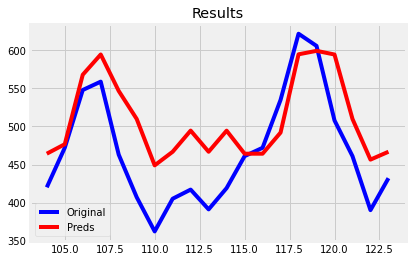

In [39]:
import matplotlib.pyplot as plt
plt.plot(holdout_df[target], color="blue", label="Original")
plt.plot(holdout_df["predicted_value"], color="red", label="Preds")
plt.legend(loc="best")
plt.title("Results")
plt.show()

In [40]:
holdout_df[[target, "predicted_value"]]

,#Passengers_lead20,predicted_value
104,420.0,464.224241
105,472.0,476.696934
106,548.0,568.077144
107,559.0,594.724725
108,463.0,546.768369
109,407.0,509.899262
110,362.0,448.887263
111,405.0,466.788179
112,417.0,494.597976
113,391.0,466.788179
